In [44]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_image(image_path, model, resize = False, debug = False):

    image_save_prefix = image_path.split('/')[-1].split('.')[0]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if resize:
        image = cv2.resize(image, (128, 128))
        image = image / 255.0

    int_image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, height, width)
    input_image = np.expand_dims(int_image, axis=-1)  # Add channel dimension: (1, height, width, 1)

    # Predict mask
    predicted_mask =  model.predict(input_image)[0, :, :, 0]  # (128, 128)

    start_time = time.time()*1000
    #scalar region
    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(predicted_mask >= scalar_lower_bound, predicted_mask <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(predicted_mask >= iris_lower_bound, predicted_mask <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    distances = [np.linalg.norm(np.array([center_x, center_y]) - point[0]) for point in largest_iris_contour]
    iris_radius = round(np.mean(distances)) if distances else 0

    print(f"Iris radius: {iris_radius}")

    all_points = np.vstack([cnt.reshape(-1, 2) for cnt in scalar_contours])
    leftmost_idx = np.argmin(all_points[:, 0])
    rightmost_idx = np.argmax(all_points[:, 0])
    
    leftmost = tuple(all_points[leftmost_idx])
    rightmost = tuple(all_points[rightmost_idx])

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    distance_left_middle = round(np.linalg.norm(np.array(leftmost) - np.array(middle_point)))

    if debug:

        if resize == False:
            image = cv2.resize(image, (128, 128))
            image = image / 255.0
    
        norm_predicted_mask = (predicted_mask - predicted_mask.min()) / (predicted_mask.max() - predicted_mask.min() + 1e-8)
        # Convert grayscale input image to RGB
        input_image_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        # Create a color mask for the predicted mask (e.g., green overlay)
        color_mask = np.zeros_like(input_image_rgb)
        color_mask[..., 1] = (norm_predicted_mask * 255).astype(np.uint8)  # Green channel

        # Blend the input image and the color mask
        alpha = 0.3  # Transparency factor
        input_image_rgb = cv2.addWeighted(input_image_rgb, 1 - alpha, color_mask, alpha, 0)

        # Draw circles at leftmost and rightmost points
        cv2.circle(input_image_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
        cv2.circle(input_image_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
        cv2.circle(input_image_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Yellow circle
        cv2.circle(input_image_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
        cv2.line(input_image_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
        cv2.arrowedLine(input_image_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)
        cv2.circle(input_image_rgb, middle_point, radius=distance_left_middle, color=(0, 255, 0), thickness=1)  # Green circle
        cv2.circle(input_image_rgb, iris_center, radius=iris_radius, color=(225, 0, 0), thickness=1) 

        predicted_mask_rgb = input_image_rgb

        # Display the mask with circles
        plt.figure(figsize=(8, 8))
        plt.imshow(predicted_mask_rgb)
        plt.title('Predicted Mask with Circles')
        plt.axis('off')
        plt.show()

    # # Create the directory if it doesn't exist
    # output_dir = "gaze_vector_prediction"
    # os.makedirs(output_dir, exist_ok=True)

    # # Define the output file path
    # output_file_path = os.path.join(output_dir, image_save_prefix+"_vectors.png")

    # # Save the image
    # cv2.imwrite(output_file_path, cv2.cvtColor(predicted_mask_rgb, cv2.COLOR_RGB2BGR))
    # print(f"Image saved to {output_file_path}")
    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    end_time = time.time()*1000
    print(f"Time taken: {end_time - start_time} ms")
    return iris_center_vector , middle_point_vector

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_from_lable_img(label_path, debug = False):
    label = np.load(label_path)
    label = cv2.resize(label, (128, 128))
    label = label / np.max(label)

    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(label >= scalar_lower_bound, label <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(label >= iris_lower_bound, label <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    # Calculate iris radius as the mean distance from center to all contour points
    distances = [np.linalg.norm(np.array([center_x, center_y]) - point[0]) for point in largest_iris_contour]
    iris_radius = round(np.mean(distances)) if distances else 0
    print(f"Iris radius: {iris_radius}")

    # Initialize leftmost and rightmost points
    leftmost = (128, 128)
    rightmost = (0, 0)

    # Find extreme points from all contours
    for contour in scalar_contours:
        for point in contour:
            x, y = point[0]
            if x < leftmost[0]:
                leftmost = (x, y)
            if x > rightmost[0]:
                rightmost = (x, y)

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    distance_left_middle = round(np.linalg.norm(np.array(leftmost) - np.array(middle_point)))
    print(f"Distance between Leftmost and Middle Point: {distance_left_middle}")
    # Convert predicted mask to RGB to draw colored circles

    if debug:
  
        predicted_mask_rgb = cv2.cvtColor((label * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

        # Draw circles at leftmost and rightmost points
        cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
        cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
        cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
        cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
        cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
        cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)
        cv2.circle(predicted_mask_rgb, middle_point, radius=distance_left_middle, color=(0, 255, 0), thickness=1)  # Green circle
        cv2.circle(predicted_mask_rgb, iris_center, radius=iris_radius, color=(225, 0, 0), thickness=1) 

        plt.figure(figsize=(8, 8))
        plt.imshow(predicted_mask_rgb)
        plt.title('Predicted Mask with Circles')
        plt.axis('off')
        plt.show()

    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    return iris_center_vector, middle_point_vector

In [4]:
def pixel_to_camera_ray(pixel, camera_matrix):
    """
    Convert pixel coordinates to camera ray in 3D space.
    """
    # Inverse the camera matrix
    inv_camera_matrix = np.linalg.inv(camera_matrix)
    
    # Create a homogeneous coordinate for the pixel
    pixel_homogeneous = np.array([pixel[0], pixel[1], 1])
    
    # Calculate the camera ray
    camera_ray = inv_camera_matrix @ pixel_homogeneous
    return camera_ray[:3]  # Return only the x, y, z components


def calculate_gaze_vector(iris_center, middle_point, camera_matrix):
    """
    Calculate the gaze vector in 3D space.
    """
    # Convert pixel coordinates to camera rays
    iris_ray = pixel_to_camera_ray(iris_center, camera_matrix)
    middle_point_ray = pixel_to_camera_ray(middle_point, camera_matrix)

    # Normalize the rays
    iris_ray /= np.linalg.norm(iris_ray)
    middle_point_ray /= np.linalg.norm(middle_point_ray)

    # Calculate the gaze vector
    gaze_vector = middle_point_ray - iris_ray
    gaze_vector /= np.linalg.norm(gaze_vector)  # Normalize the gaze vector

    return gaze_vector


Error processing 0.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(97))
Rightmost Point: (np.int32(109), np.int32(91))


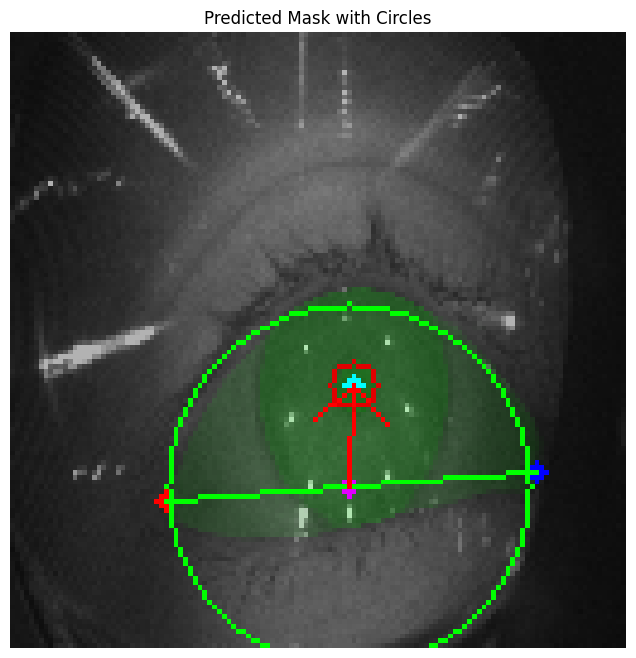

Time taken: 70.4345703125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 1.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(97))
Rightmost Point: (np.int32(109), np.int32(89))


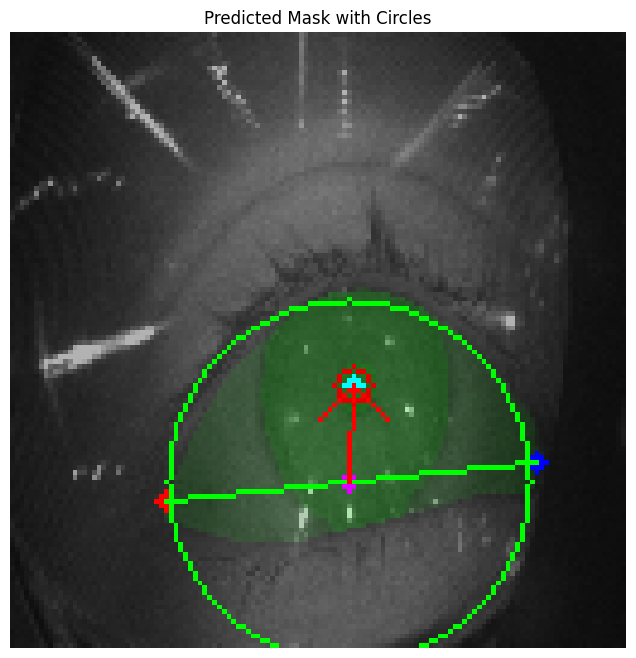

Time taken: 62.86669921875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 10.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(107), np.int32(93))


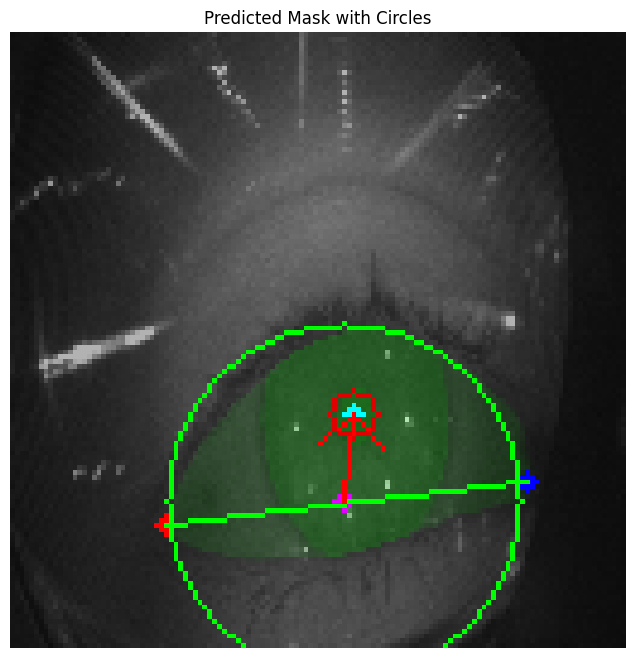

Time taken: 55.999755859375 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 100.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(88))


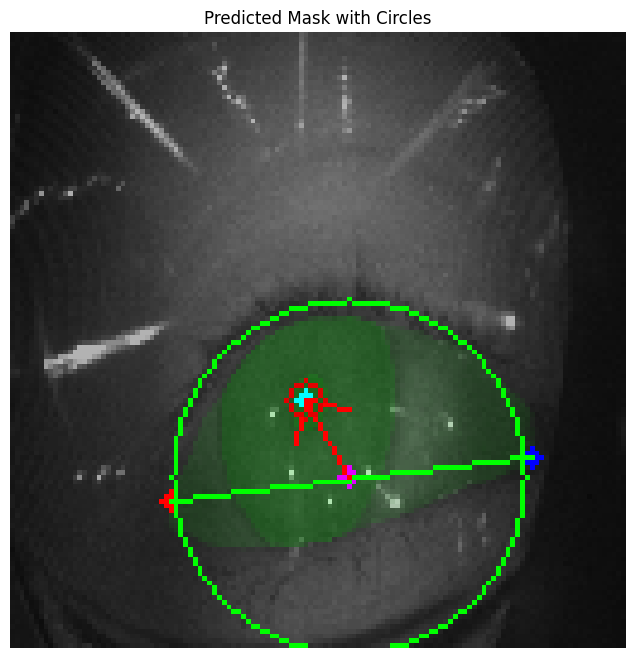

Time taken: 50.33349609375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(88))
Distance between Leftmost and Middle Point: 37
Error processing 101.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(82))


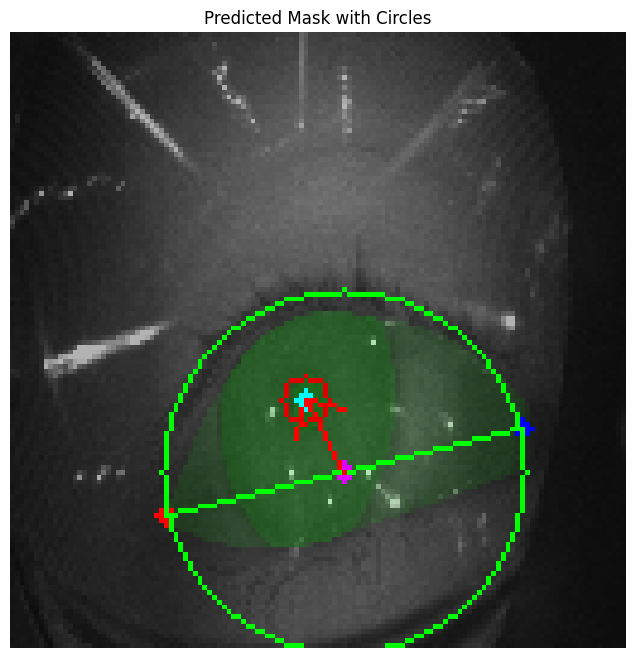

Time taken: 55.98388671875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 102.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(83))


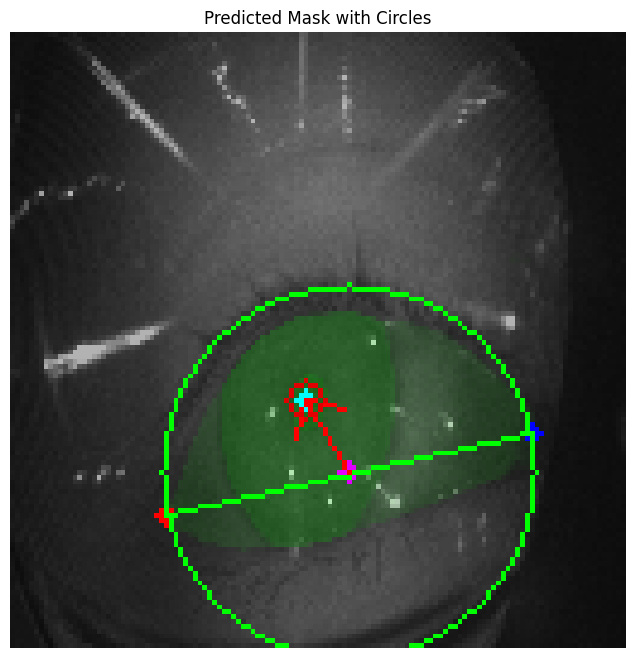

Time taken: 51.910400390625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(85))
Distance between Leftmost and Middle Point: 39
Error processing 103.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(82))


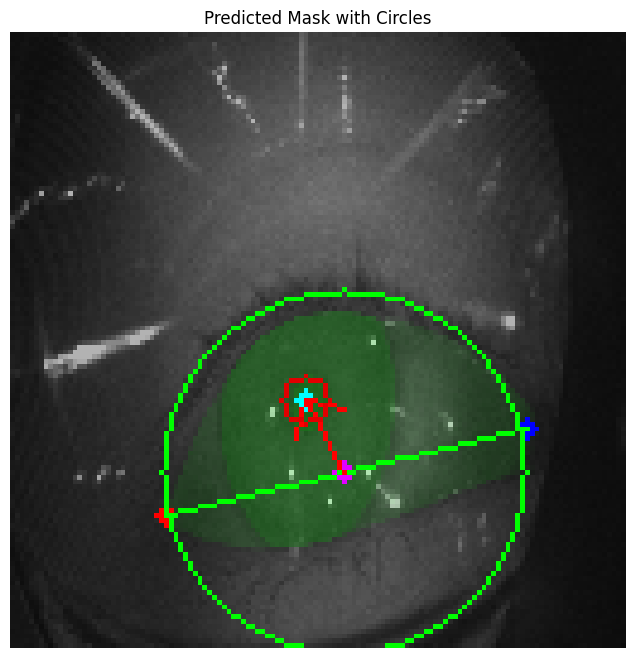

Time taken: 56.558349609375 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(106), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 104.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(83))


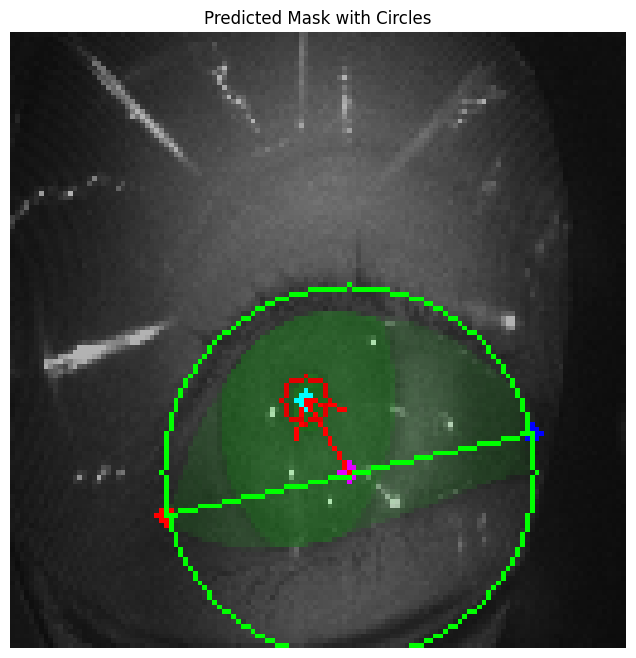

Time taken: 51.55908203125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(83))
Distance between Leftmost and Middle Point: 39
Error processing 105.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(106), np.int32(83))


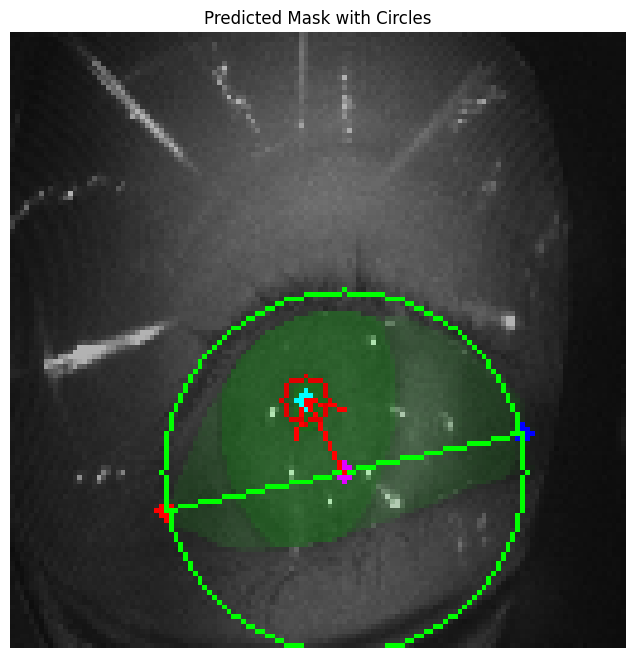

Time taken: 53.4990234375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(82))
Distance between Leftmost and Middle Point: 38
Error processing 106.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(83))


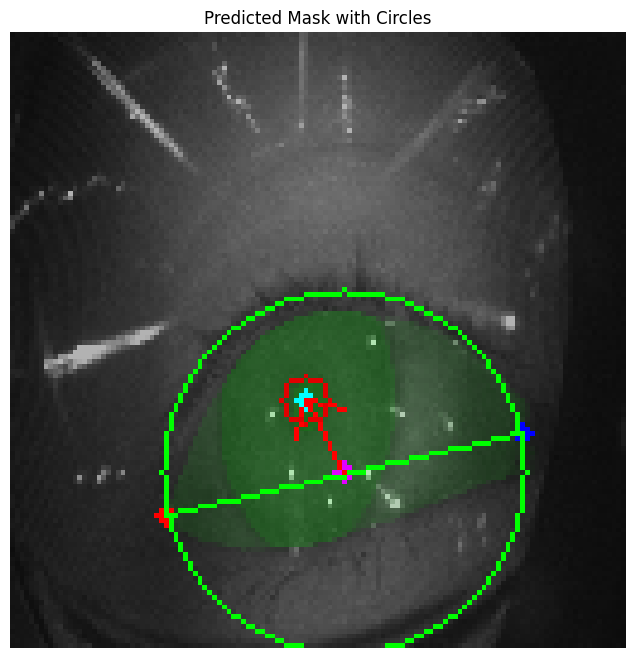

Time taken: 58.05078125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(107), np.int32(86))
Distance between Leftmost and Middle Point: 38
Error processing 107.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(79))


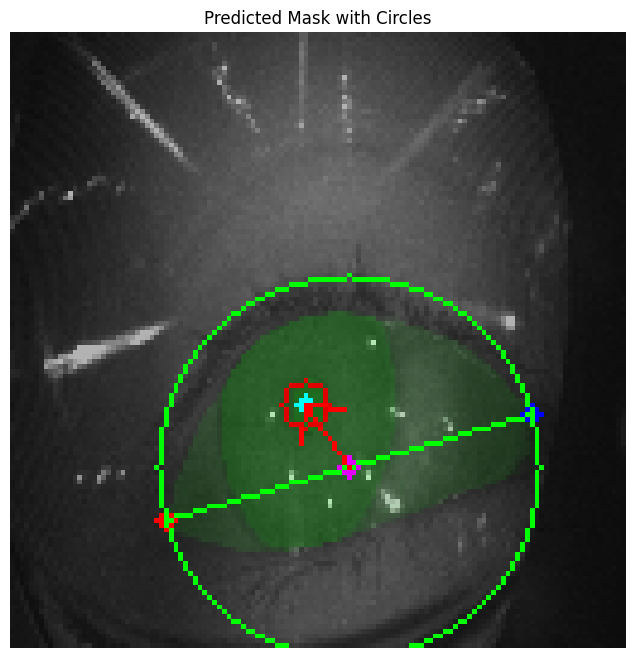

Time taken: 52.07861328125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(85))
Distance between Leftmost and Middle Point: 39
Error processing 108.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(81))


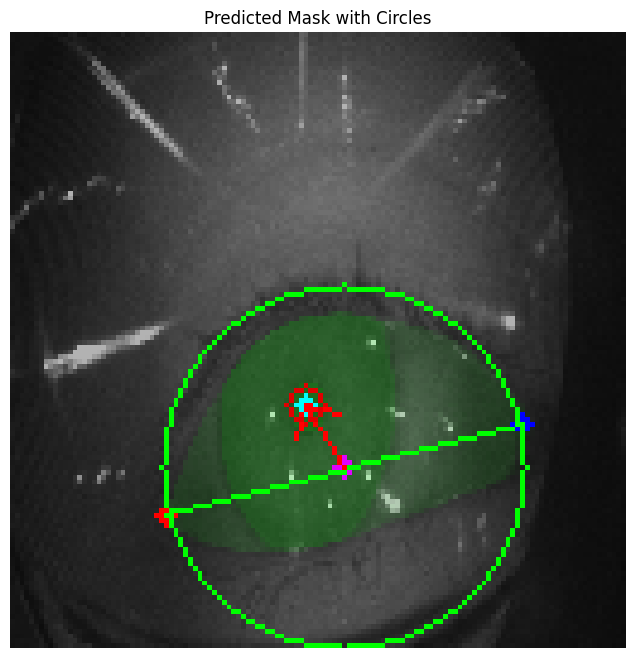

Time taken: 49.099853515625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(107), np.int32(81))
Distance between Leftmost and Middle Point: 38
Error processing 109.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(107), np.int32(88))


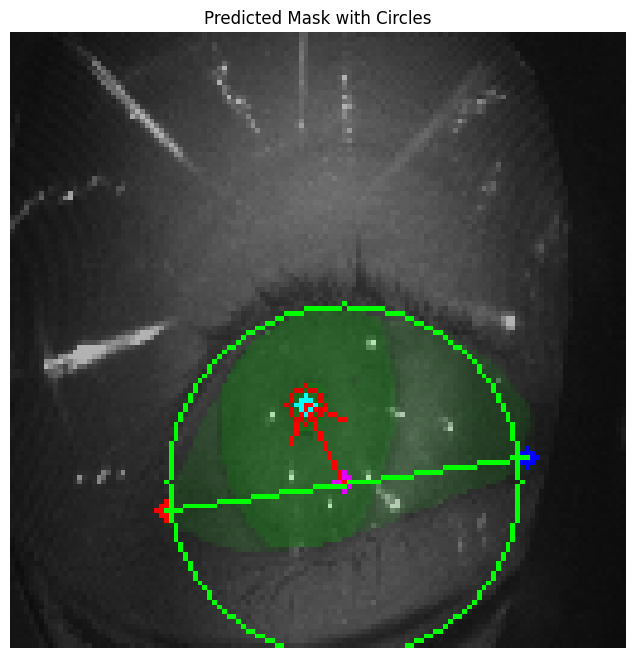

Time taken: 63.94287109375 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(107), np.int32(83))
Distance between Leftmost and Middle Point: 38
Error processing 11.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(88))


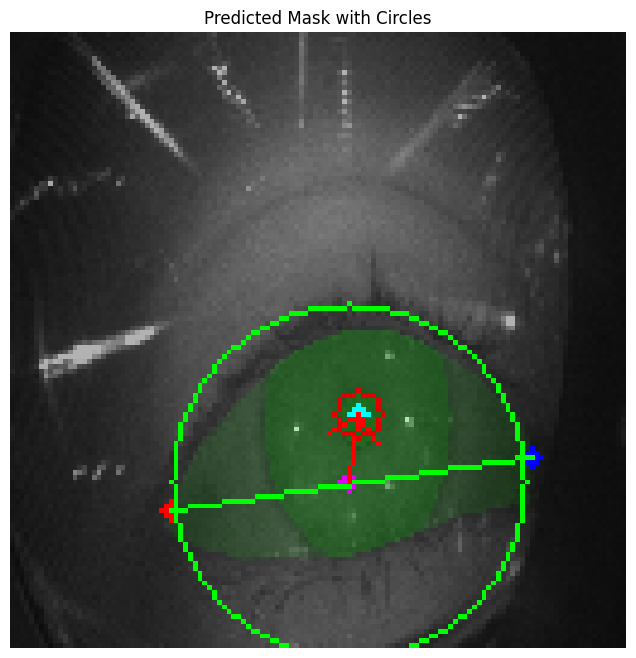

Time taken: 56.918701171875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(90))
Distance between Leftmost and Middle Point: 37
Error processing 110.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(106), np.int32(88))


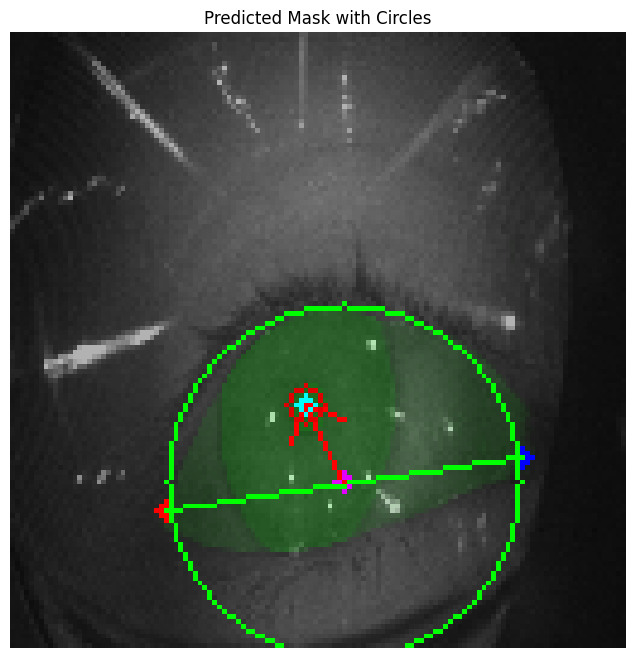

Time taken: 54.21240234375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(86))
Distance between Leftmost and Middle Point: 38
Error processing 111.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(87))


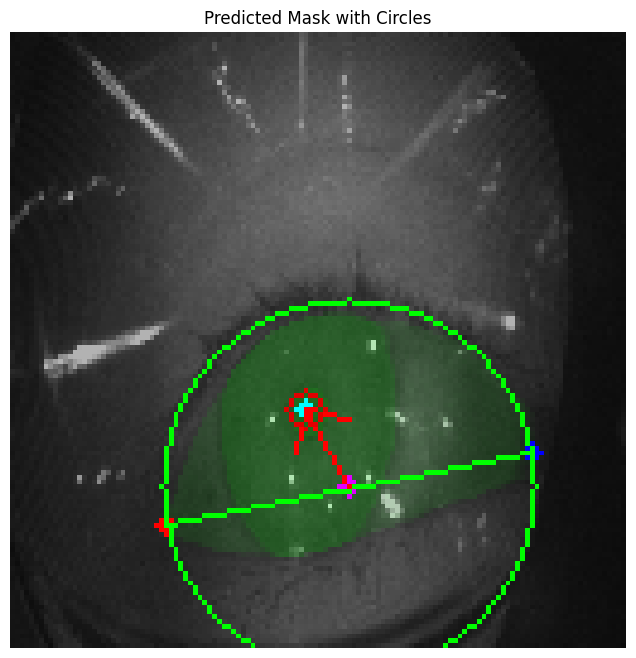

Time taken: 73.346923828125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(86))
Distance between Leftmost and Middle Point: 38
Error processing 112.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(107), np.int32(94))


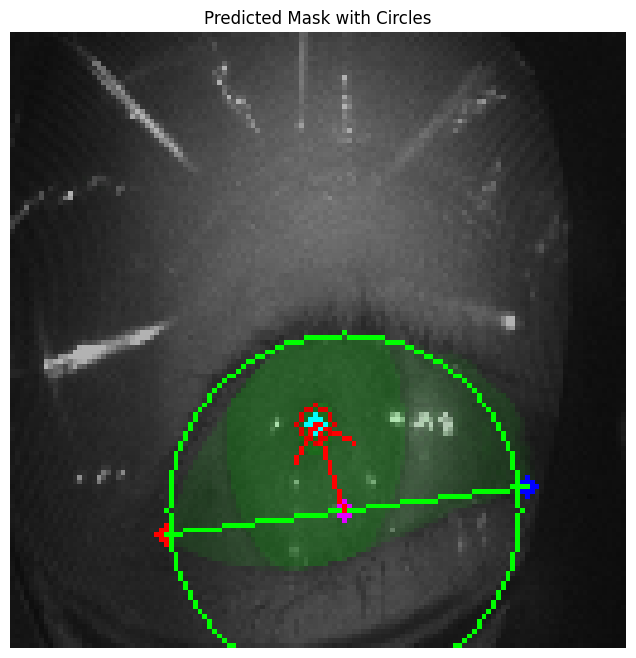

Time taken: 48.6513671875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(93))
Distance between Leftmost and Middle Point: 37
Error processing 113.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(83))


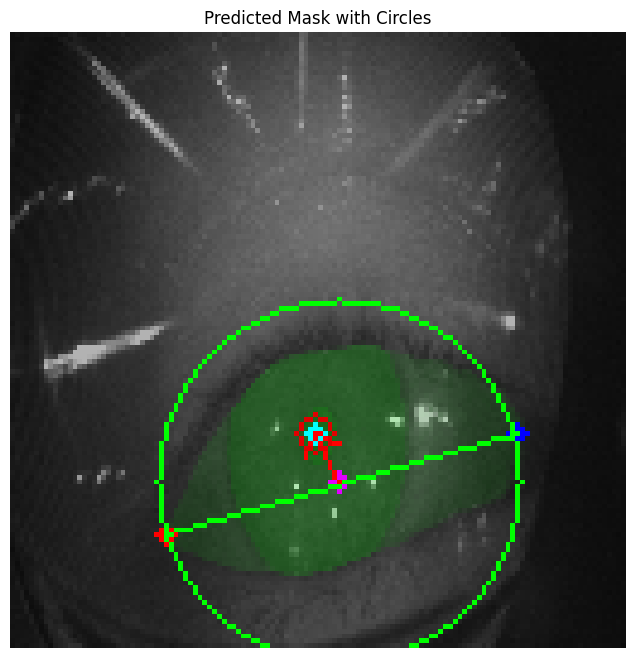

Time taken: 51.4638671875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 114.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(90))


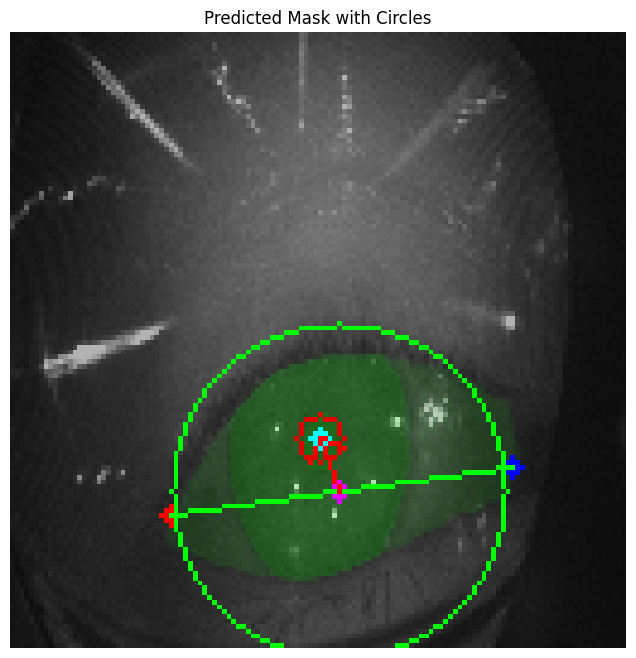

Time taken: 50.4599609375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(104), np.int32(93))
Distance between Leftmost and Middle Point: 36
Error processing 115.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(104), np.int32(90))


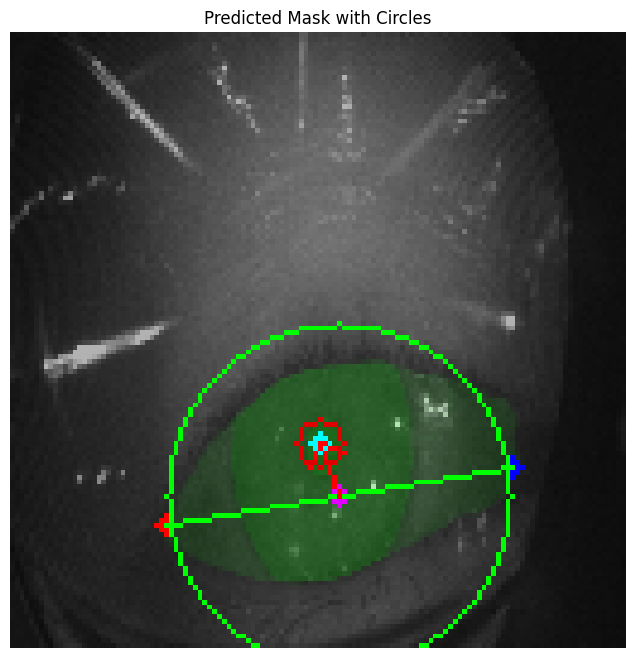

Time taken: 58.31103515625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 116.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(84))


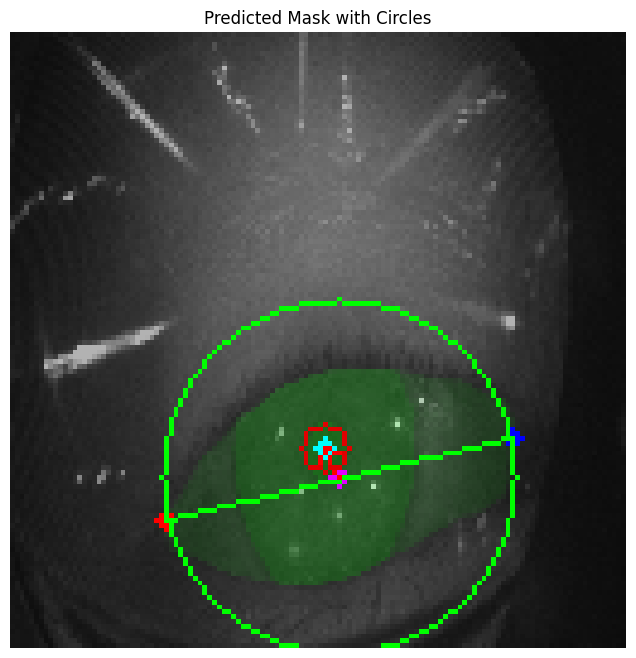

Time taken: 74.92578125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 117.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(93))


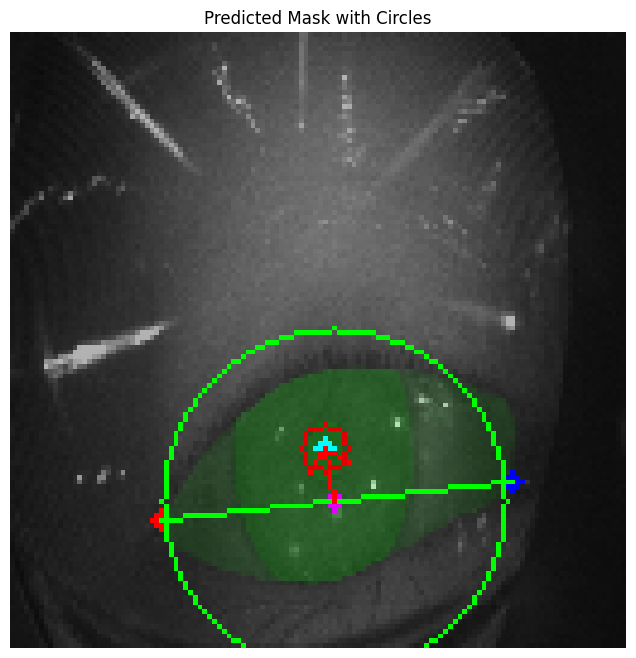

Time taken: 59.191650390625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 118.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(102))
Rightmost Point: (np.int32(104), np.int32(91))


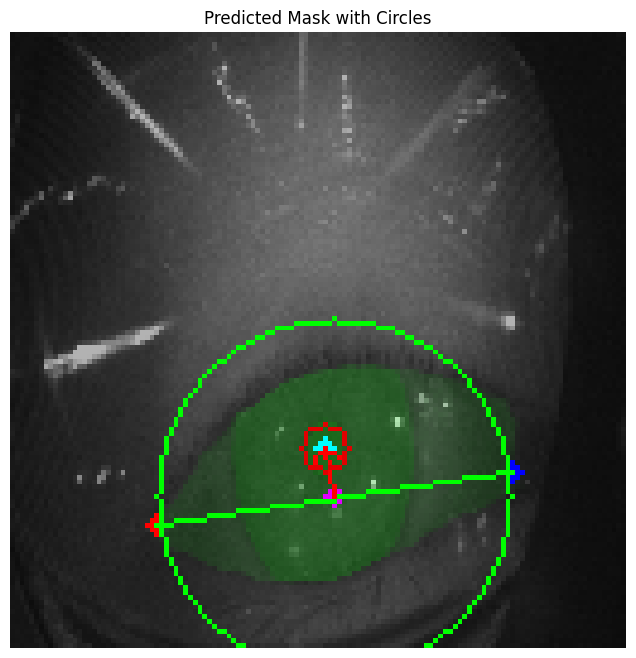

Time taken: 47.531494140625 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(93))
Distance between Leftmost and Middle Point: 36
Error processing 119.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(91))


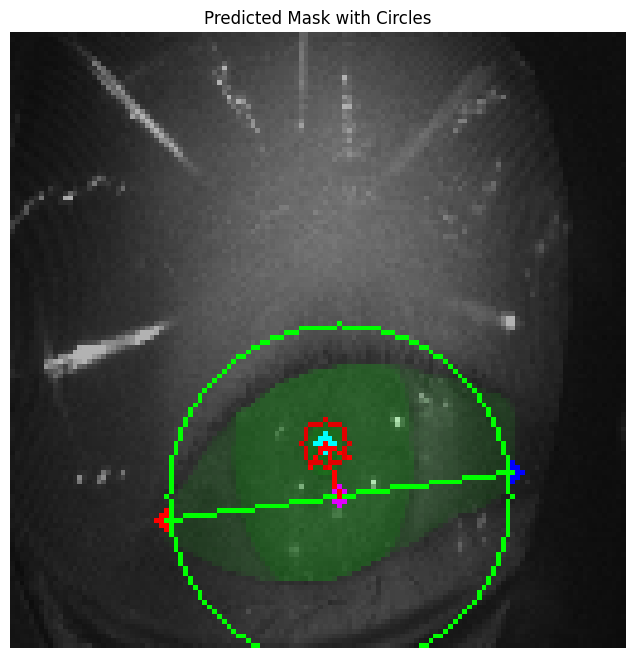

Time taken: 54.134765625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 12.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(96))


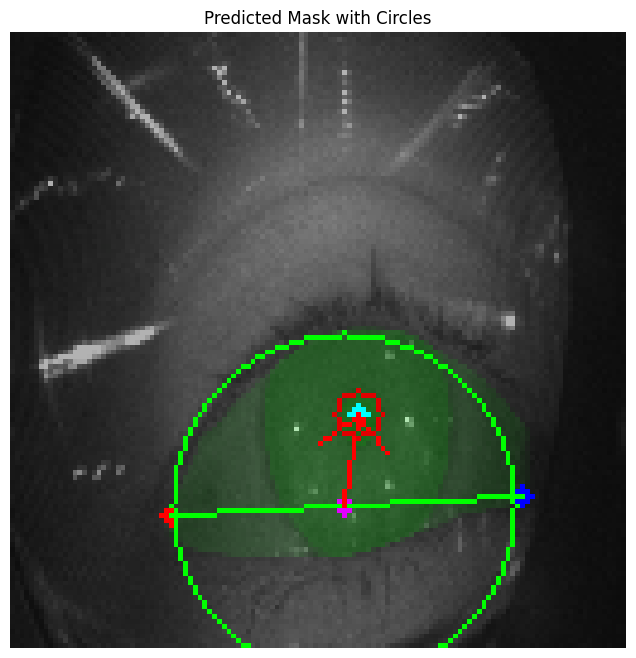

Time taken: 54.912841796875 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 120.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(88))


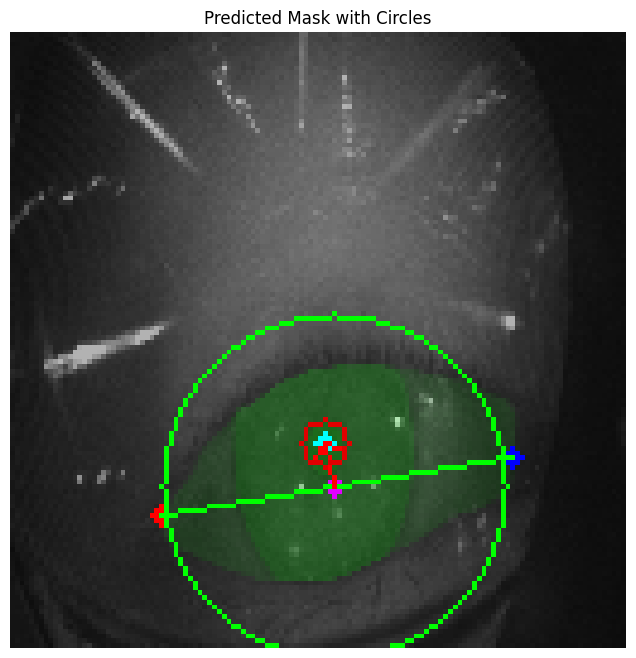

Time taken: 55.4013671875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(82))
Distance between Leftmost and Middle Point: 38
Error processing 121.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(105), np.int32(88))


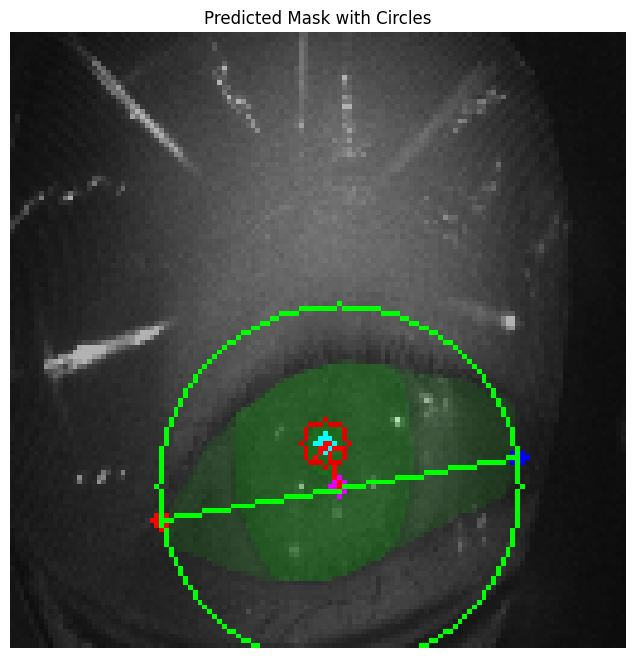

Time taken: 53.197998046875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 122.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(89))


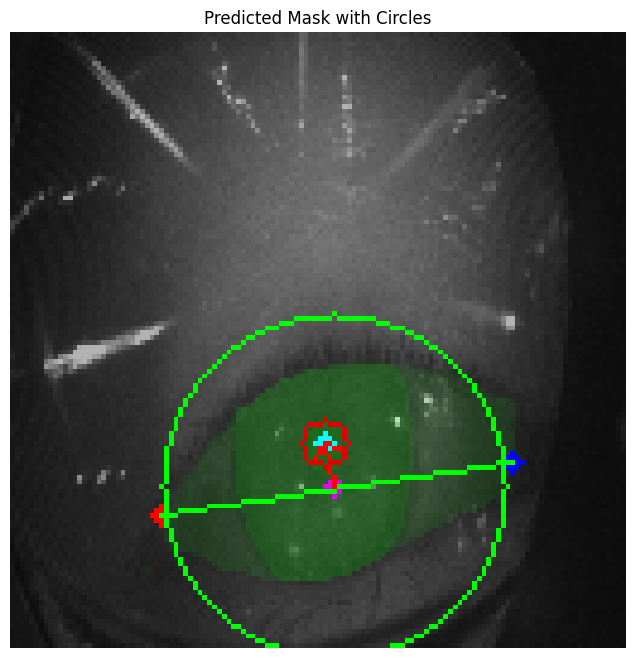

Time taken: 53.555908203125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 123.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(104), np.int32(92))


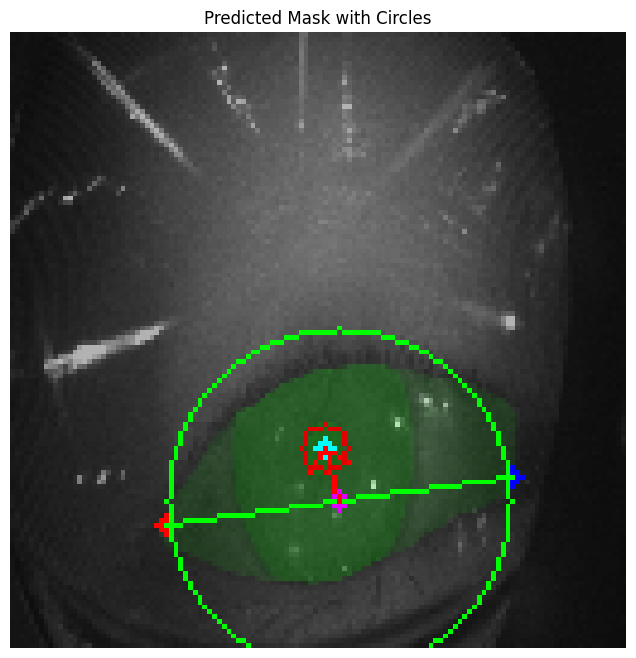

Time taken: 44.763427734375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 124.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(92))


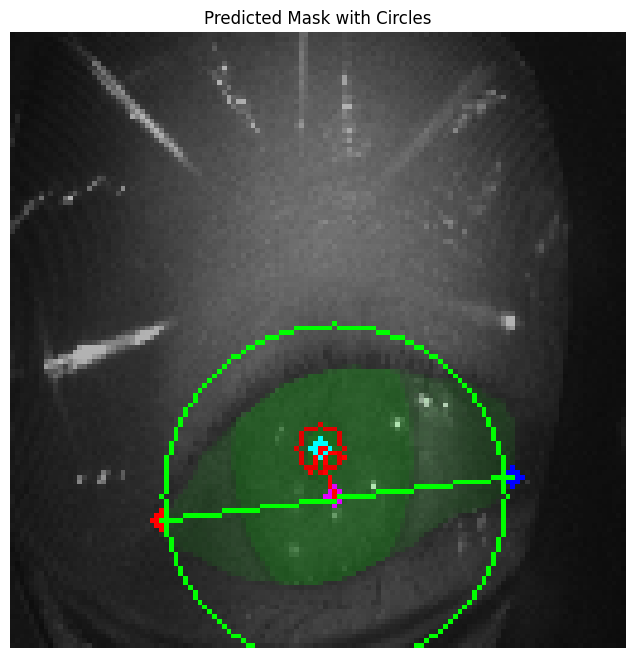

Time taken: 51.41015625 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(105), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 125.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(102))
Rightmost Point: (np.int32(104), np.int32(92))


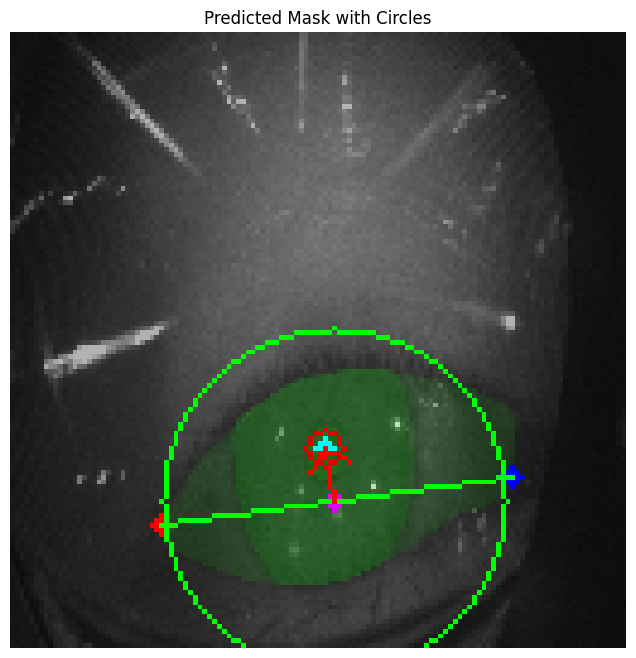

Time taken: 53.65185546875 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 126.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(104), np.int32(91))


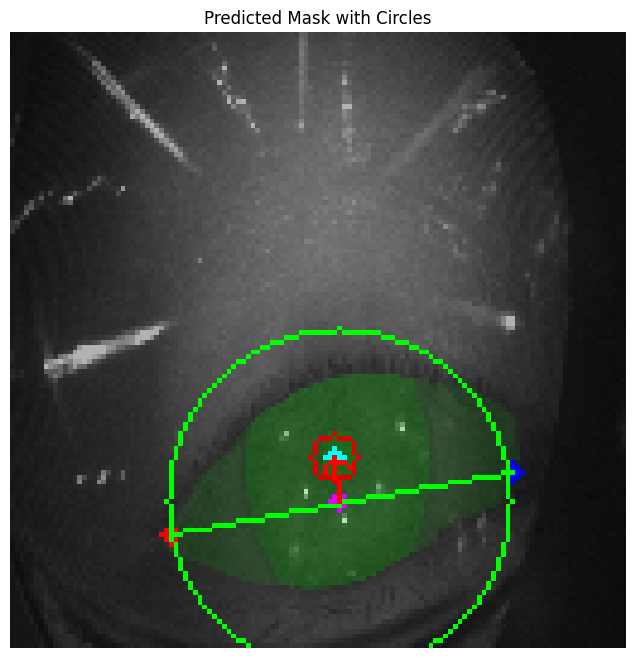

Time taken: 57.186279296875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 127.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(106))
Rightmost Point: (np.int32(104), np.int32(91))


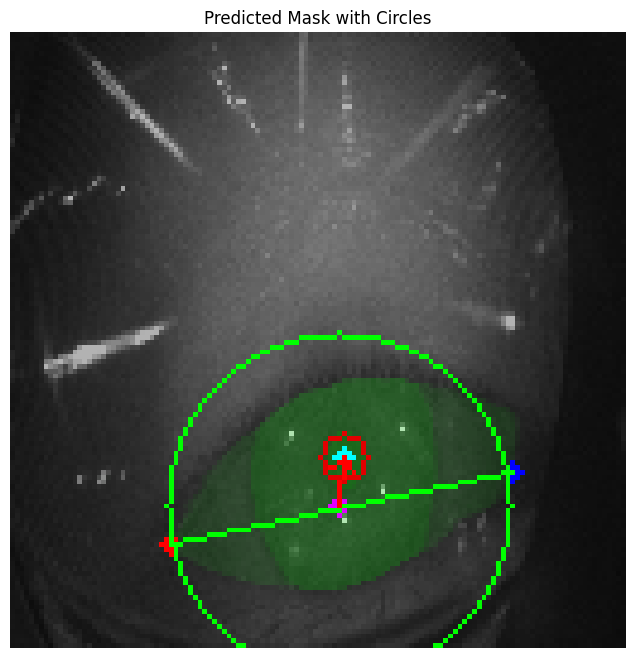

Time taken: 62.544921875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 36
Error processing 128.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(88))


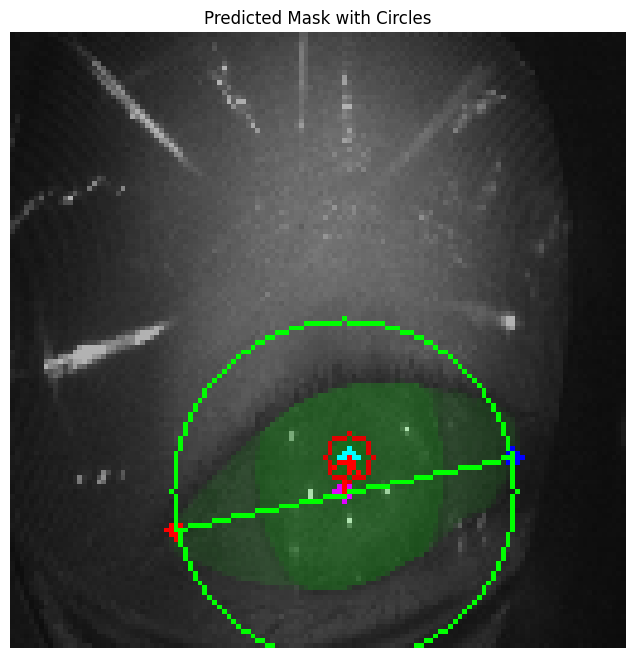

Time taken: 53.802001953125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(89))
Distance between Leftmost and Middle Point: 36
Error processing 129.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(82))


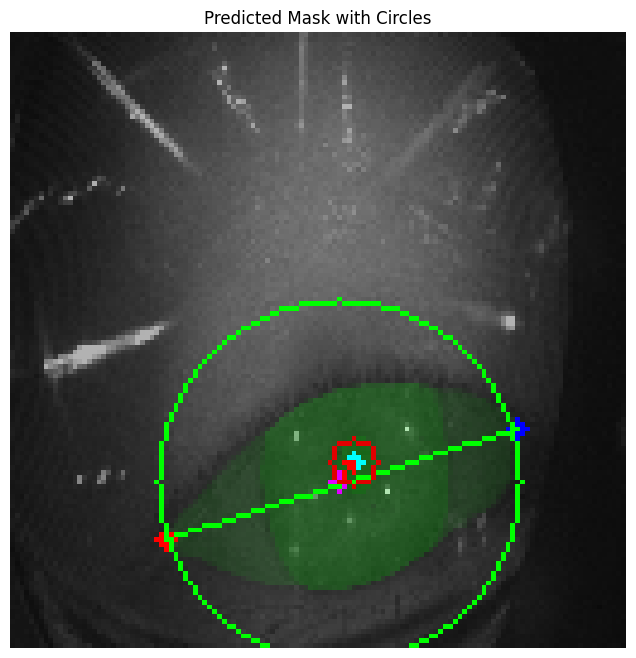

Time taken: 65.19775390625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 13.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(90))


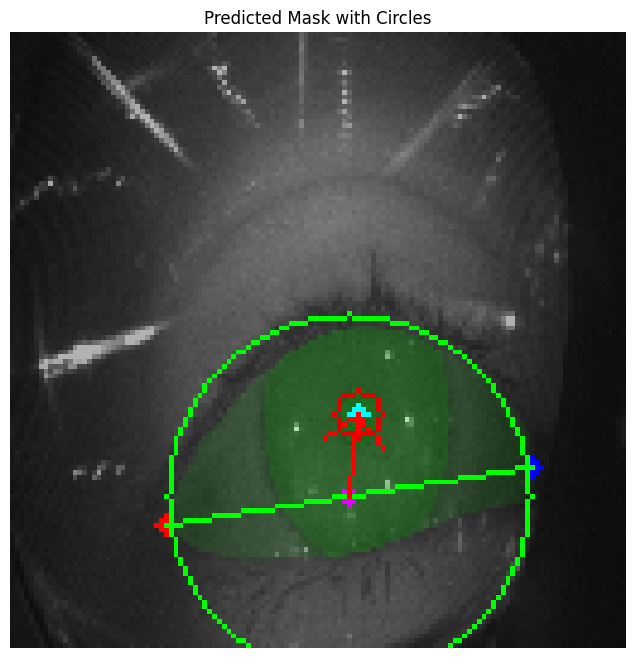

Time taken: 47.133056640625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 130.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(85))


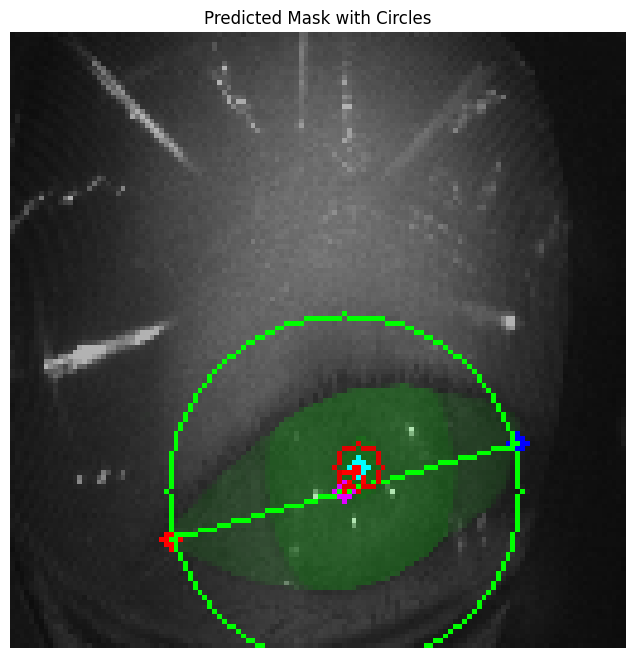

Time taken: 64.43115234375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(106), np.int32(85))
Distance between Leftmost and Middle Point: 37
Error processing 131.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(85))


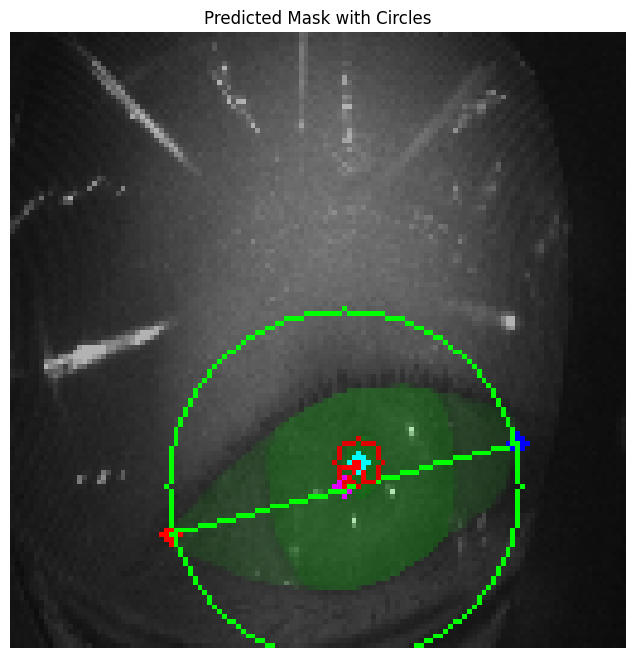

Time taken: 53.16064453125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(90))
Distance between Leftmost and Middle Point: 36
Error processing 132.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(87))


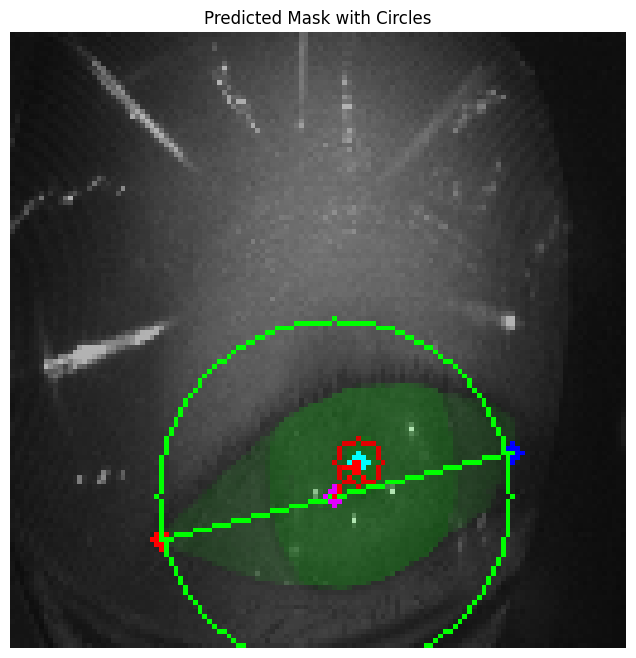

Time taken: 116.31298828125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(84))
Distance between Leftmost and Middle Point: 38
Error processing 133.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(82))


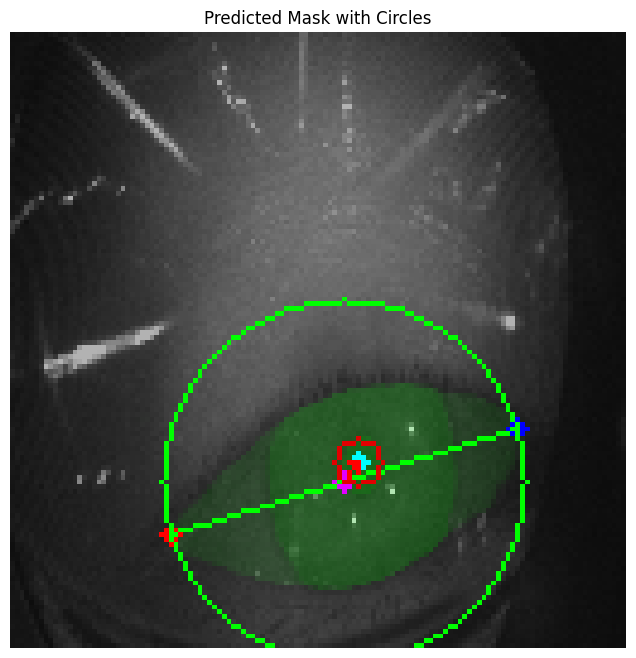

Time taken: 61.20703125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 134.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(82))


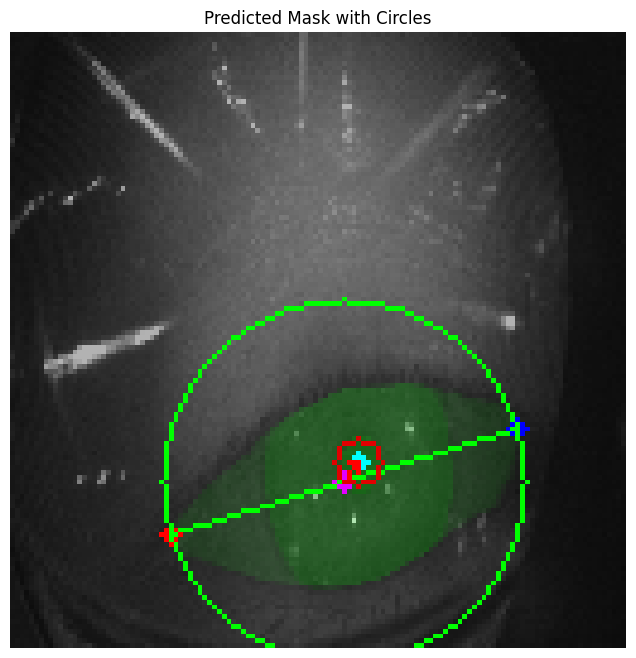

Time taken: 45.6015625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(106), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 135.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(88))


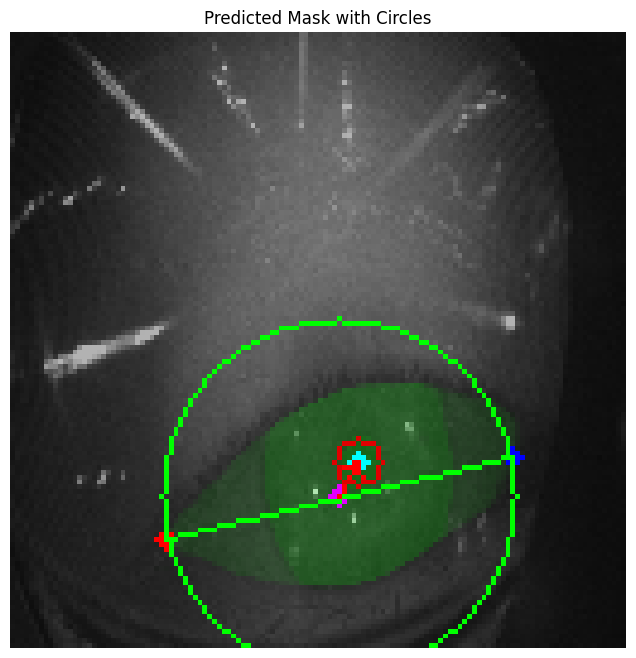

Time taken: 66.603759765625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 136.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(86))


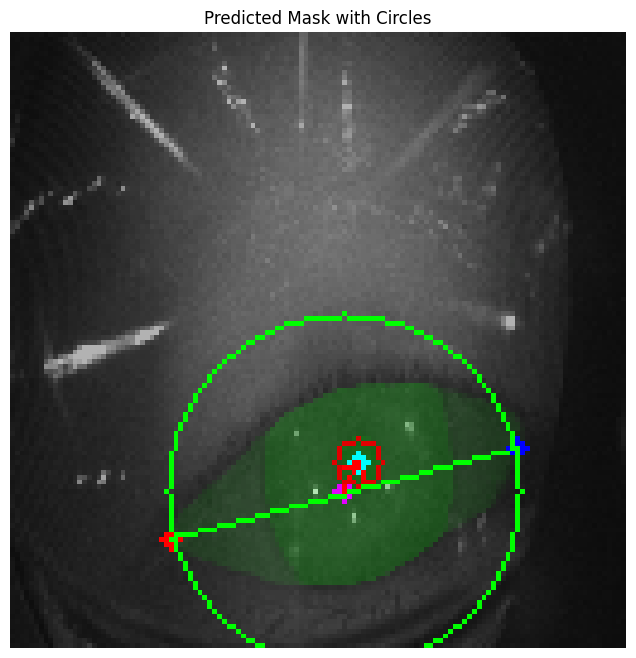

Time taken: 50.71044921875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 137.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(88))


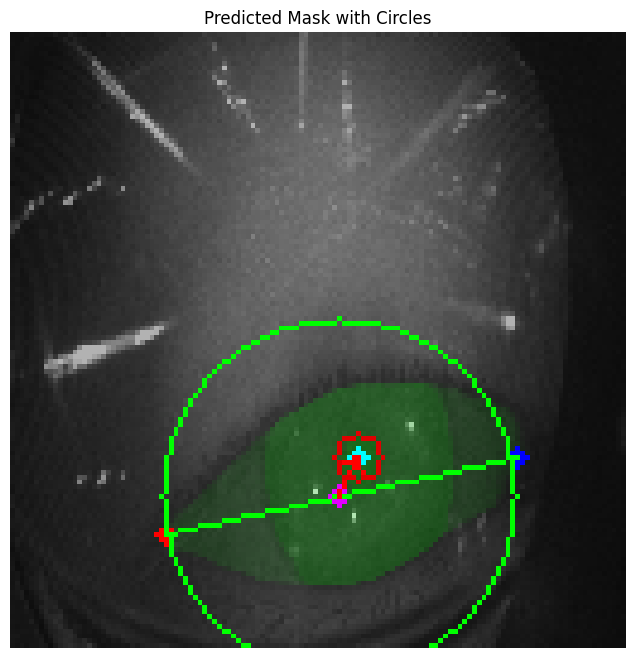

Time taken: 97.688232421875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 138.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(85))


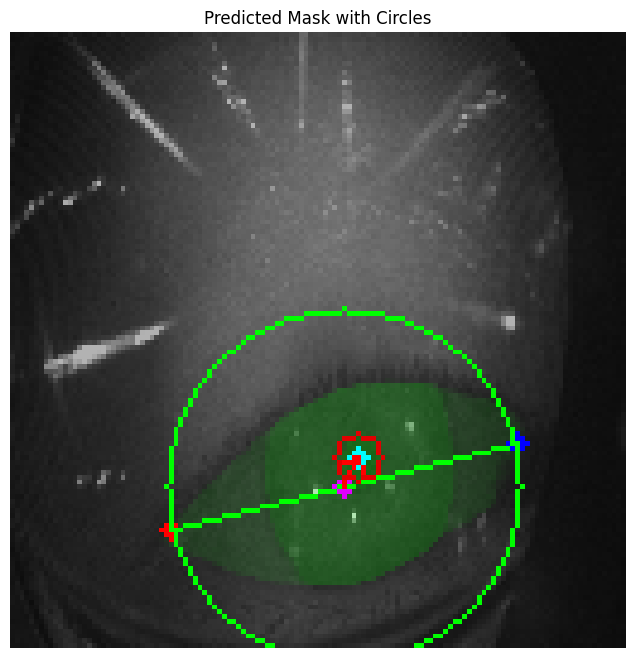

Time taken: 58.32763671875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(86))
Distance between Leftmost and Middle Point: 36
Error processing 139.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(104), np.int32(89))


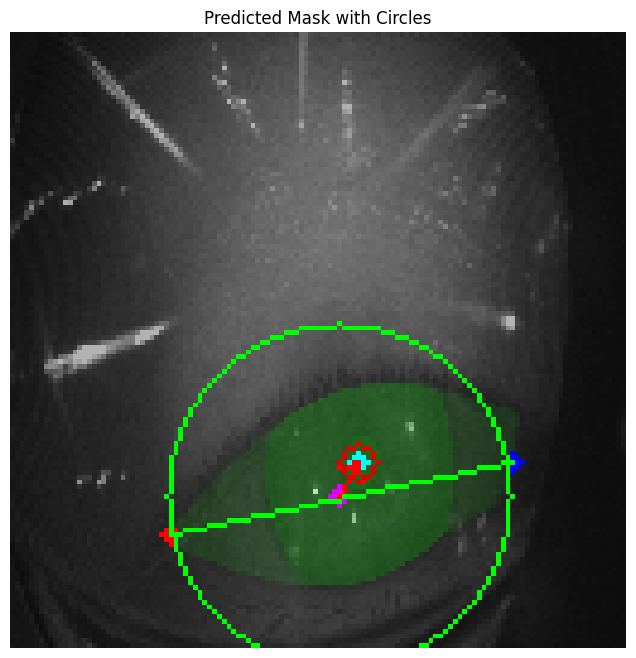

Time taken: 62.2431640625 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 14.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))


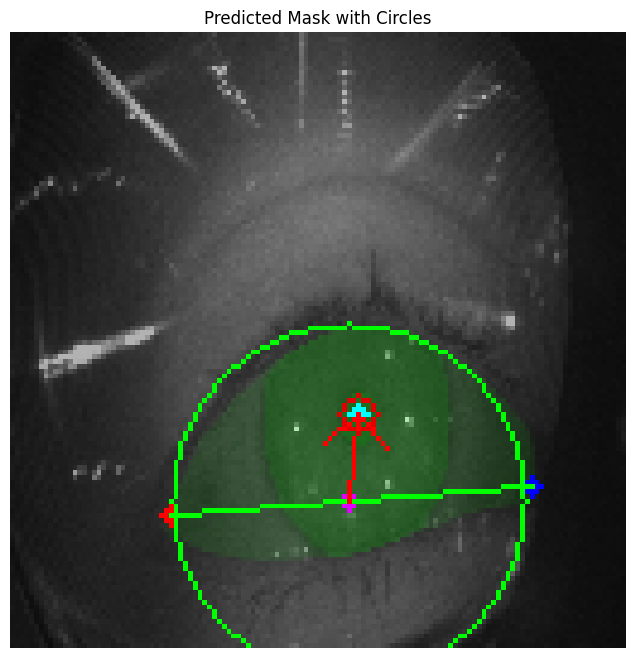

Time taken: 53.998779296875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 140.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(83))


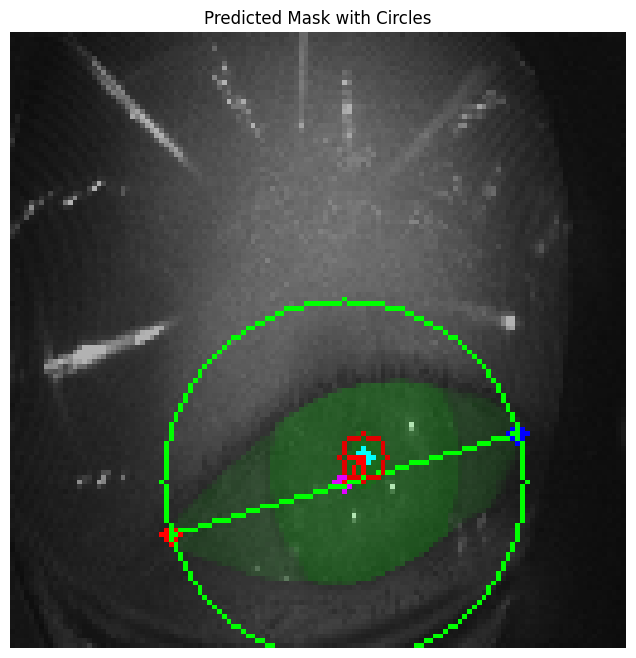

Time taken: 53.50341796875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 38
Error processing 141.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(85))


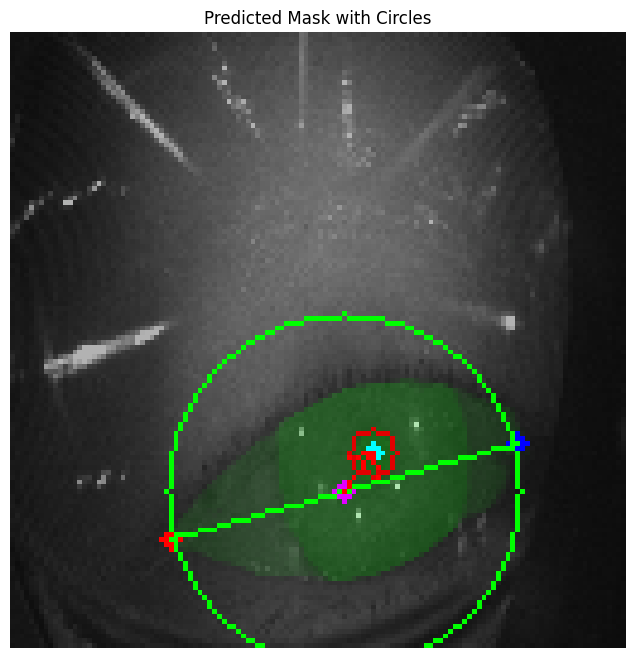

Time taken: 116.251953125 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(102))
Rightmost Point: (np.int32(105), np.int32(84))
Distance between Leftmost and Middle Point: 36
Error processing 142.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(88))


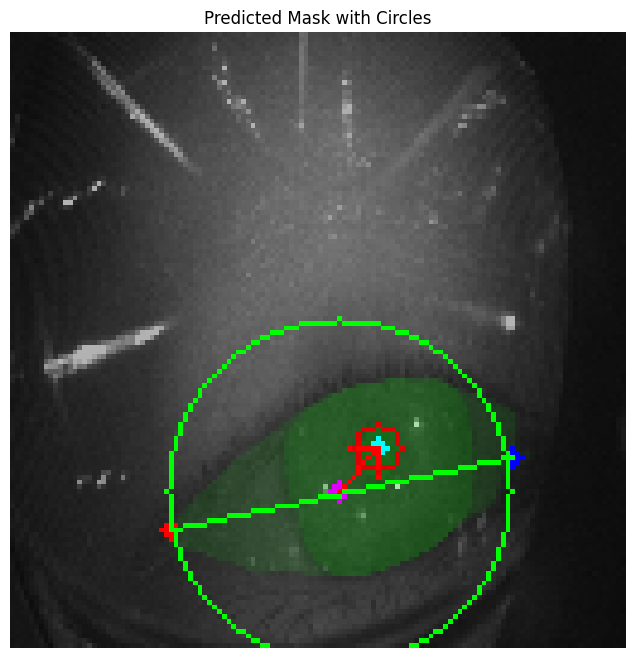

Time taken: 82.677001953125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 38
Error processing 143.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(90))


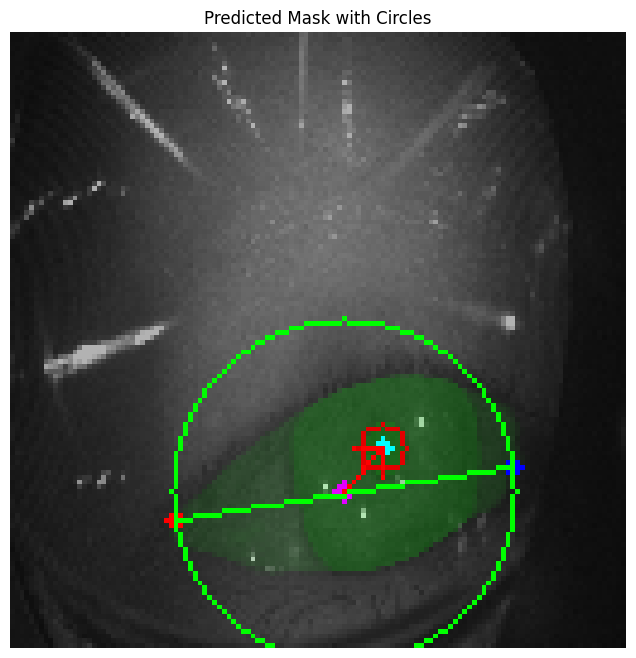

Time taken: 97.46533203125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(103), np.int32(83))
Distance between Leftmost and Middle Point: 36
Error processing 144.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(105), np.int32(80))


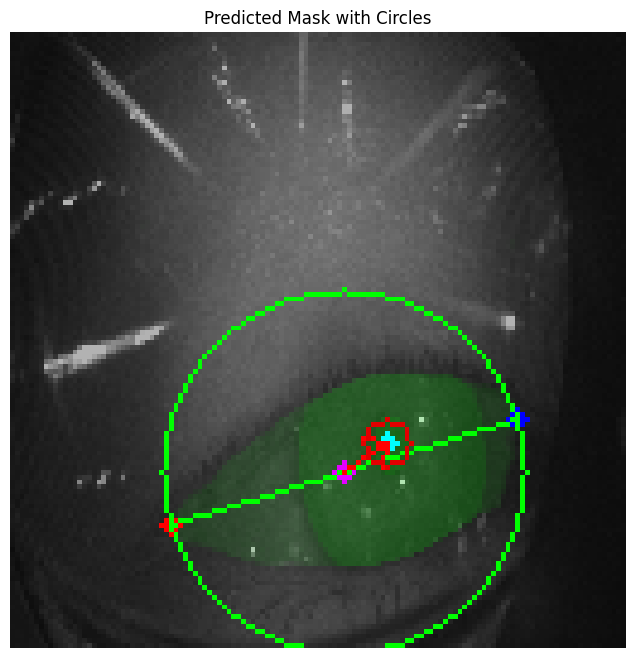

Time taken: 55.40185546875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(85))
Distance between Leftmost and Middle Point: 36
Error processing 145.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(82))


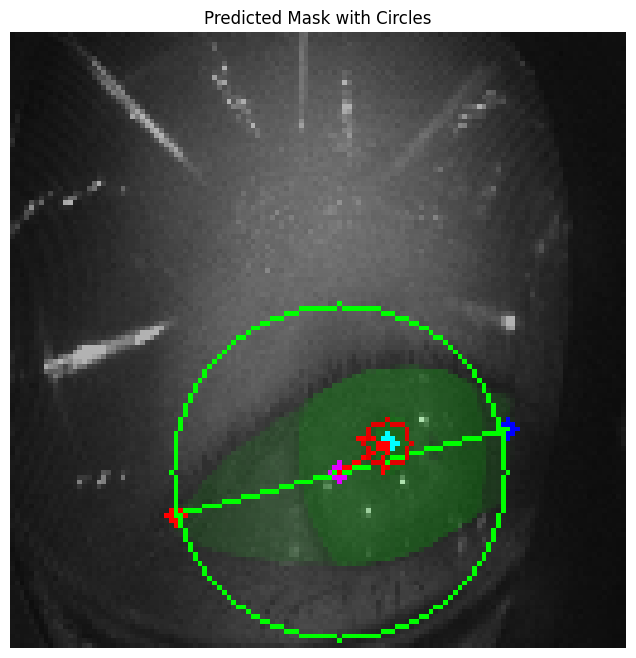

Time taken: 75.1953125 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(82))
Distance between Leftmost and Middle Point: 36
Error processing 146.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(82))


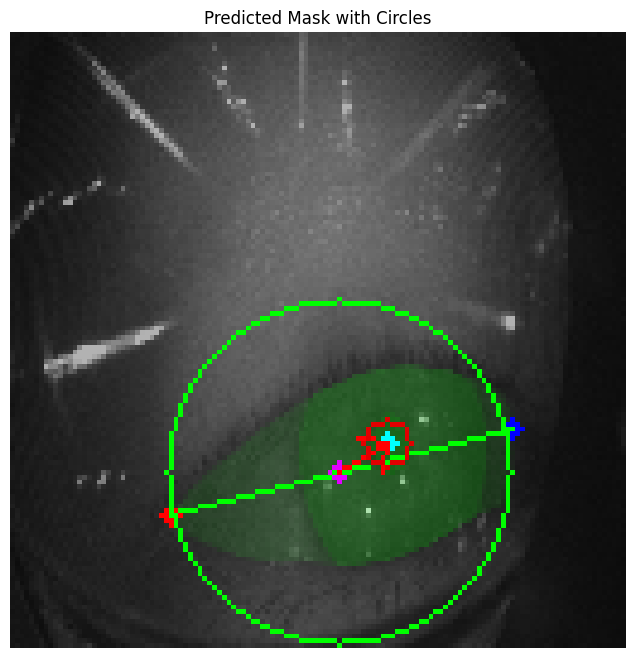

Time taken: 90.075927734375 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(102), np.int32(97))
Distance between Leftmost and Middle Point: 34
Error processing 147.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(83))


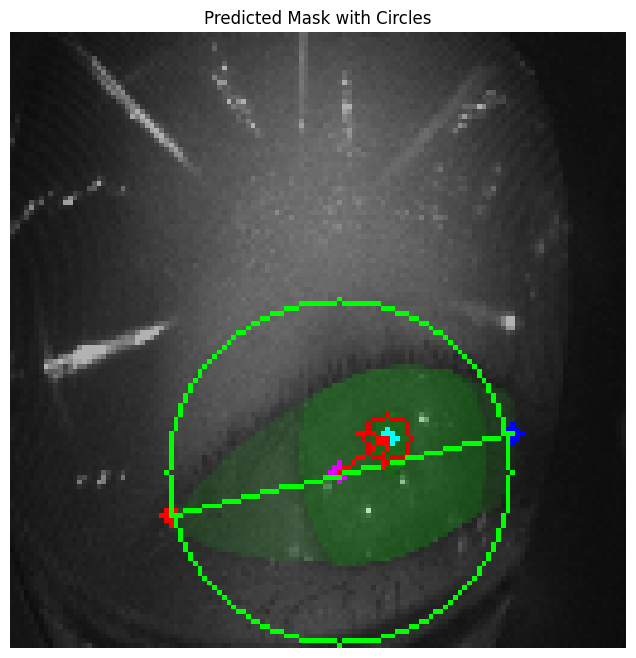

Time taken: 129.669921875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(83))
Distance between Leftmost and Middle Point: 36
Error processing 148.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(86))


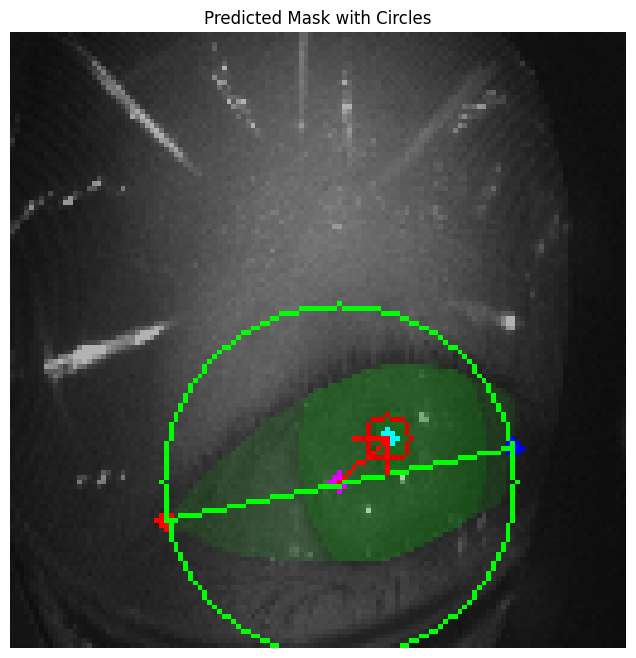

Time taken: 92.376220703125 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(86))
Distance between Leftmost and Middle Point: 36
Error processing 149.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(99))
Rightmost Point: (np.int32(104), np.int32(79))


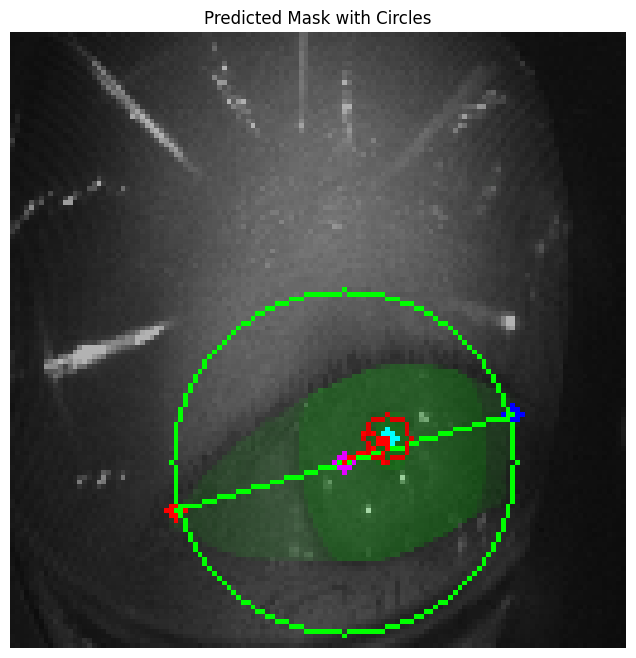

Time taken: 59.985595703125 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(99))
Rightmost Point: (np.int32(104), np.int32(88))
Distance between Leftmost and Middle Point: 36
Error processing 15.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(91))


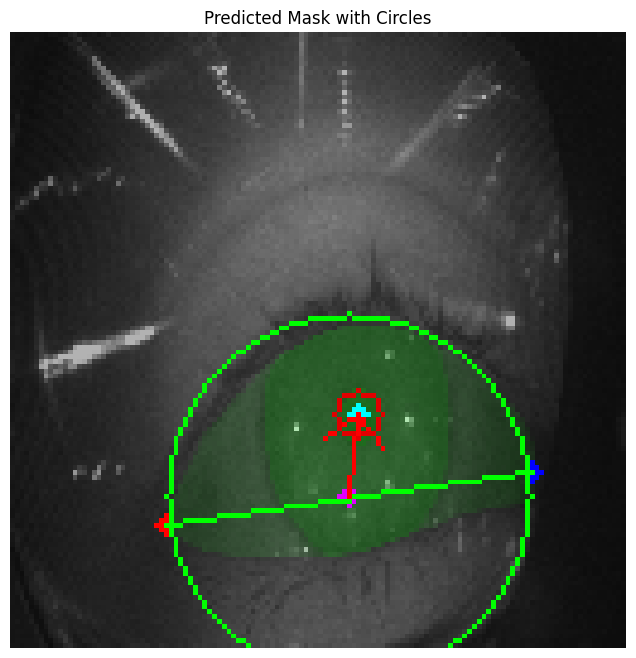

Time taken: 59.946044921875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(90))
Distance between Leftmost and Middle Point: 38
Error processing 150.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(83))


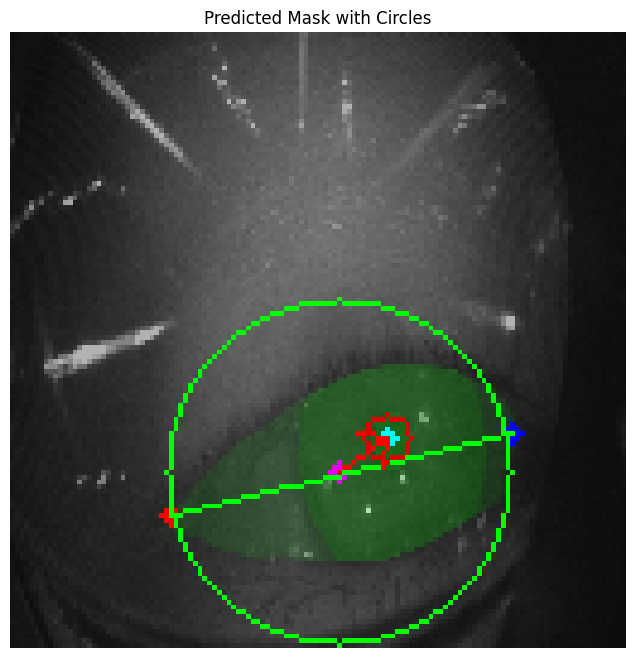

Time taken: 64.085205078125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(88))
Distance between Leftmost and Middle Point: 36
Error processing 151.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(83))


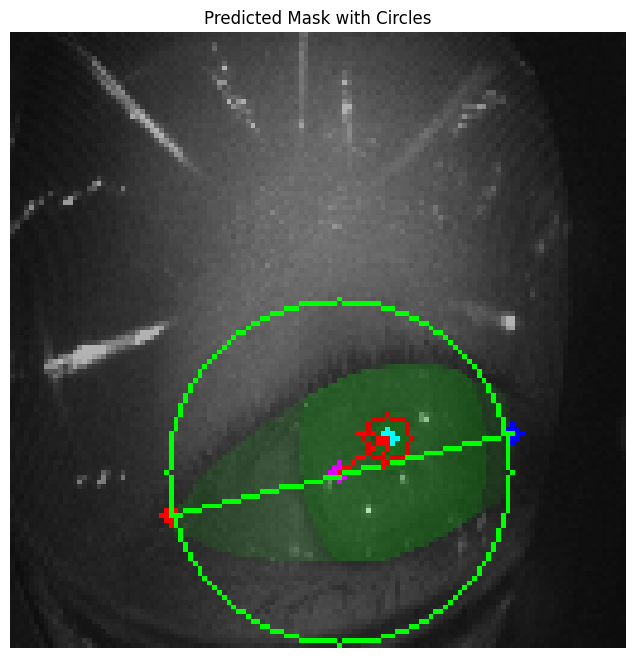

Time taken: 90.23681640625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(89))
Distance between Leftmost and Middle Point: 36
Error processing 152.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(80))


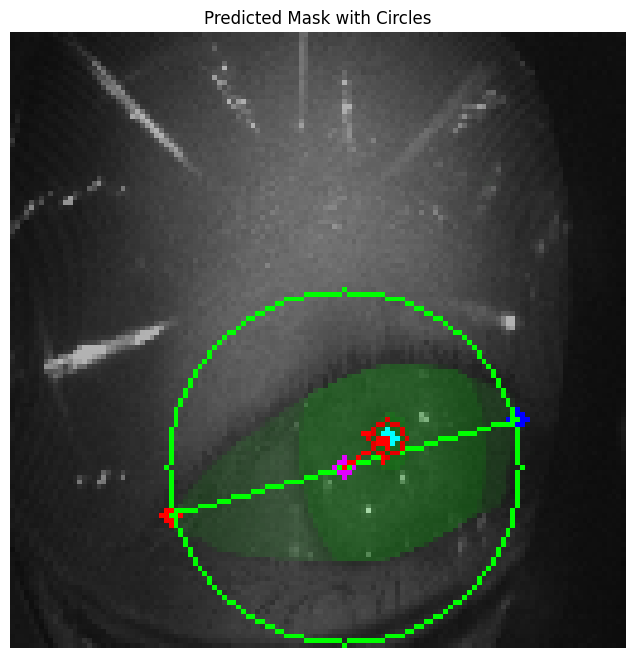

Time taken: 55.278564453125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 153.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(81))


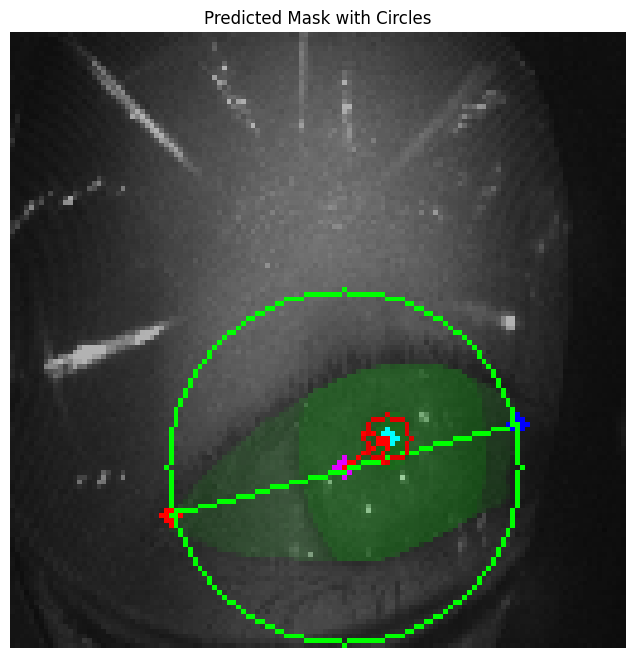

Time taken: 50.489013671875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(88))
Distance between Leftmost and Middle Point: 36
Error processing 154.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(90))


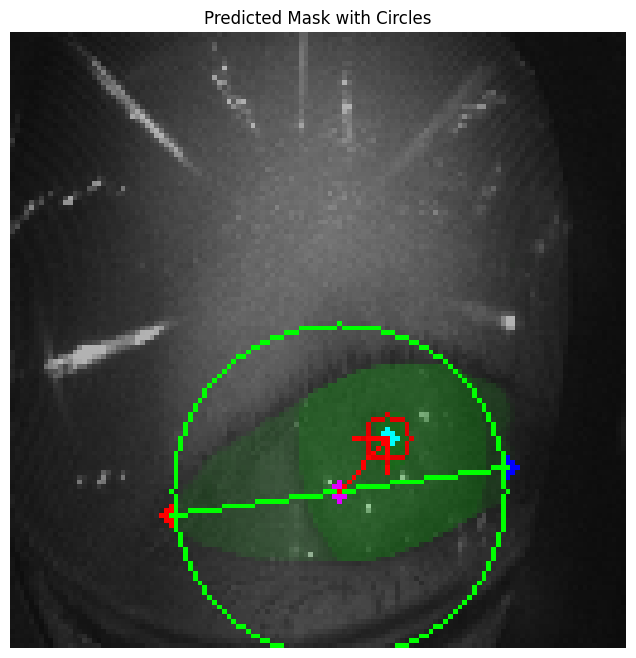

Time taken: 137.026123046875 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(99))
Rightmost Point: (np.int32(102), np.int32(91))
Distance between Leftmost and Middle Point: 34
Error processing 155.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(81))


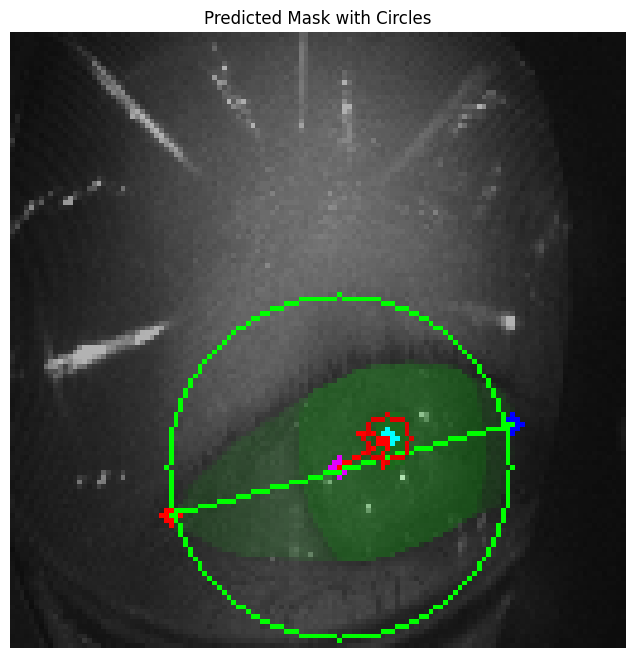

Time taken: 106.48583984375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(87))
Distance between Leftmost and Middle Point: 36
Error processing 16.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(89))


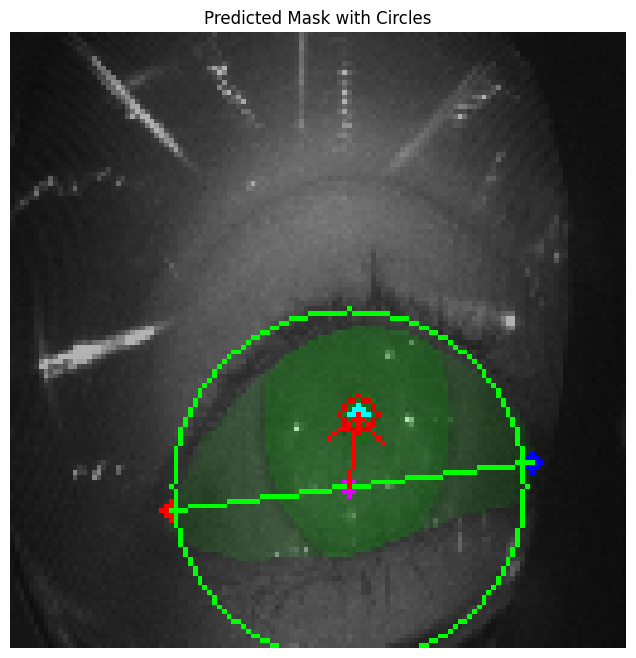

Time taken: 114.592041015625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 38
Error processing 17.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(90))


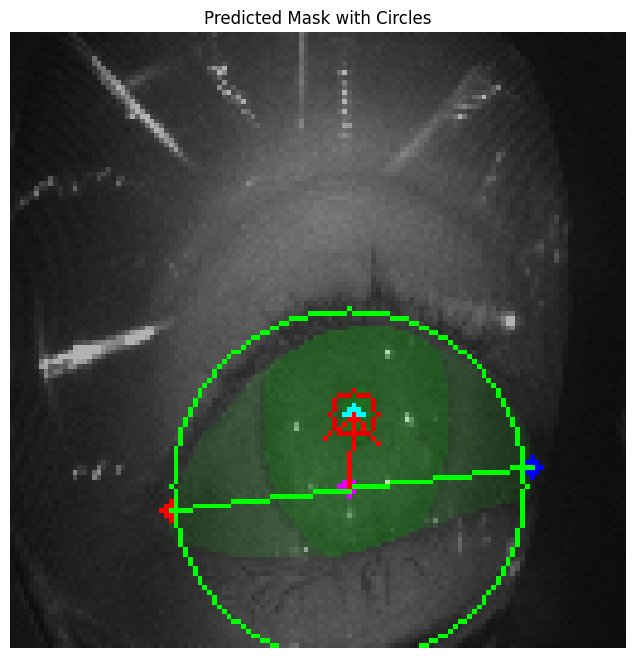

Time taken: 102.400634765625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 37
Error processing 18.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(90))


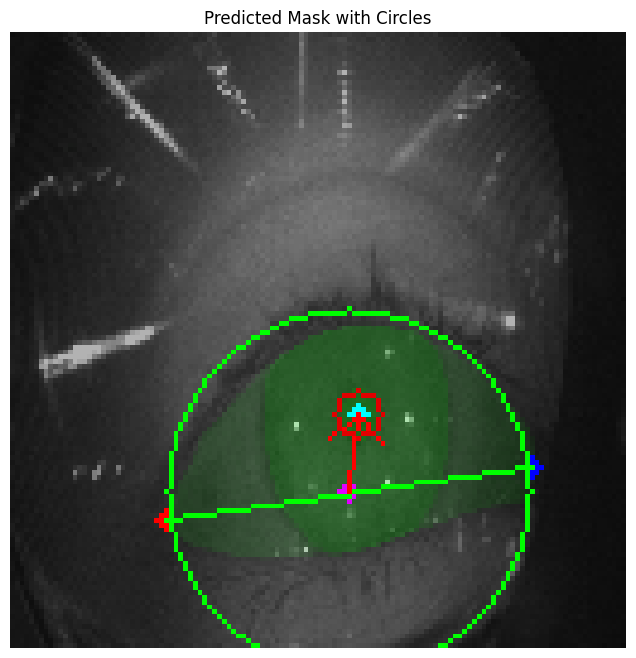

Time taken: 113.258544921875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 19.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(94))


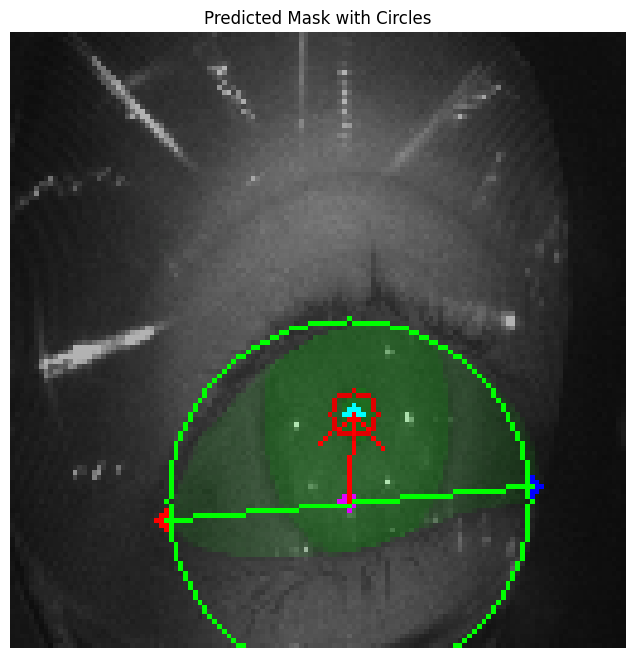

Time taken: 122.4755859375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 2.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(94))


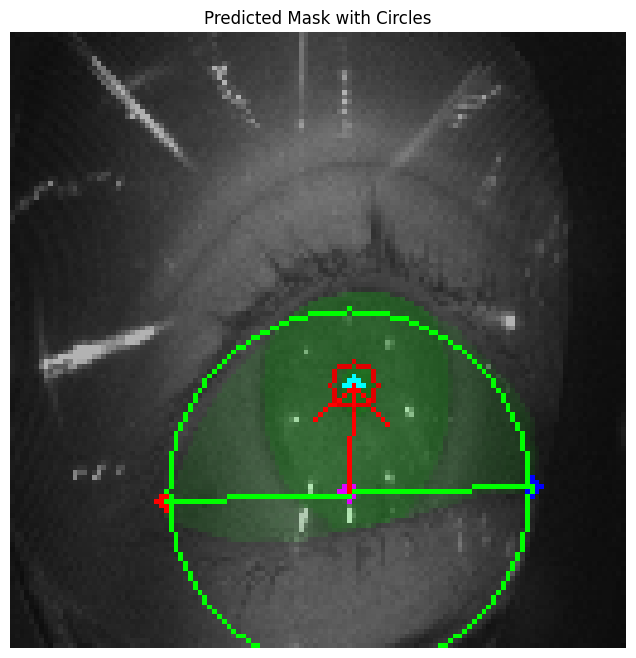

Time taken: 95.662841796875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 20.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(94))


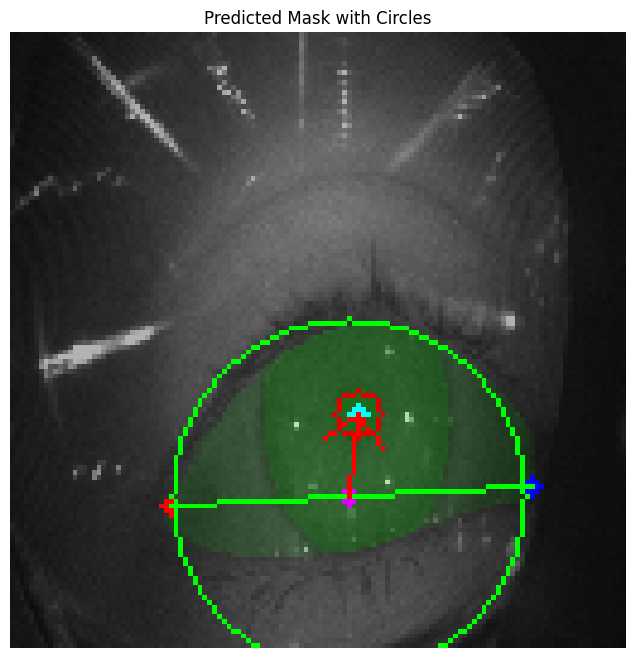

Time taken: 54.4990234375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 21.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(94))


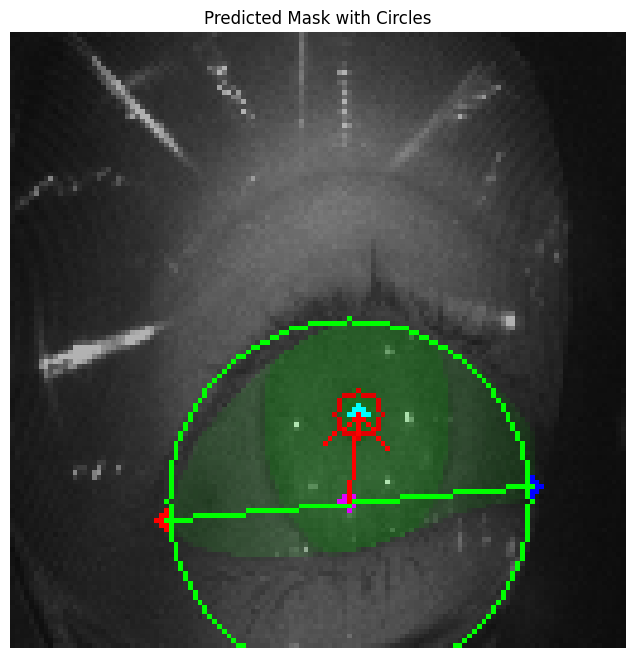

Time taken: 68.9853515625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 22.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(92))


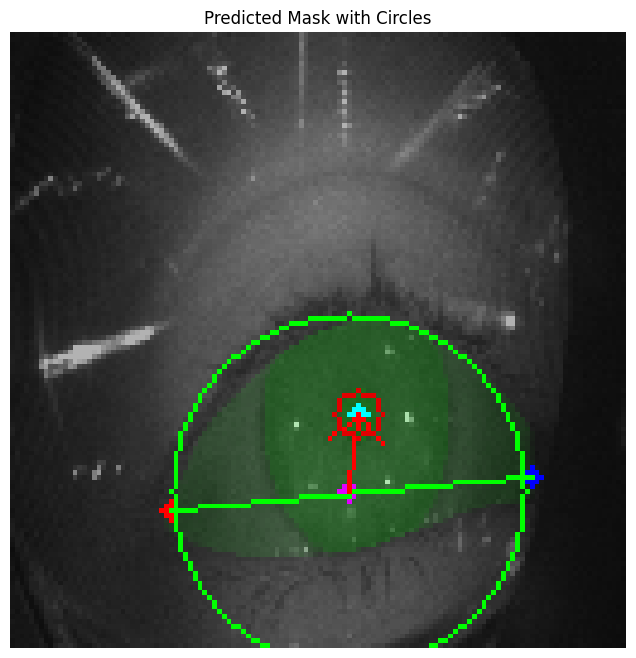

Time taken: 104.78173828125 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(90))
Distance between Leftmost and Middle Point: 37
Error processing 23.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(91))


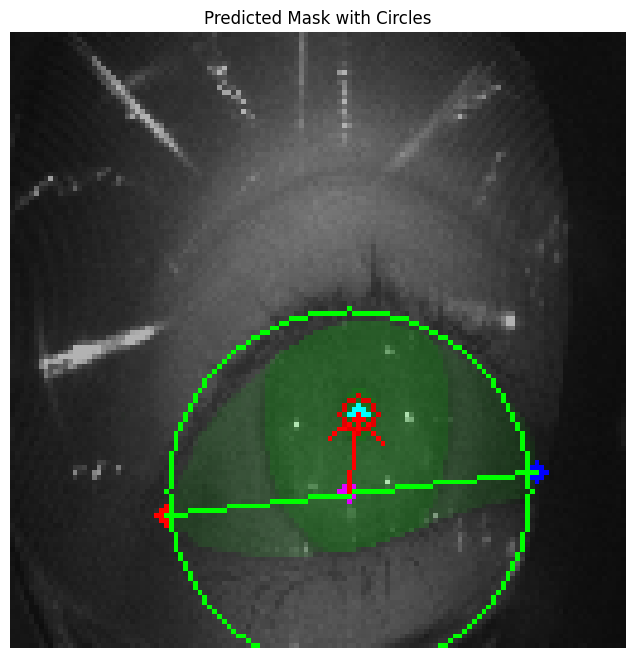

Time taken: 53.103759765625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 24.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(95))


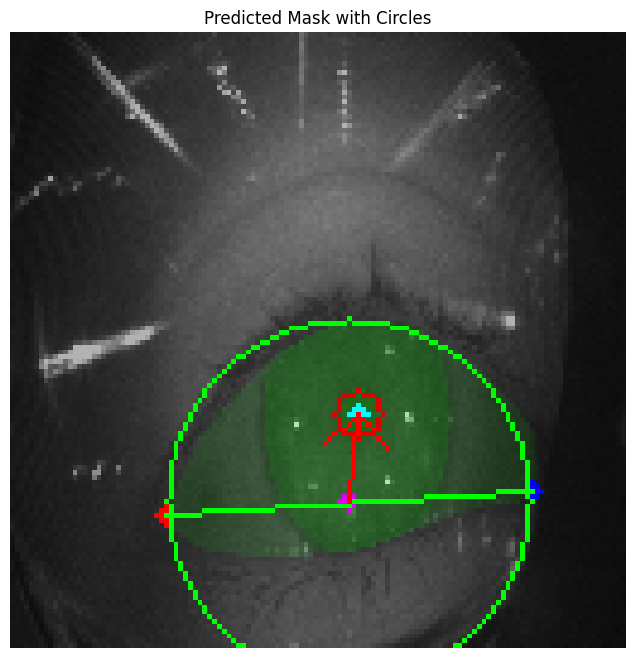

Time taken: 50.622314453125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 25.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(96))


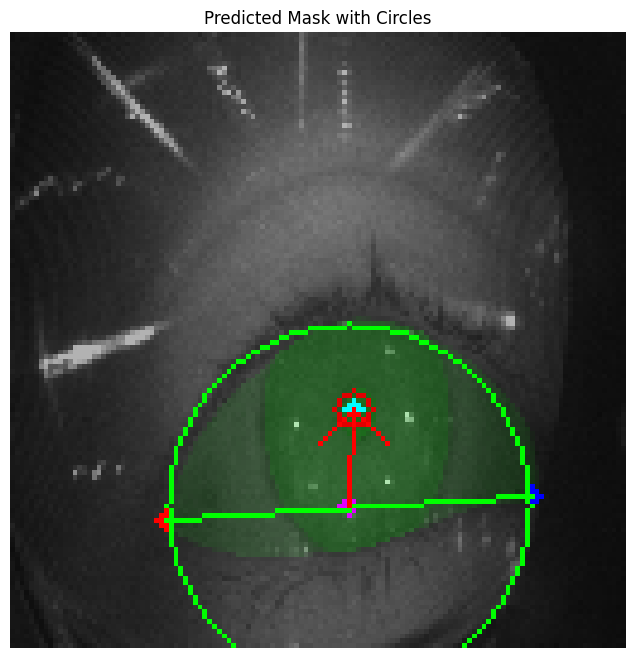

Time taken: 57.68701171875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 26.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(92))


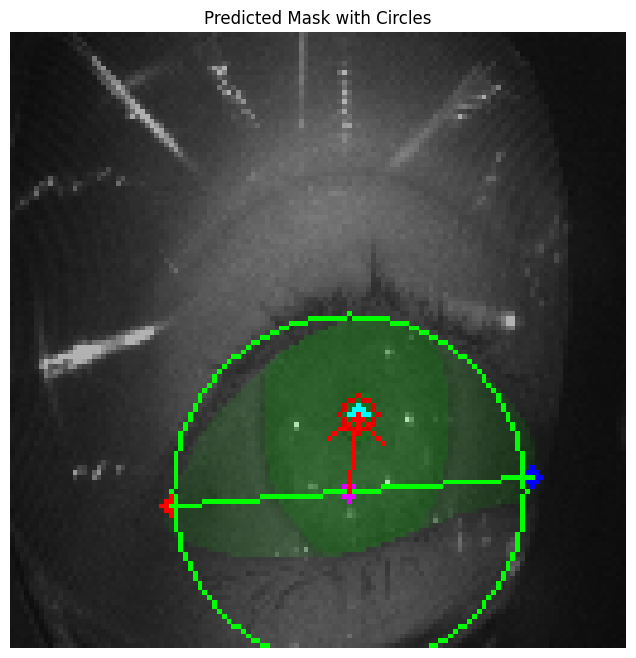

Time taken: 49.24169921875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 38
Error processing 27.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(93))


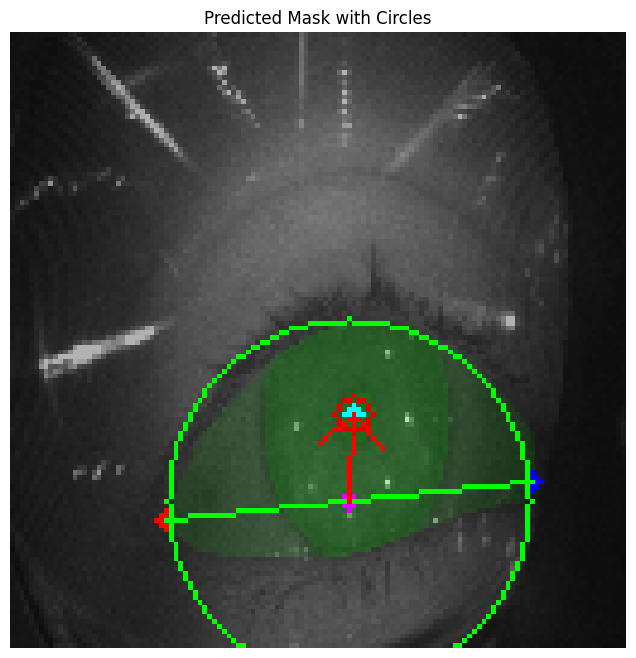

Time taken: 53.614013671875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 28.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(90))


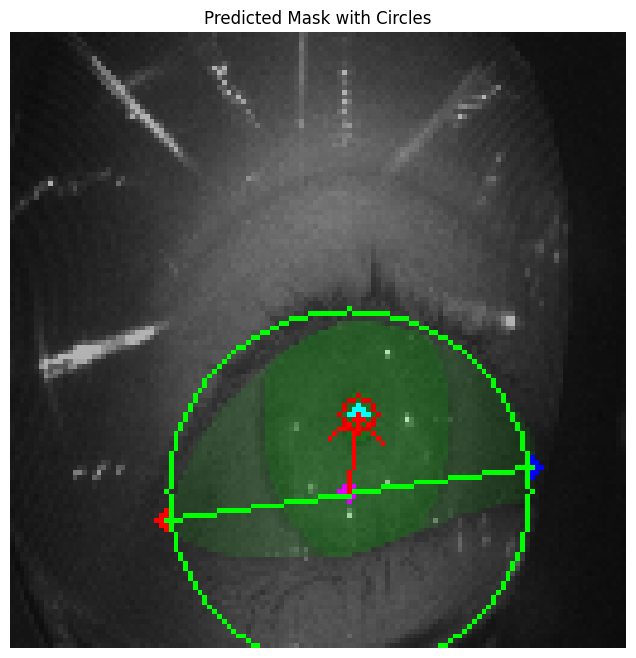

Time taken: 53.248779296875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 29.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(92))


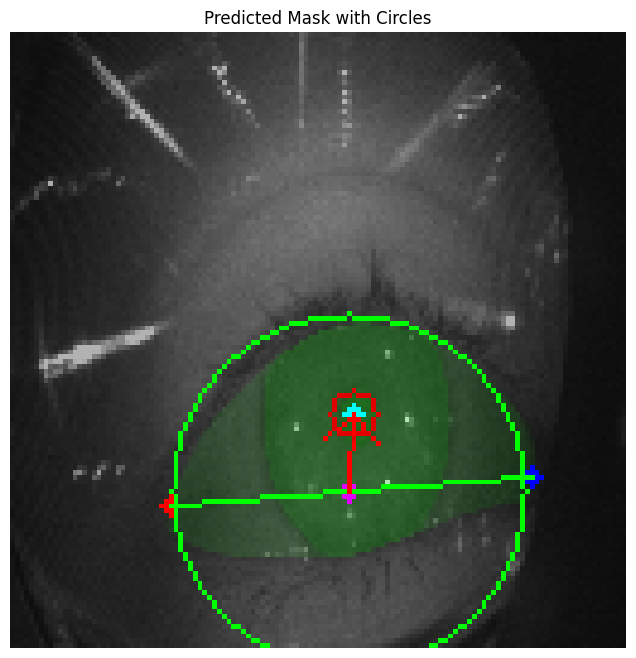

Time taken: 61.180419921875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 3.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
No iris contours found.
Error processing 3.png: cannot unpack non-iterable NoneType object
Error processing 30.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
No iris contours found.
Error processing 30.png: cannot unpack non-iterable NoneType object
Error processing 31.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(86))


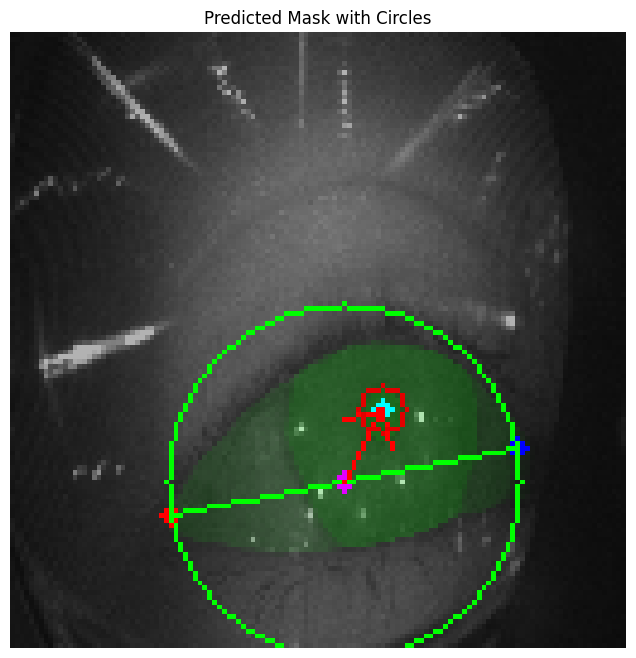

Time taken: 55.3212890625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(85))
Distance between Leftmost and Middle Point: 37
Error processing 32.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(90))


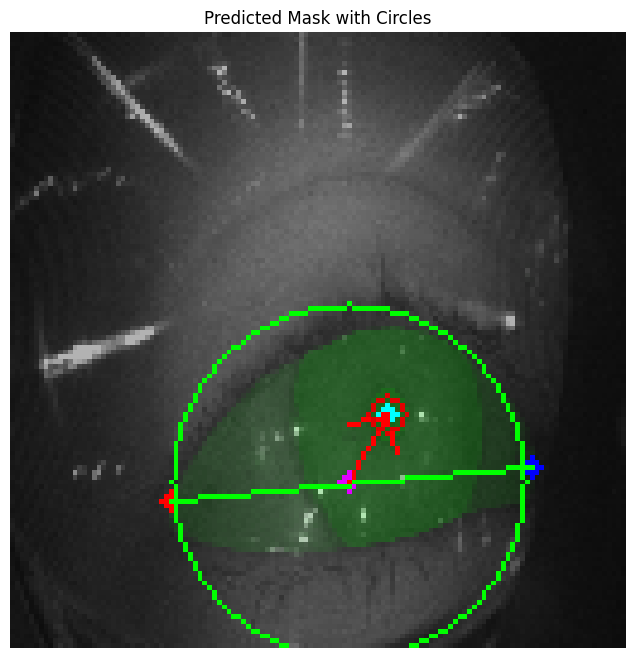

Time taken: 88.85595703125 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 37
Error processing 33.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(106), np.int32(96))


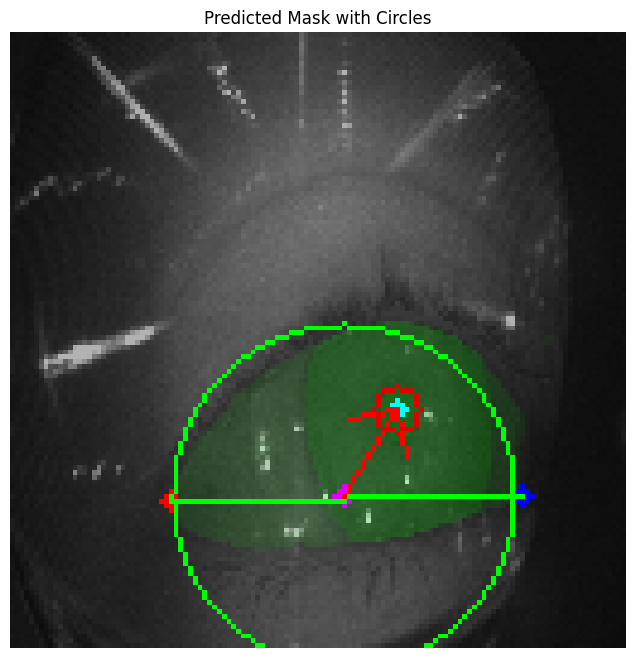

Time taken: 49.339111328125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(106), np.int32(95))
Distance between Leftmost and Middle Point: 36
Error processing 34.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(107), np.int32(92))


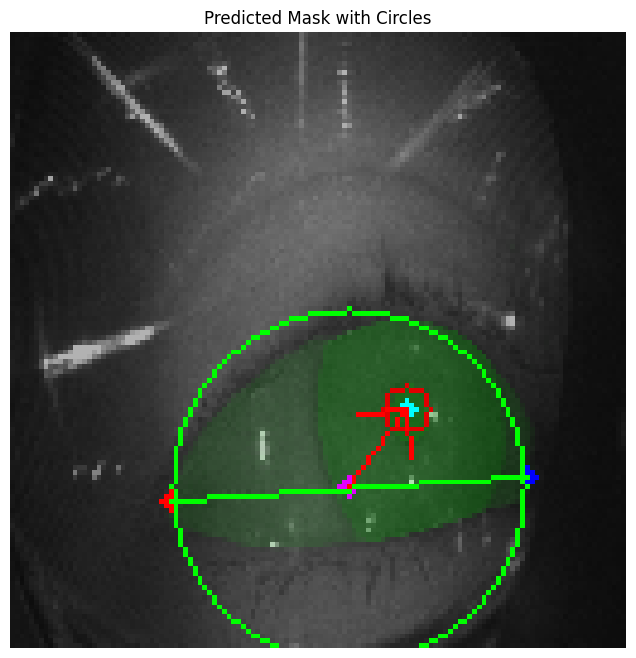

Time taken: 127.178955078125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(107), np.int32(89))
Distance between Leftmost and Middle Point: 37
Error processing 35.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(90))


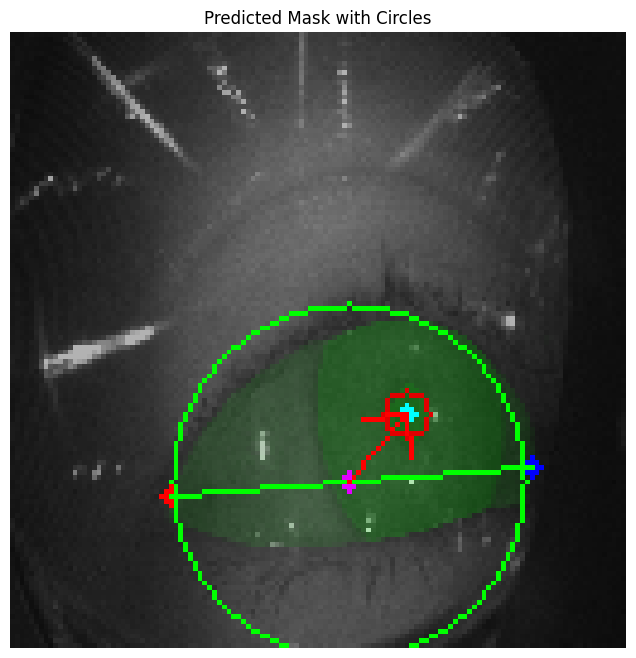

Time taken: 126.50927734375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 36.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(90))


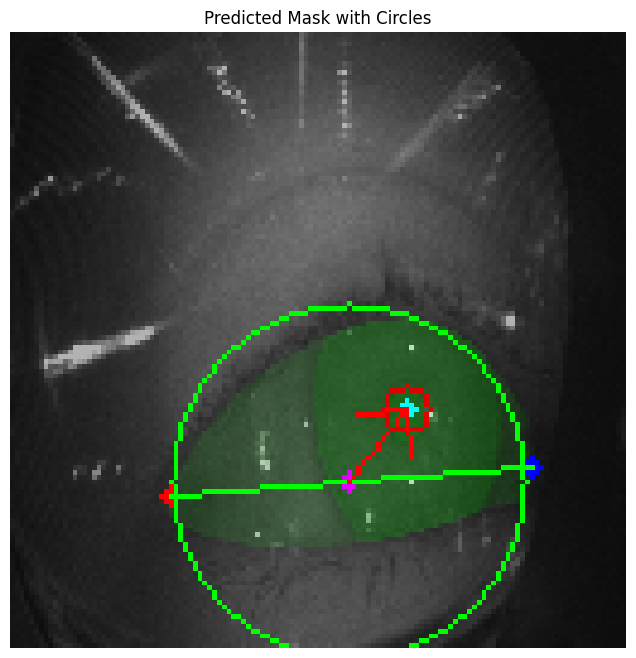

Time taken: 50.392578125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 37.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(91))


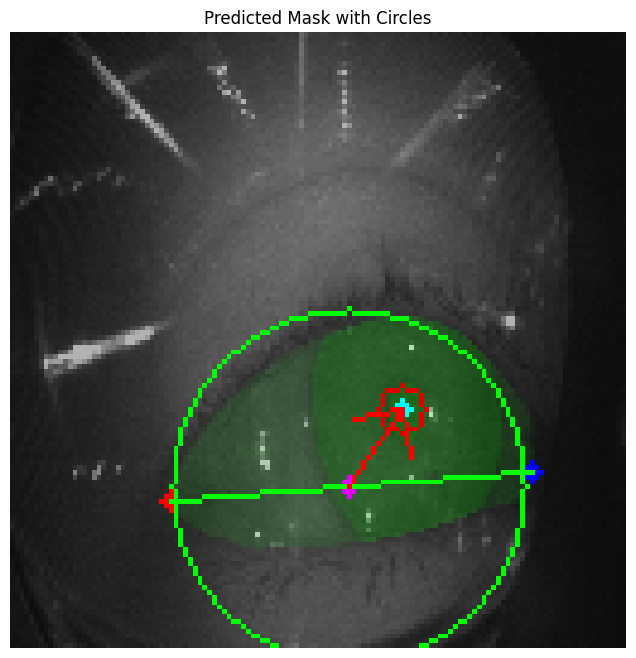

Time taken: 71.08251953125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 38.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(92))


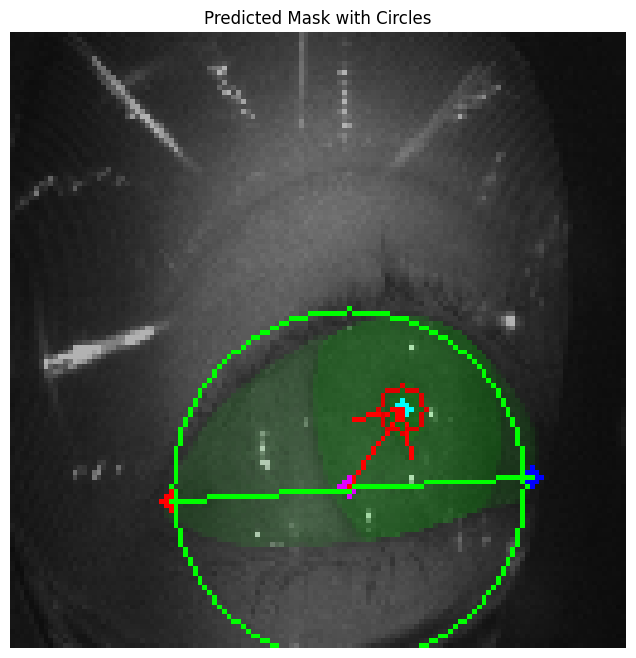

Time taken: 55.807373046875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(109), np.int32(91))
Distance between Leftmost and Middle Point: 38
Error processing 39.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(91))


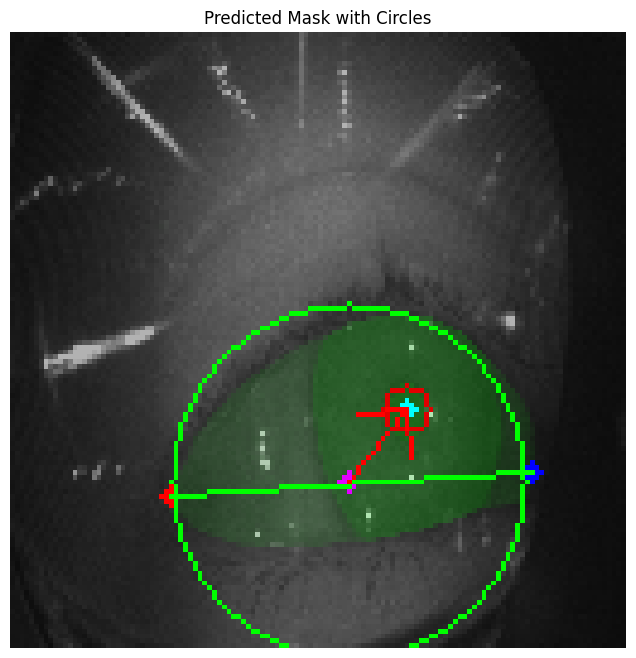

Time taken: 110.047607421875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 4.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(92))


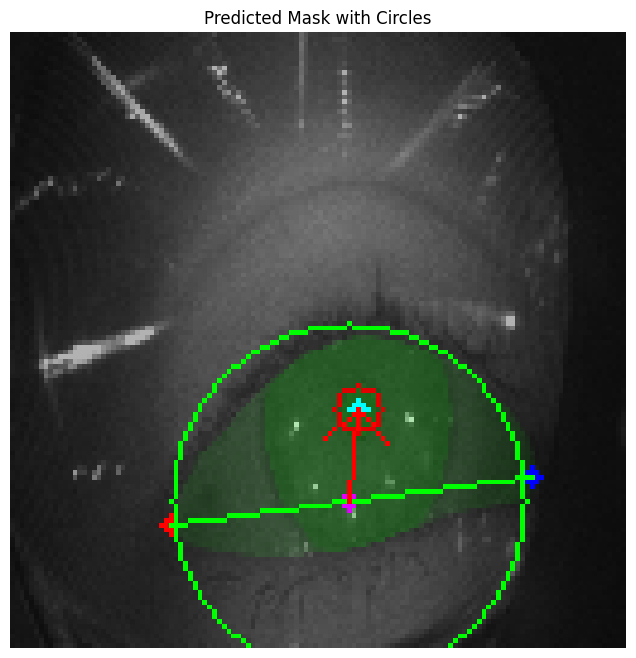

Time taken: 136.009521484375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 37
Error processing 40.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(91))


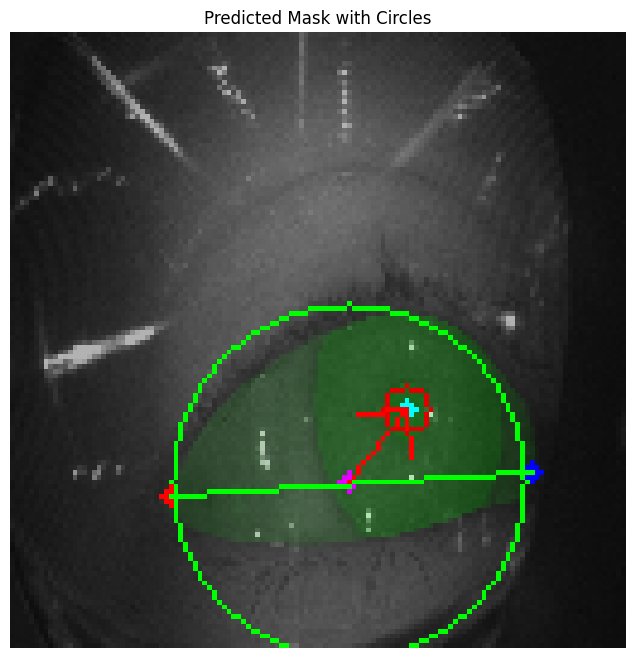

Time taken: 47.8173828125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 37
Error processing 41.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(87))


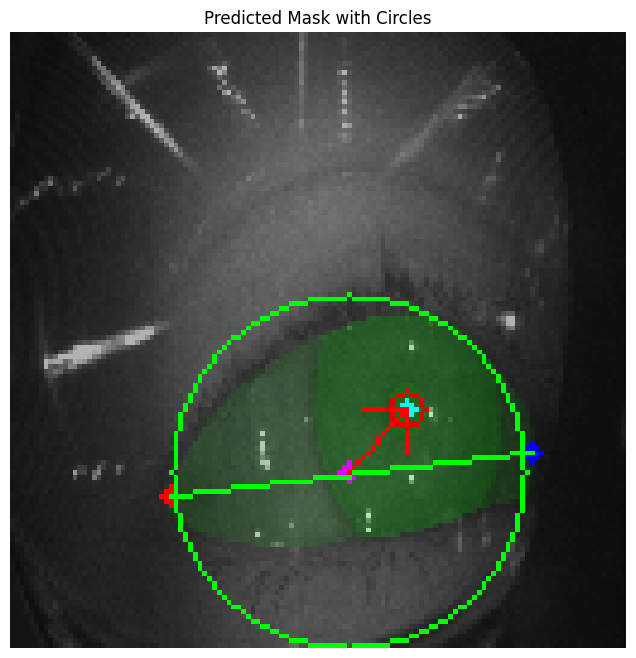

Time taken: 57.552490234375 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(94))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 37
Error processing 42.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(87))


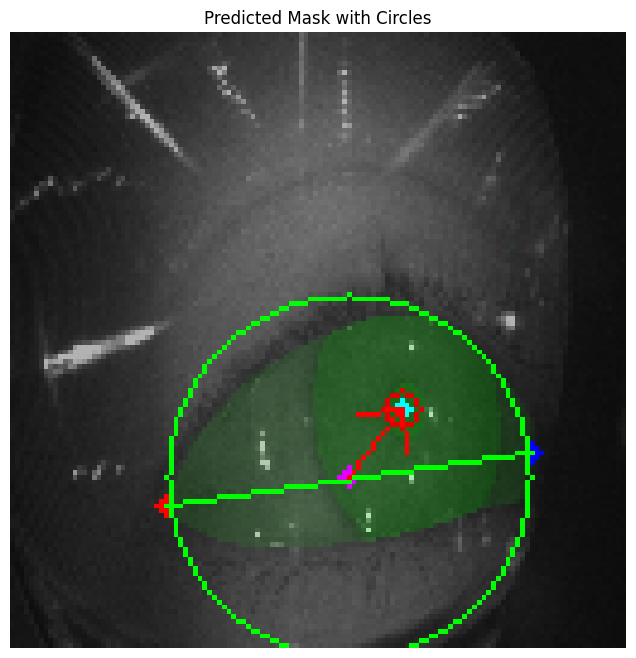

Time taken: 46.941162109375 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 43.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(91))


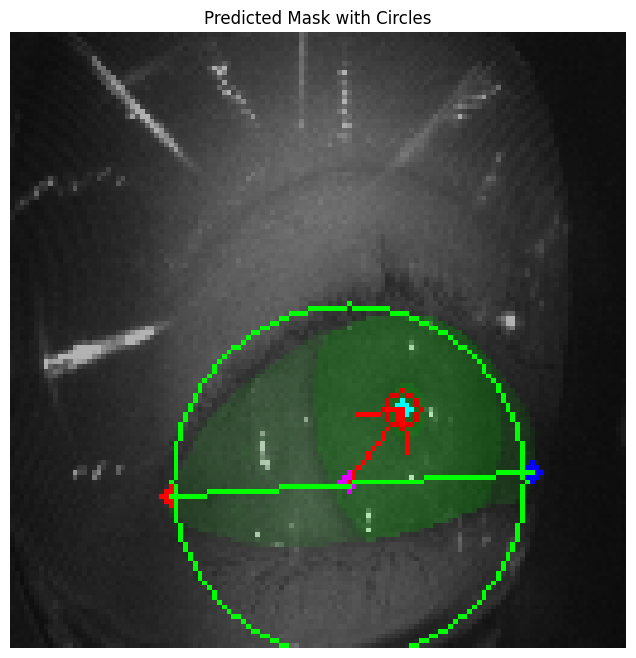

Time taken: 125.718017578125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 44.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(91))


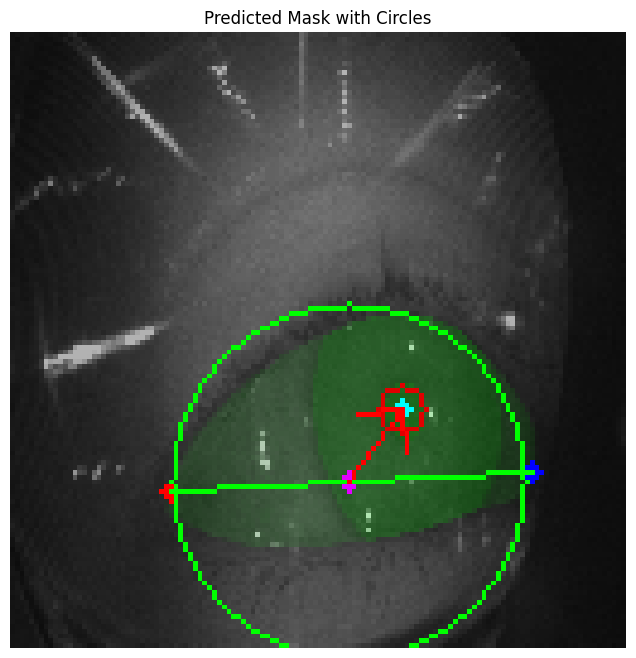

Time taken: 127.1083984375 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(84))
Distance between Leftmost and Middle Point: 39
Error processing 45.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(90))


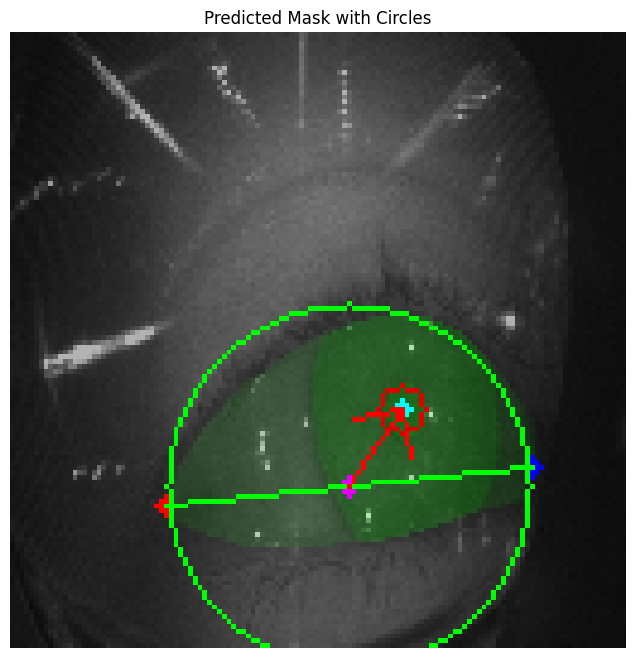

Time taken: 74.1630859375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(107), np.int32(93))
Distance between Leftmost and Middle Point: 37
Error processing 46.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(90))


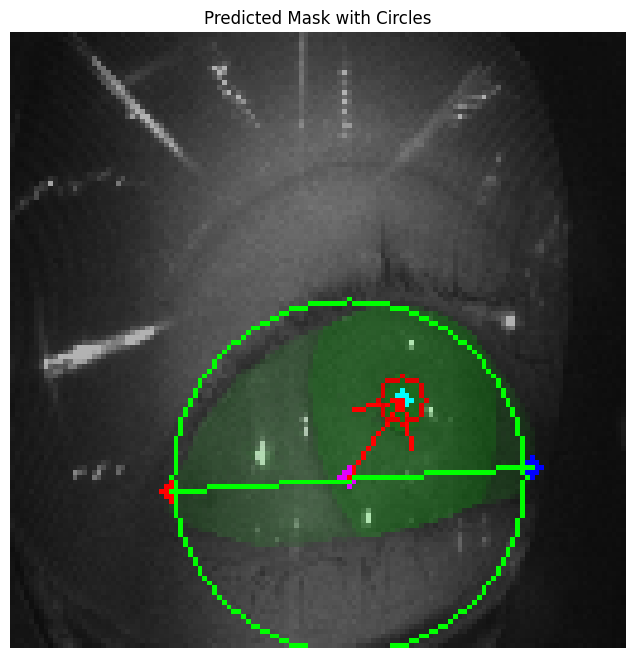

Time taken: 93.697998046875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 47.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(94))
Rightmost Point: (np.int32(109), np.int32(91))


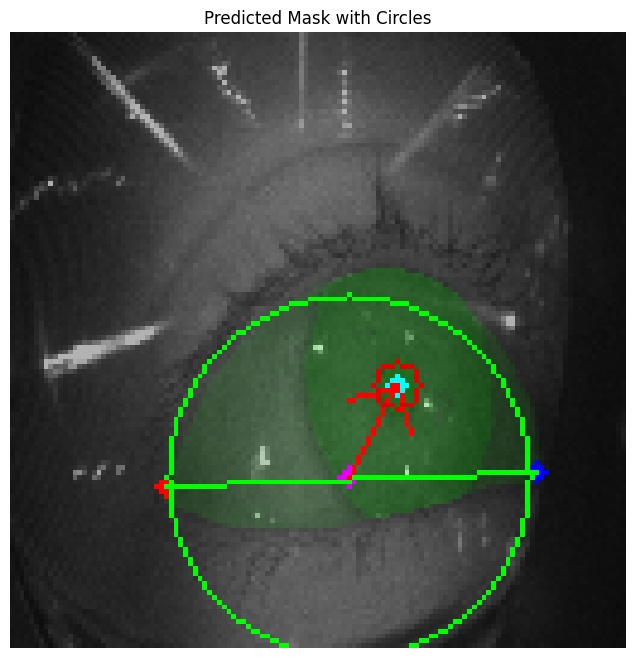

Time taken: 64.06689453125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(96))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 39
Error processing 48.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(89))


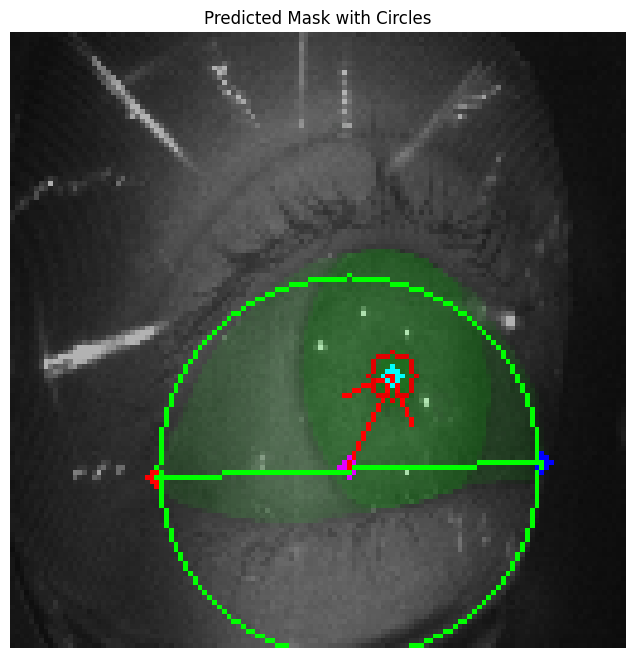

Time taken: 61.903564453125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 40
Error processing 49.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(91))
Rightmost Point: (np.int32(110), np.int32(90))


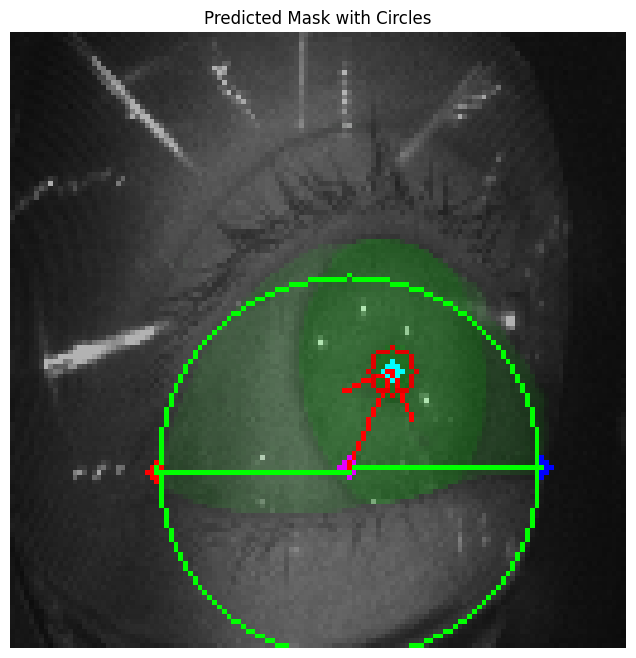

Time taken: 109.44580078125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(90))
Distance between Leftmost and Middle Point: 40
Error processing 5.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(93))


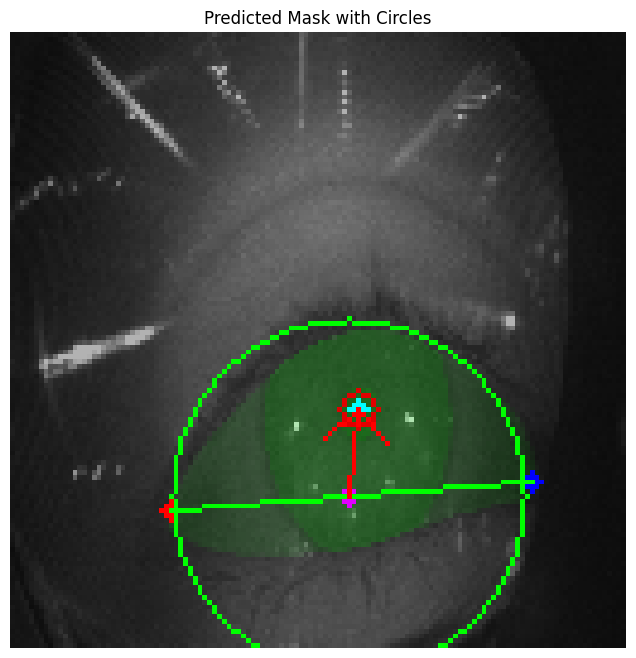

Time taken: 64.708740234375 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 50.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(90))


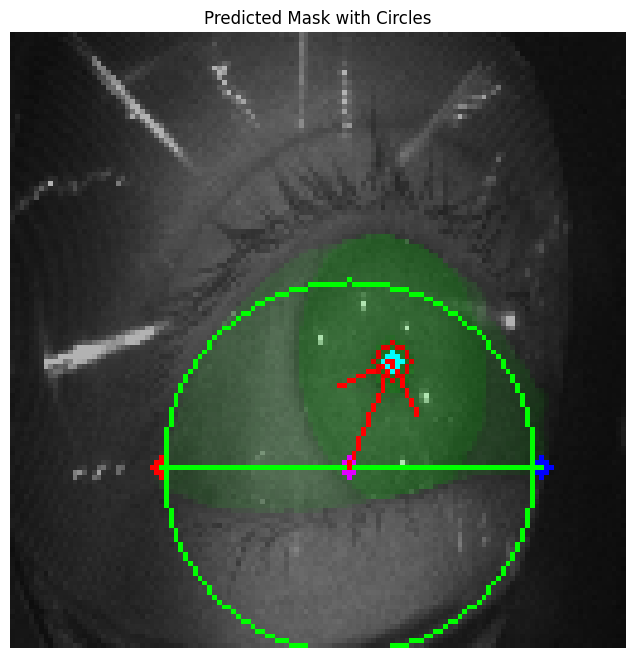

Time taken: 416.9462890625 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(90))
Distance between Leftmost and Middle Point: 40
Error processing 51.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))


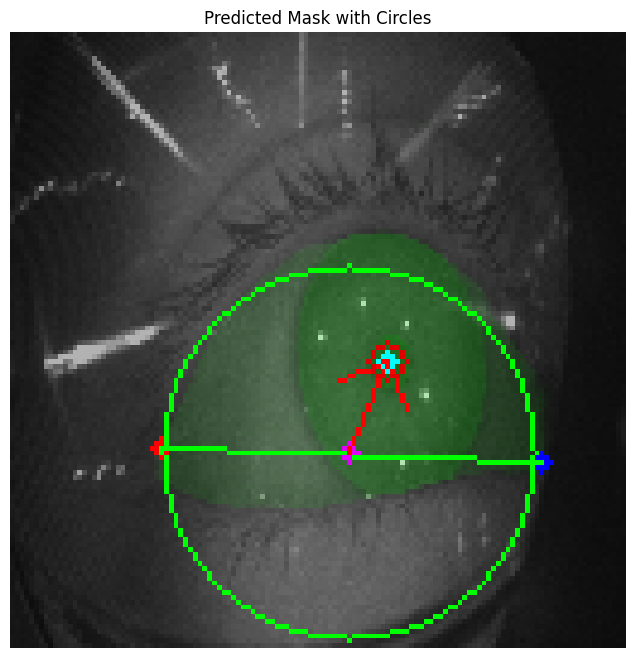

Time taken: 118.255615234375 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 52.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(78))


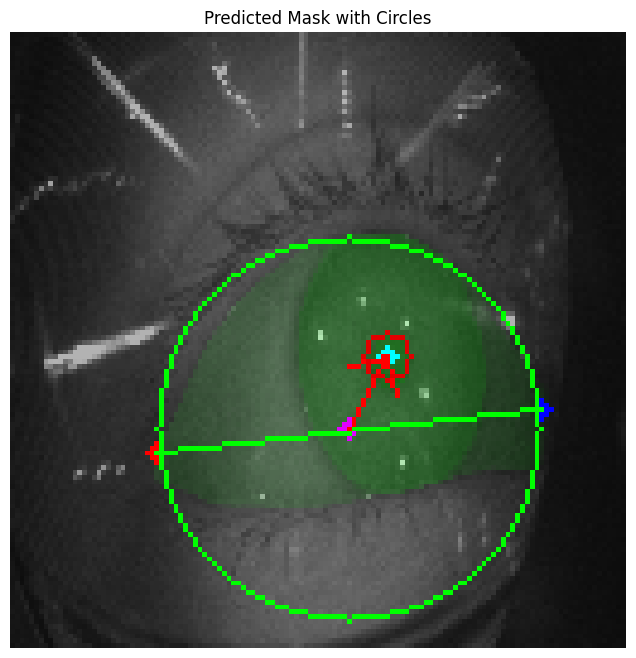

Time taken: 53.34814453125 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 53.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(88))


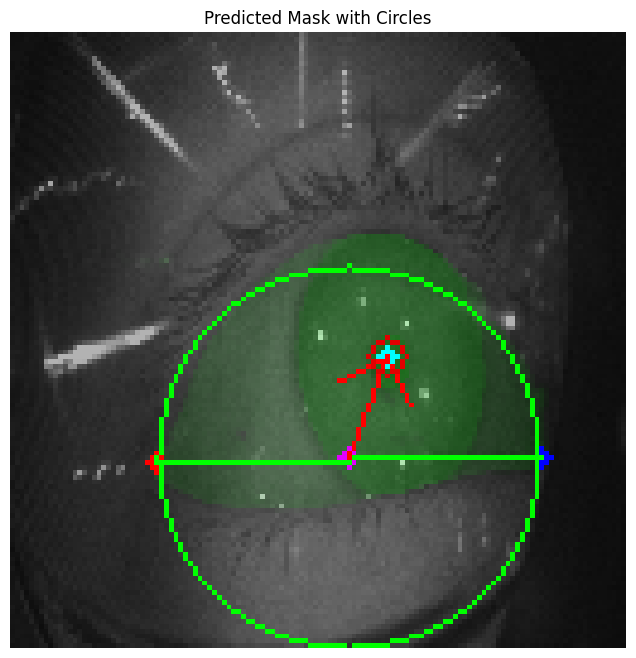

Time taken: 111.338623046875 ms
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(86))
Rightmost Point: (np.int32(111), np.int32(77))
Distance between Leftmost and Middle Point: 41
Error processing 54.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(89))


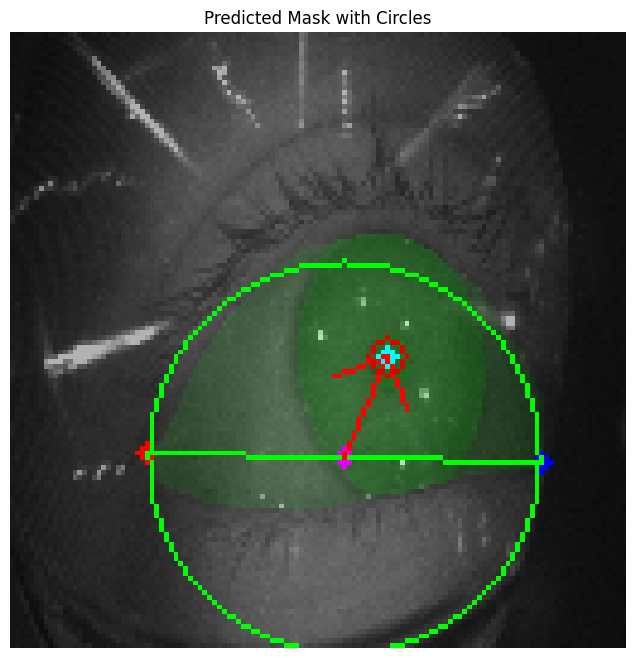

Time taken: 66.650634765625 ms
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(78))
Distance between Leftmost and Middle Point: 41
Error processing 55.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(88))


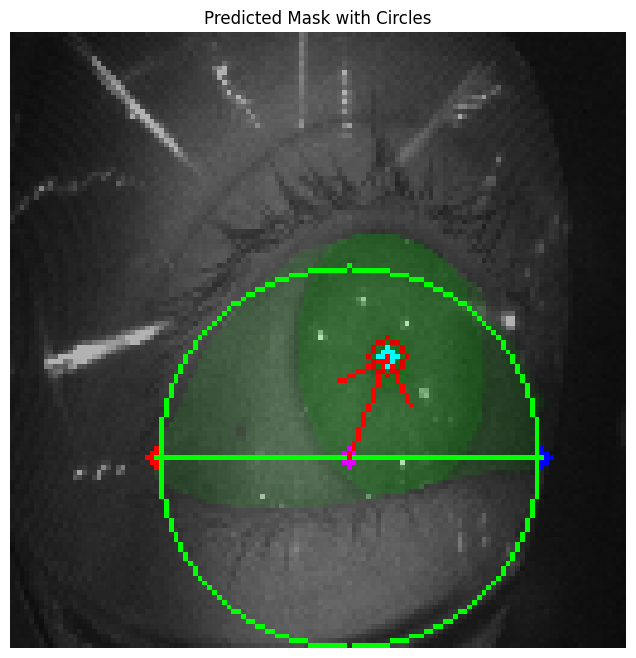

Time taken: 73.412353515625 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 56.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(89))


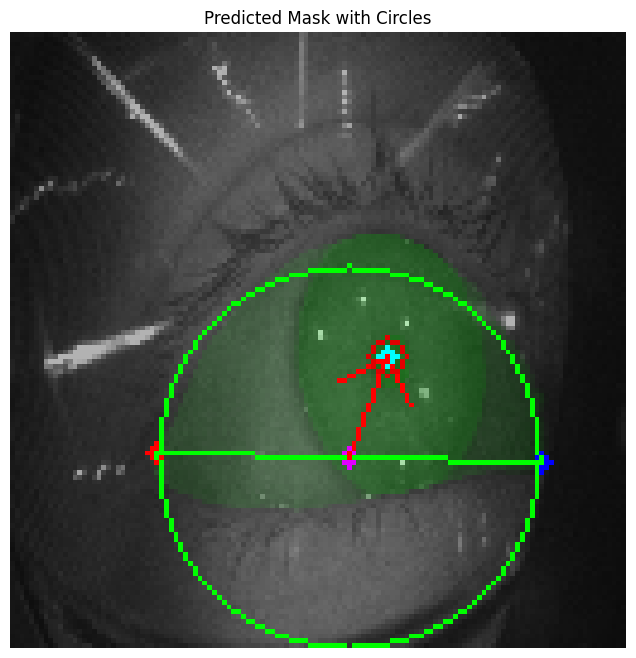

Time taken: 70.227783203125 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 57.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(76))


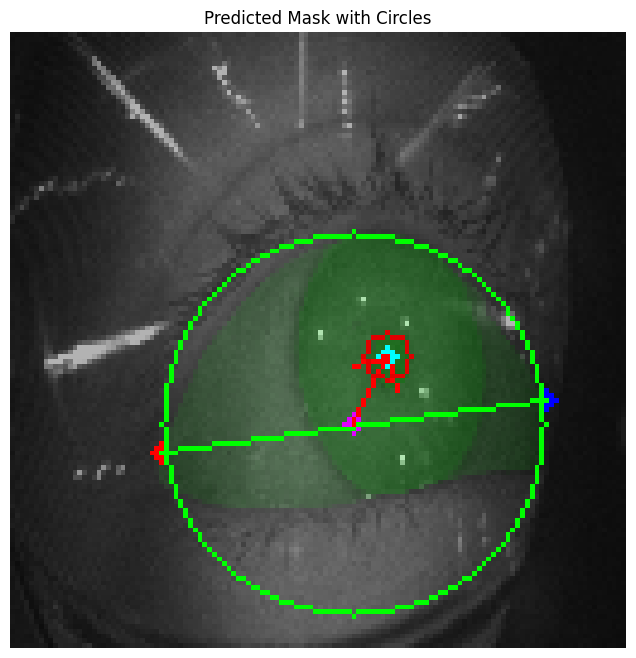

Time taken: 129.064453125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(89))
Rightmost Point: (np.int32(109), np.int32(90))
Distance between Leftmost and Middle Point: 39
Error processing 58.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(77))


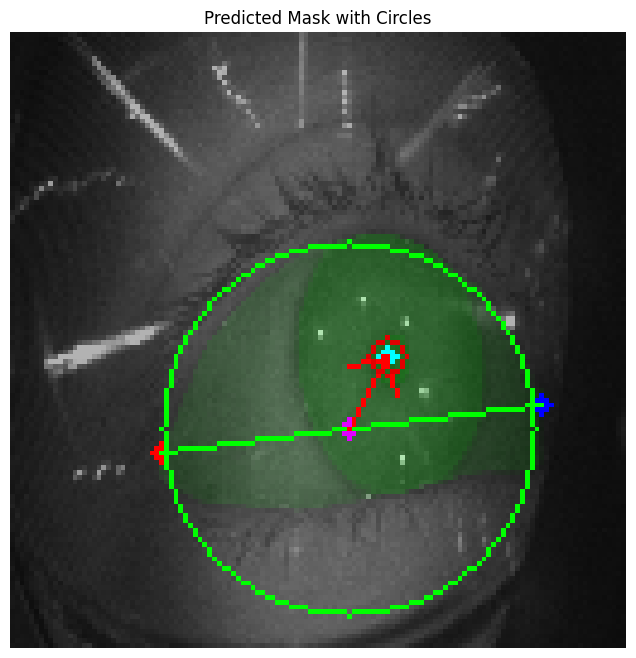

Time taken: 55.95458984375 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(84))
Distance between Leftmost and Middle Point: 39
Error processing 59.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(91))
Rightmost Point: (np.int32(110), np.int32(89))


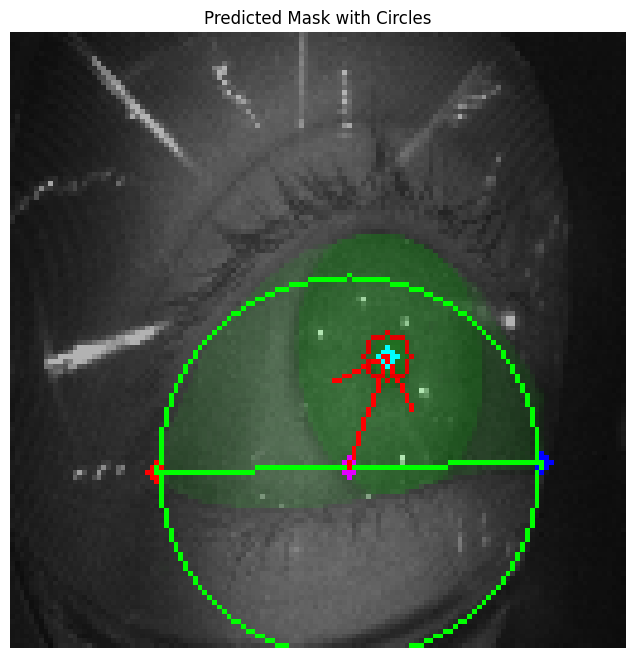

Time taken: 70.268798828125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 6.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))


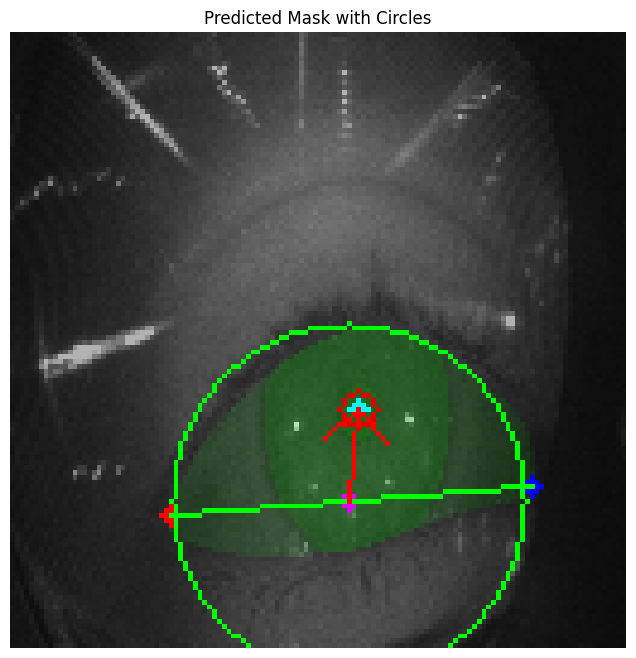

Time taken: 105.041259765625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 60.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(84))
Rightmost Point: (np.int32(110), np.int32(87))


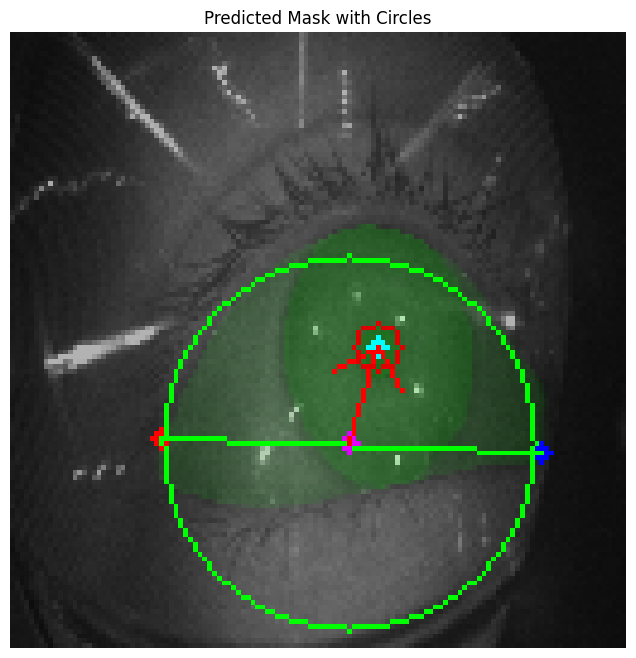

Time taken: 113.484130859375 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(80))
Distance between Leftmost and Middle Point: 40
Error processing 61.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(88))


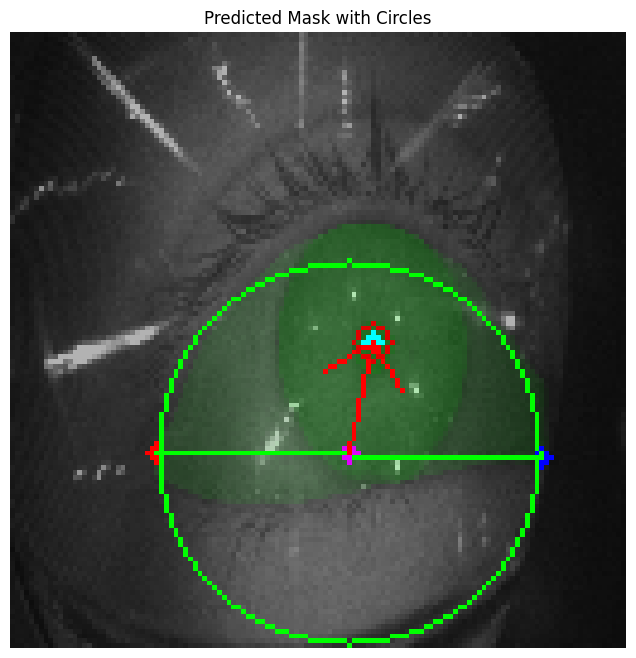

Time taken: 63.491943359375 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(86))
Rightmost Point: (np.int32(111), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 62.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(78))


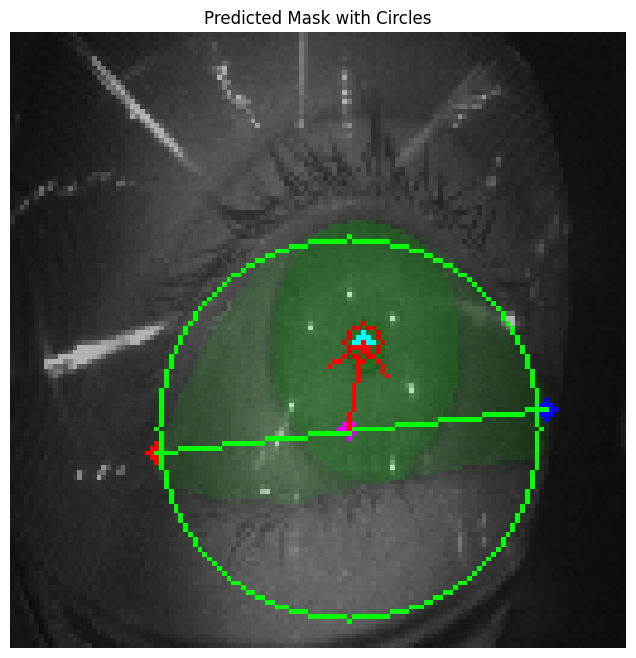

Time taken: 64.1689453125 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 63.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(77))


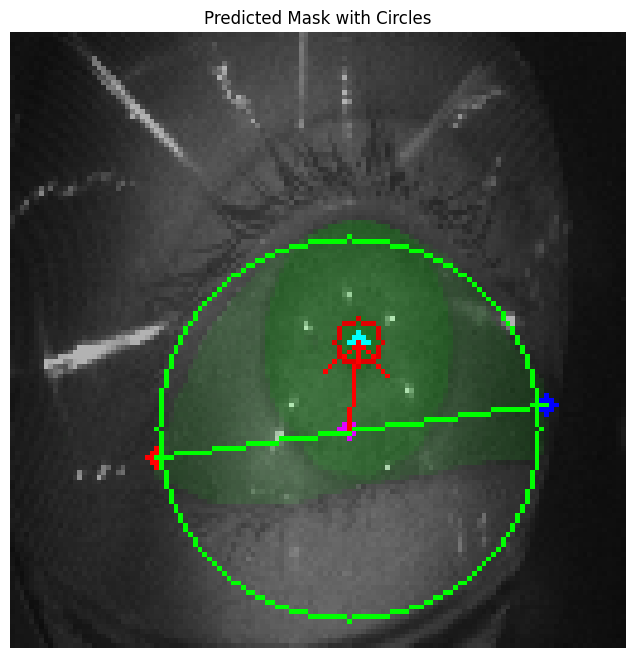

Time taken: 125.315673828125 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 39
Error processing 64.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(87))


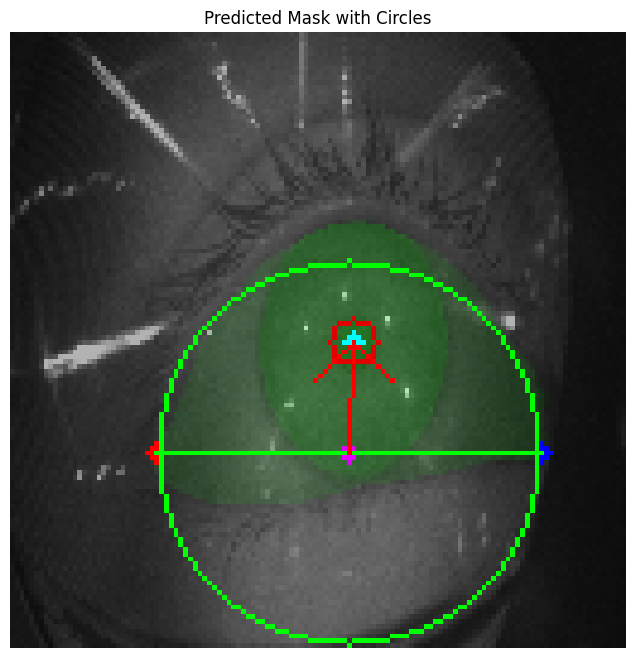

Time taken: 54.74365234375 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 65.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(87))


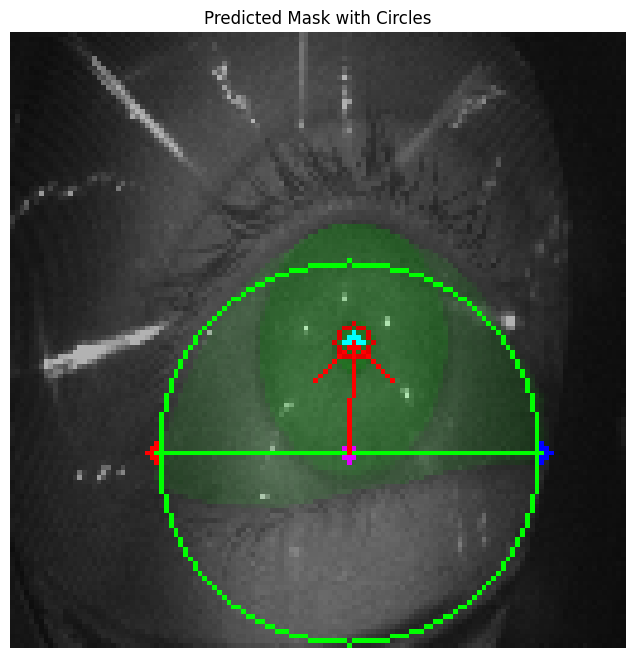

Time taken: 108.7724609375 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(88))
Distance between Leftmost and Middle Point: 39
Error processing 66.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(86))


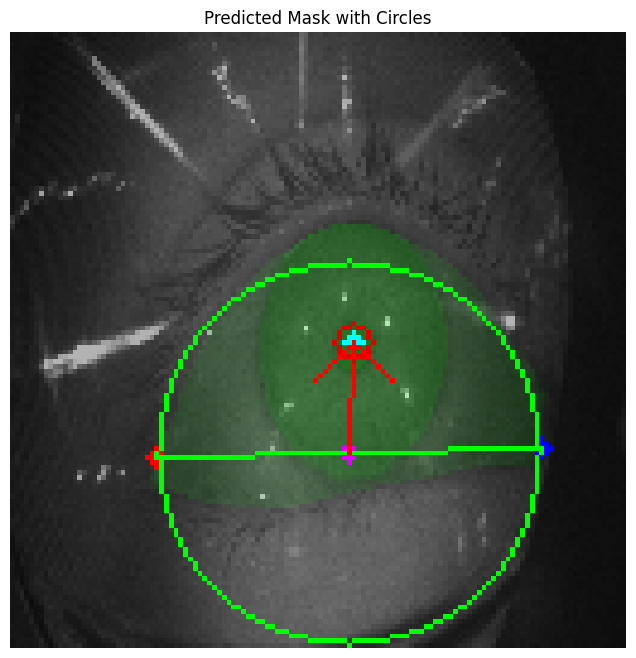

Time taken: 46.677490234375 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 67.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(78))


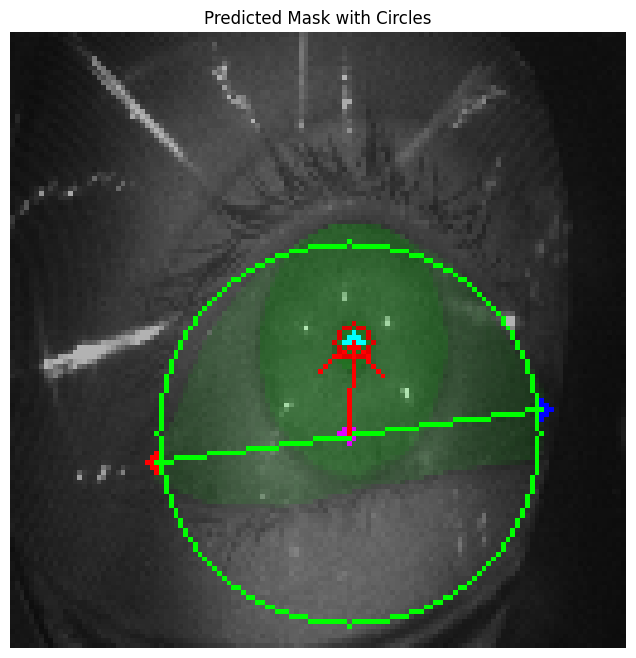

Time taken: 129.870361328125 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 68.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(87))


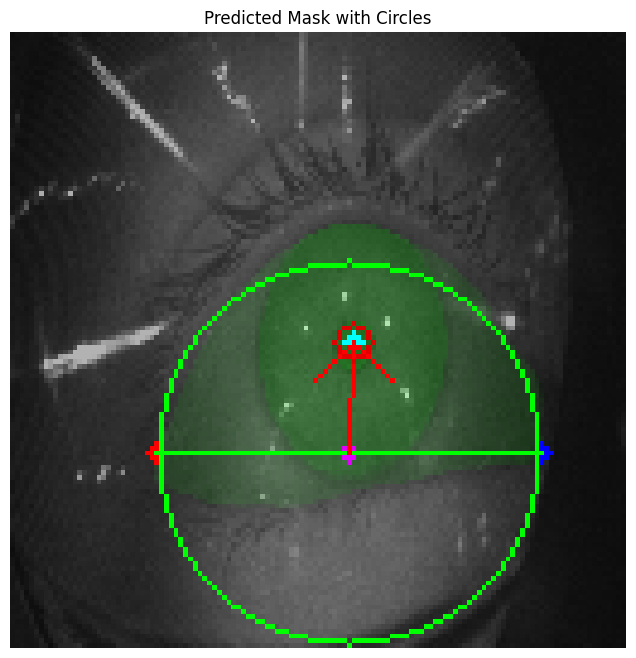

Time taken: 82.357666015625 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 69.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(87))


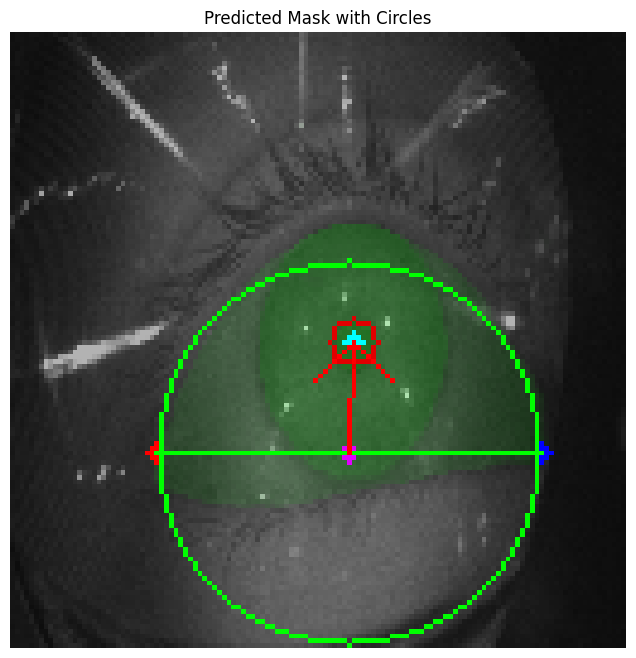

Time taken: 73.536865234375 ms
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(86))
Distance between Leftmost and Middle Point: 41
Error processing 7.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(90))


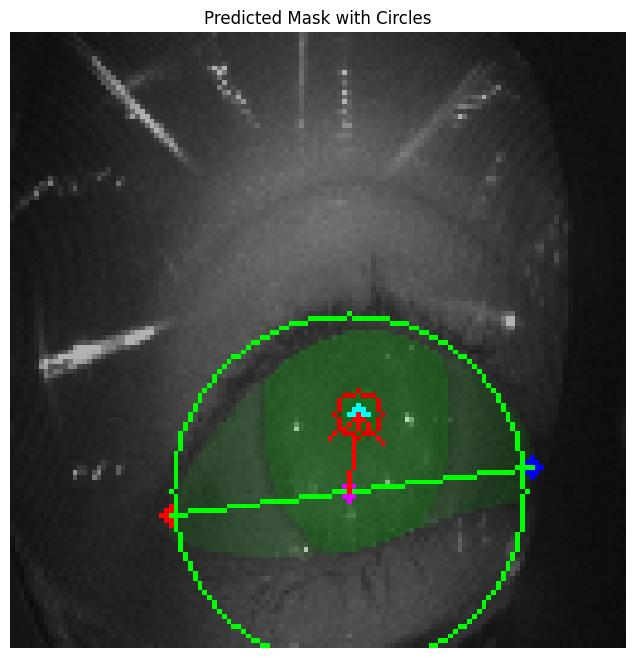

Time taken: 125.306396484375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 70.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(86))


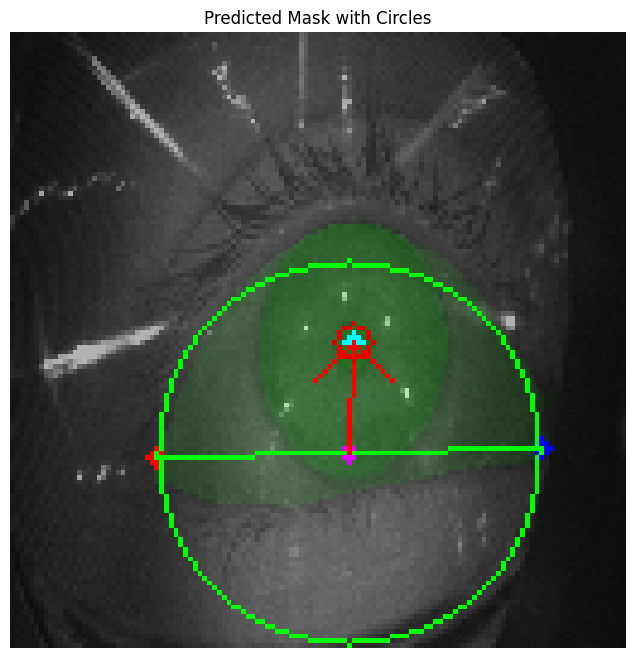

Time taken: 56.2099609375 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 71.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(80))


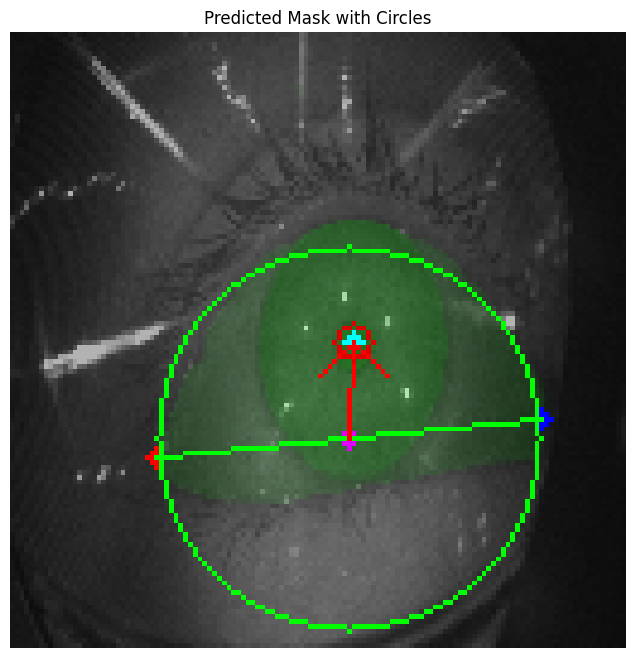

Time taken: 120.02880859375 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(85))
Rightmost Point: (np.int32(110), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 72.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(86))


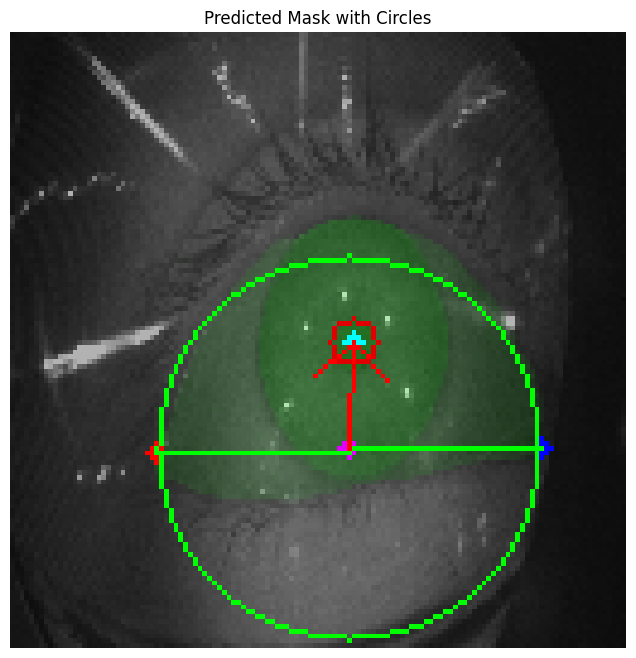

Time taken: 57.36328125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 39
Error processing 73.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(85))


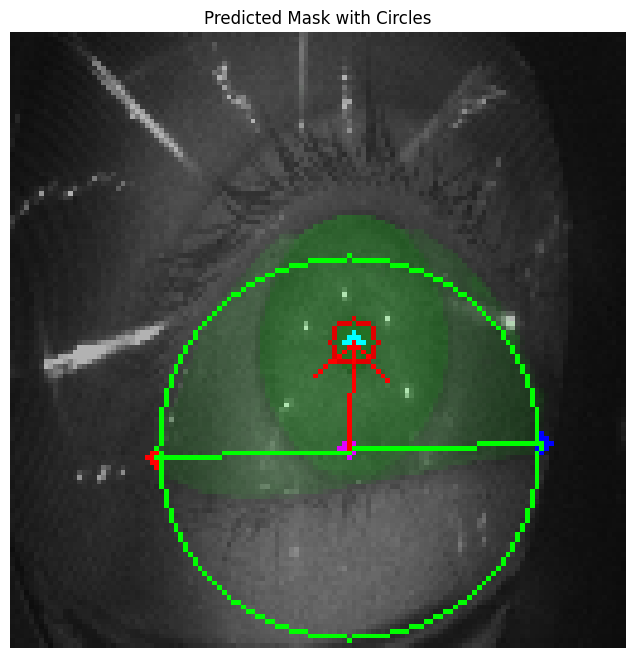

Time taken: 46.1171875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 74.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
No iris contours found.
Error processing 74.png: cannot unpack non-iterable NoneType object
Error processing 75.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(87))


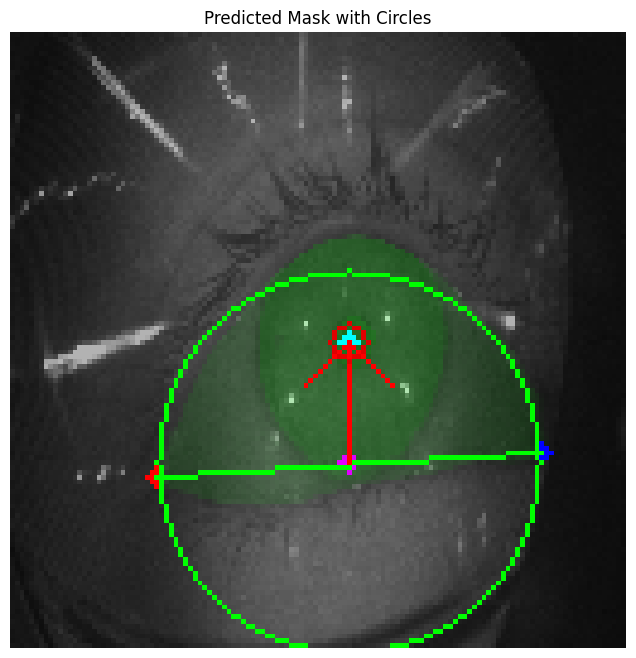

Time taken: 57.0009765625 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 76.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(86))


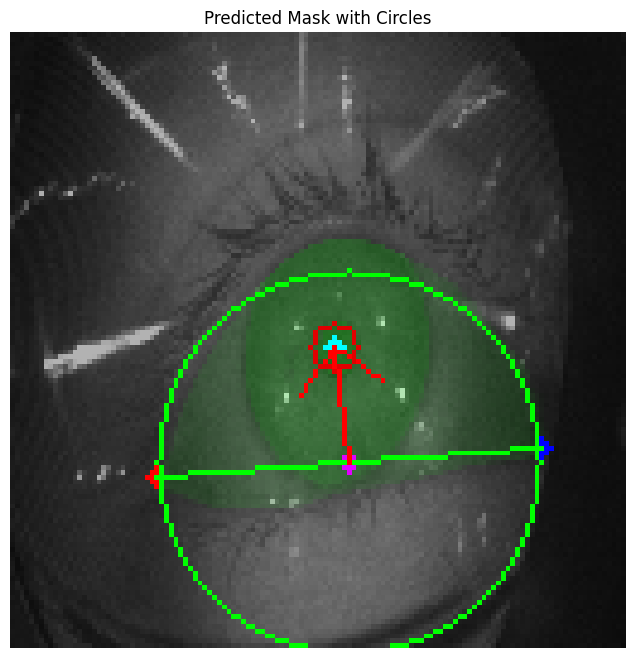

Time taken: 51.276123046875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(109), np.int32(86))
Distance between Leftmost and Middle Point: 39
Error processing 77.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(86))


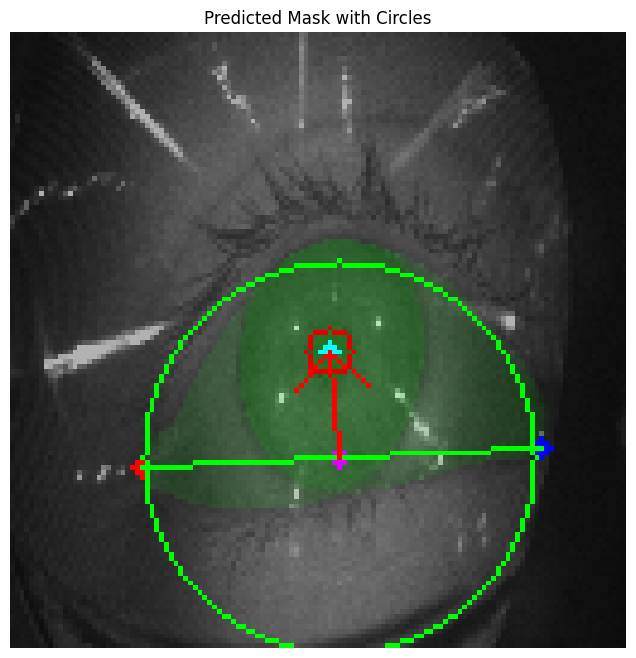

Time taken: 92.739013671875 ms
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(85))
Distance between Leftmost and Middle Point: 41
Error processing 78.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(91))
Rightmost Point: (np.int32(110), np.int32(85))


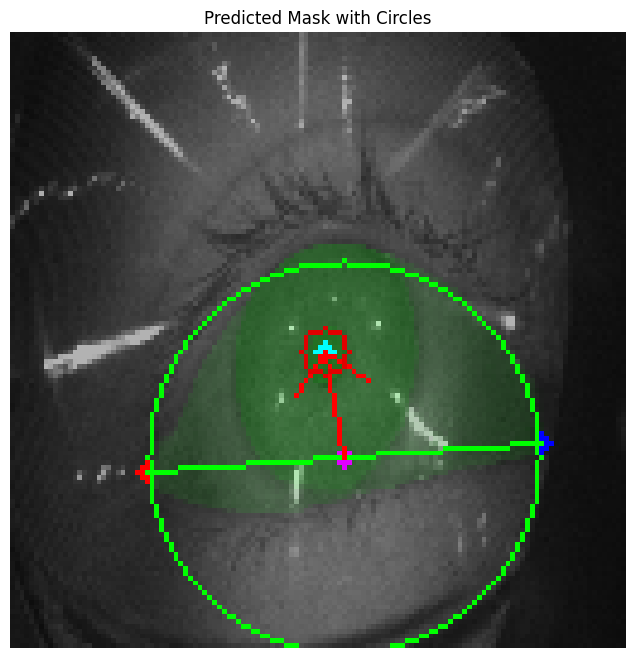

Time taken: 112.68701171875 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(90))
Rightmost Point: (np.int32(109), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 79.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(91))
Rightmost Point: (np.int32(110), np.int32(85))


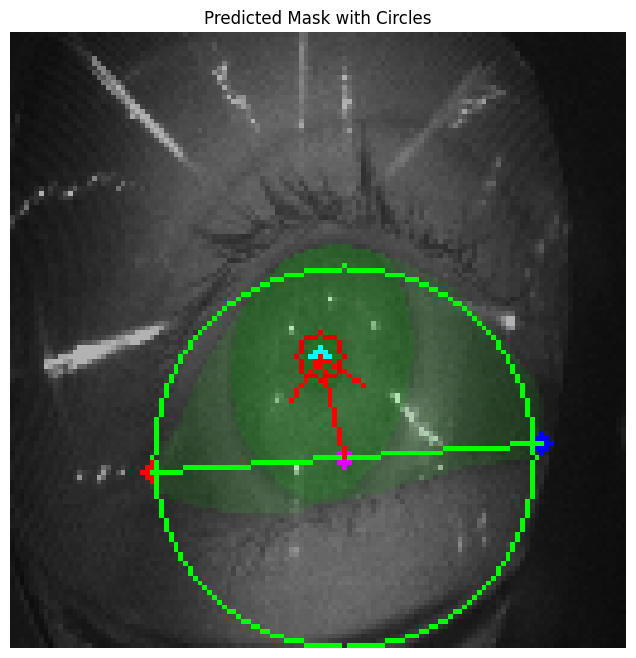

Time taken: 68.48974609375 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(77))
Distance between Leftmost and Middle Point: 42
Error processing 8.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(92))


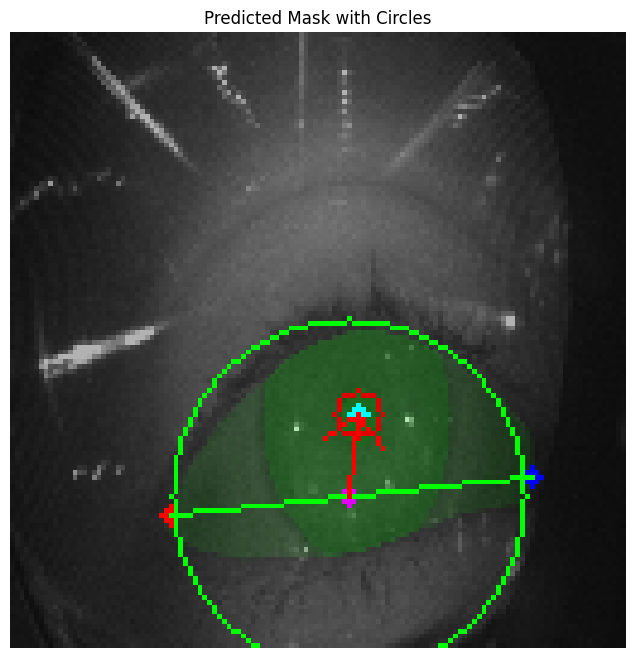

Time taken: 76.97314453125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 80.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


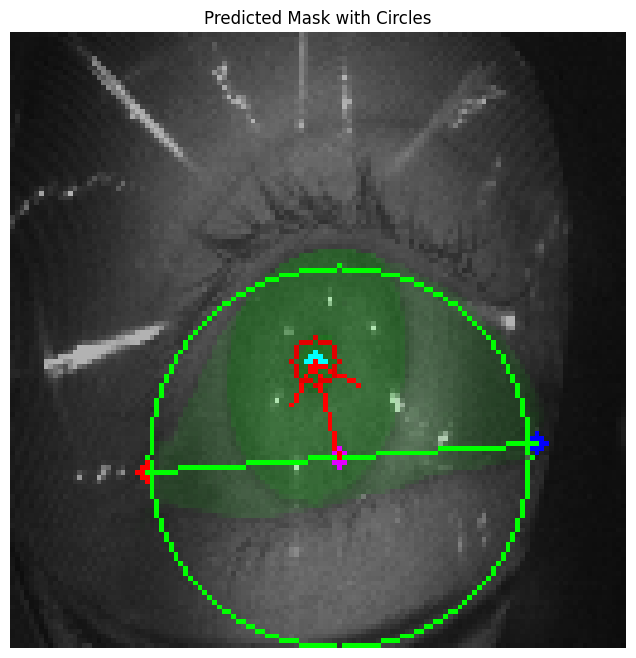

Time taken: 73.70654296875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(94))
Rightmost Point: (np.int32(109), np.int32(81))
Distance between Leftmost and Middle Point: 40
Error processing 81.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(86))


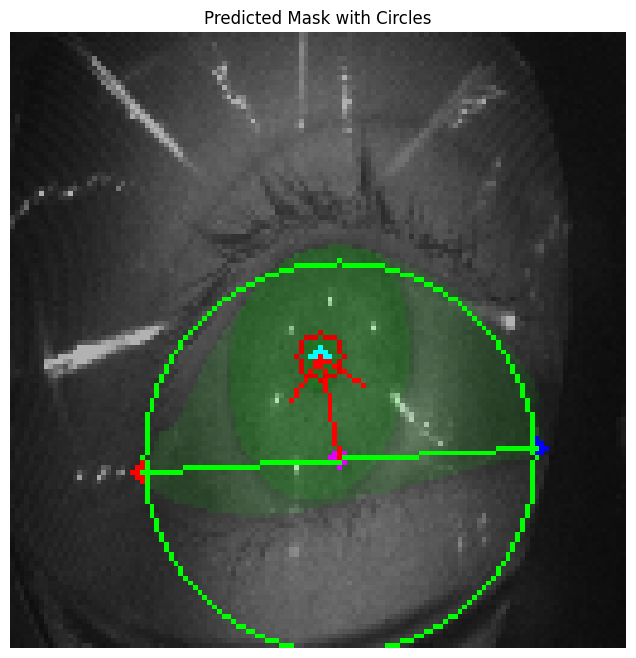

Time taken: 115.359375 ms
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(89))
Rightmost Point: (np.int32(107), np.int32(86))
Distance between Leftmost and Middle Point: 39
Error processing 82.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


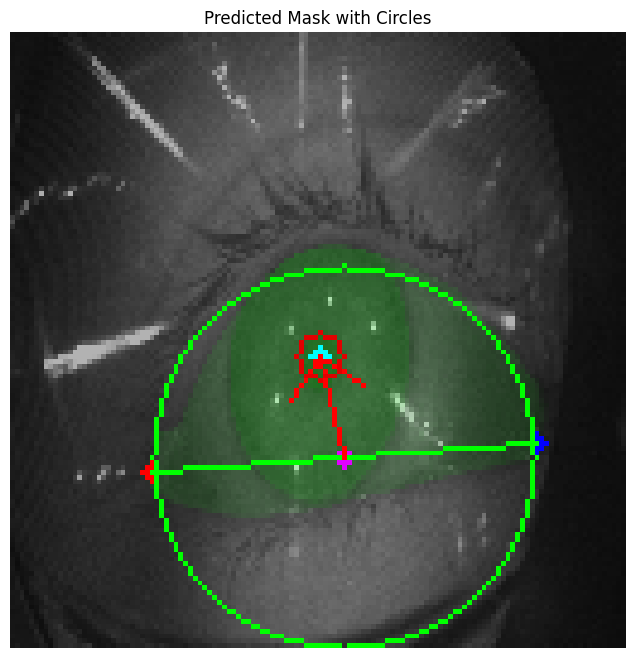

Time taken: 69.427490234375 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(93))
Rightmost Point: (np.int32(109), np.int32(77))
Distance between Leftmost and Middle Point: 41
Error processing 83.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(109), np.int32(85))


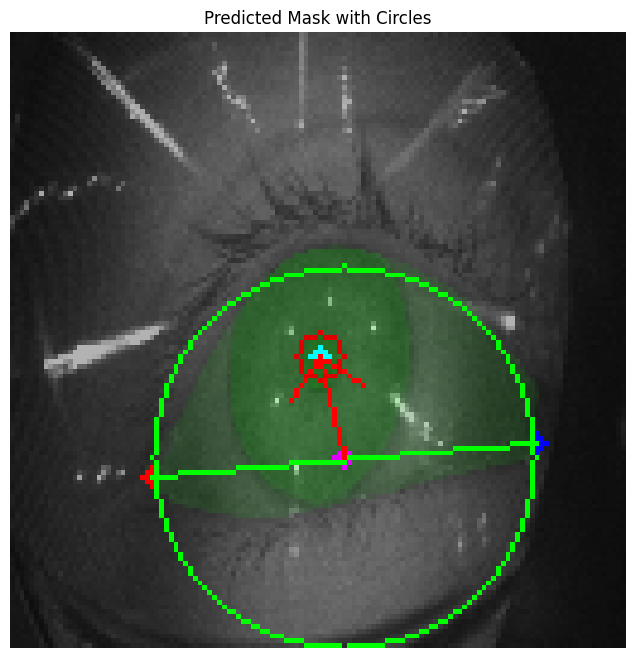

Time taken: 73.63623046875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(109), np.int32(78))
Distance between Leftmost and Middle Point: 40
Error processing 84.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(88))


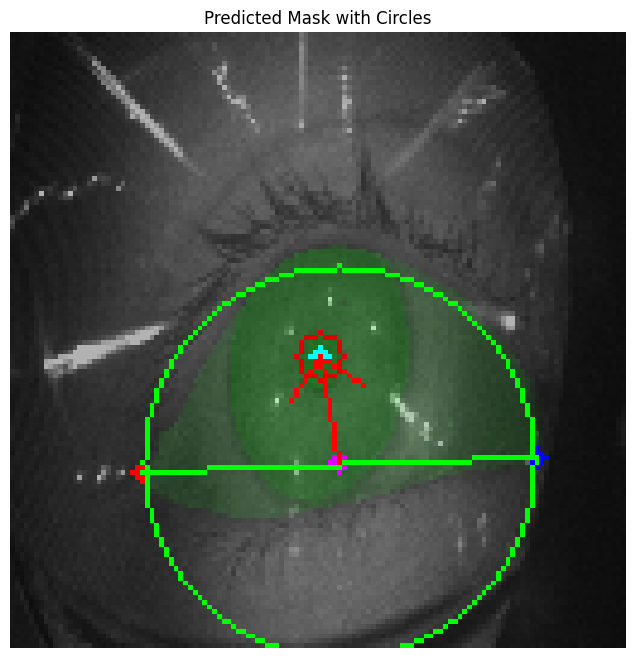

Time taken: 133.58837890625 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 39
Error processing 85.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


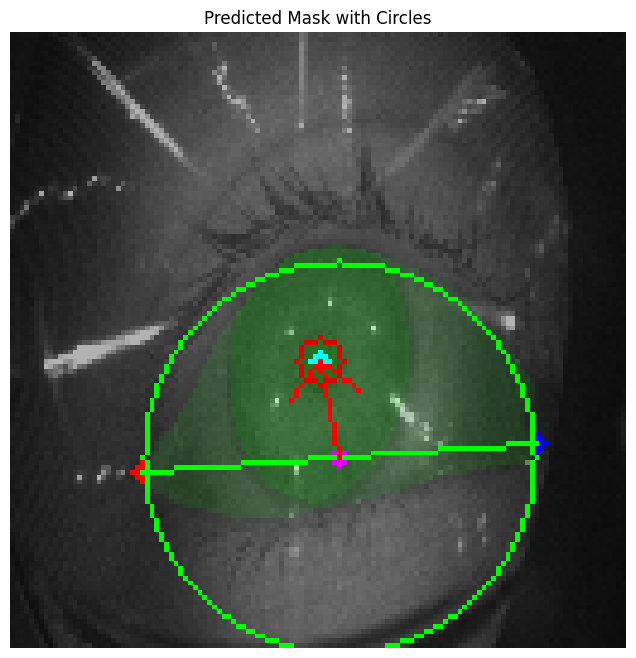

Time taken: 80.384765625 ms
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(90))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 86.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


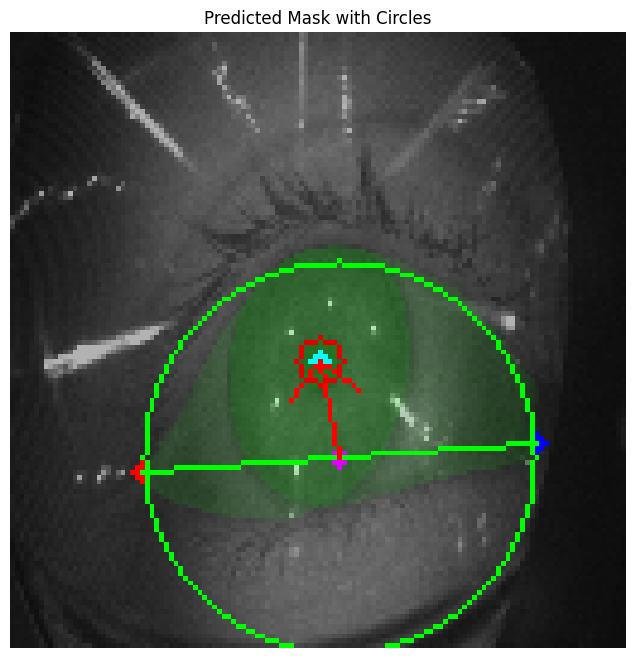

Time taken: 70.961669921875 ms
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(90))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 87.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


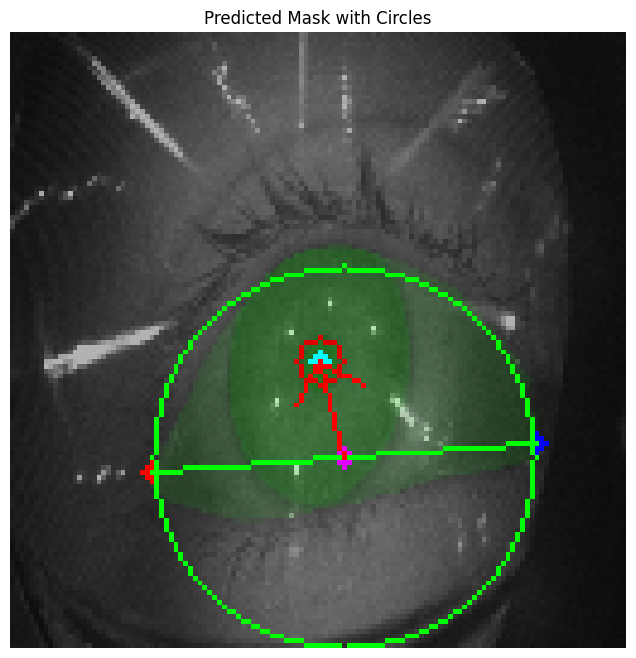

Time taken: 78.914794921875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 39
Error processing 88.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


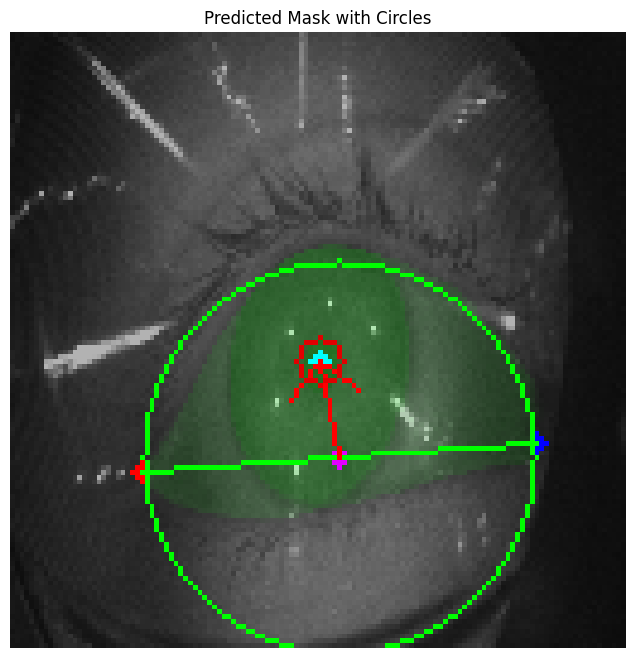

Time taken: 76.580078125 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(78))
Distance between Leftmost and Middle Point: 42
Error processing 89.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(90))
Rightmost Point: (np.int32(109), np.int32(85))


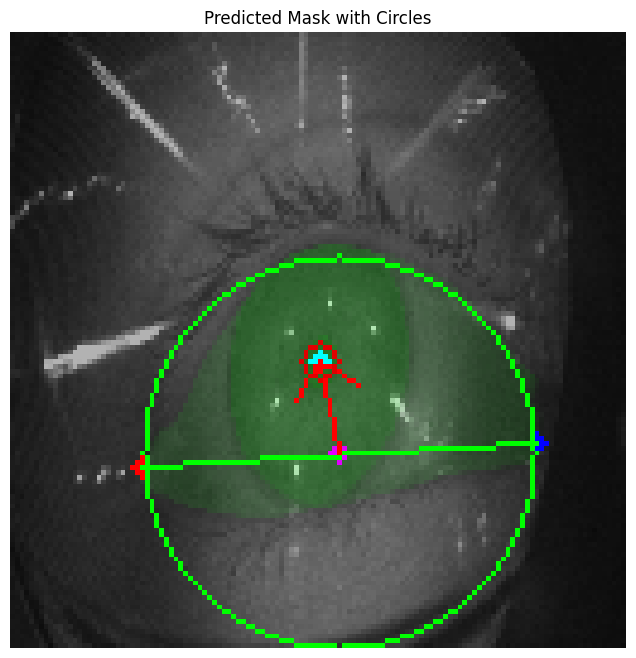

Time taken: 75.125244140625 ms
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 9.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(94))


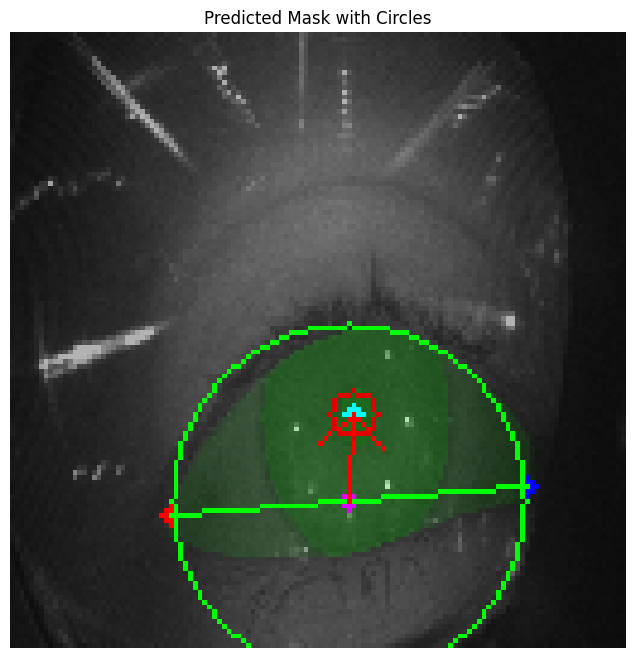

Time taken: 109.4697265625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 37
Error processing 90.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(90))
Rightmost Point: (np.int32(108), np.int32(85))


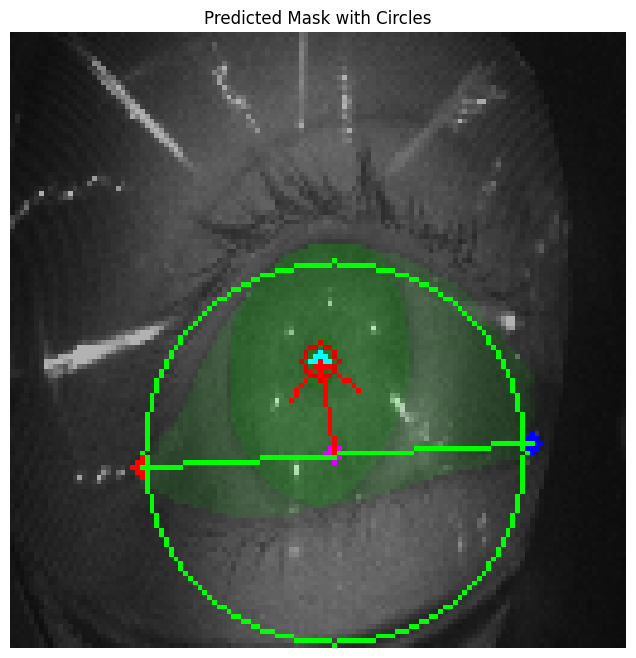

Time taken: 84.796630859375 ms
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(92))
Rightmost Point: (np.int32(108), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 91.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(89))
Rightmost Point: (np.int32(109), np.int32(85))


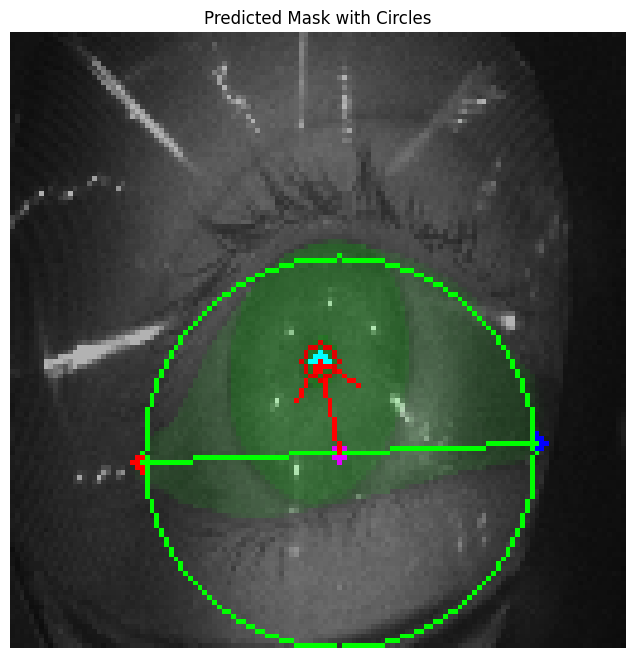

Time taken: 57.972900390625 ms
Iris radius: 4
Leftmost Point: (np.int32(26), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))
Distance between Leftmost and Middle Point: 41
Error processing 92.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(90))
Rightmost Point: (np.int32(109), np.int32(85))


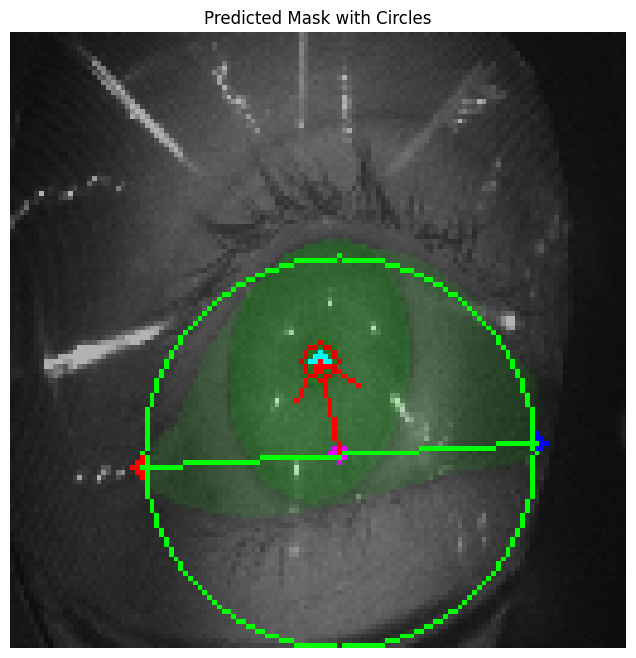

Time taken: 128.759765625 ms
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(89))
Rightmost Point: (np.int32(109), np.int32(86))
Distance between Leftmost and Middle Point: 41
Error processing 93.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(89))
Rightmost Point: (np.int32(109), np.int32(86))


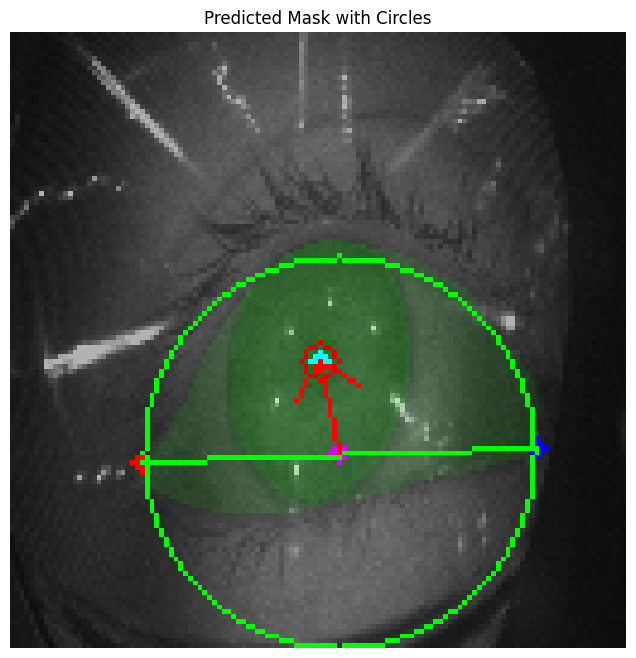

Time taken: 54.858642578125 ms
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(77))
Distance between Leftmost and Middle Point: 42
Error processing 94.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Iris radius: 4
Leftmost Point: (np.int32(26), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))


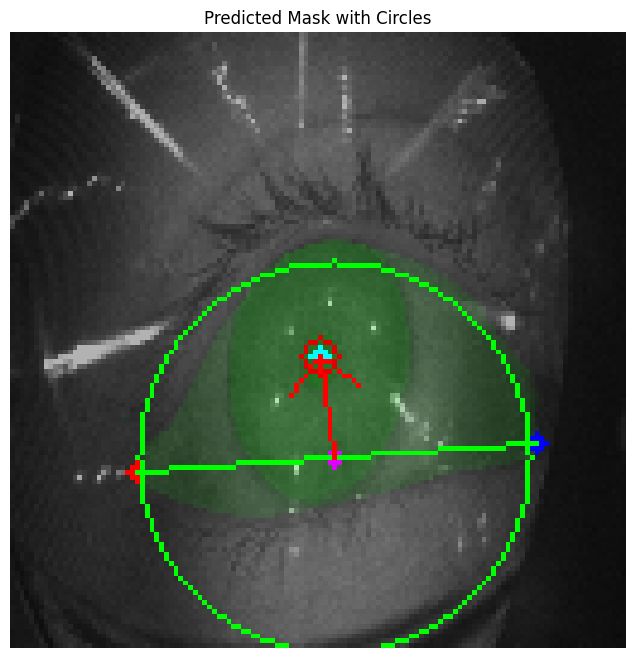

Time taken: 119.211181640625 ms
Iris radius: 4
Leftmost Point: (np.int32(26), np.int32(91))
Rightmost Point: (np.int32(108), np.int32(87))
Distance between Leftmost and Middle Point: 41
Error processing 95.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 3
Leftmost Point: (np.int32(36), np.int32(97))
Rightmost Point: (np.int32(109), np.int32(87))


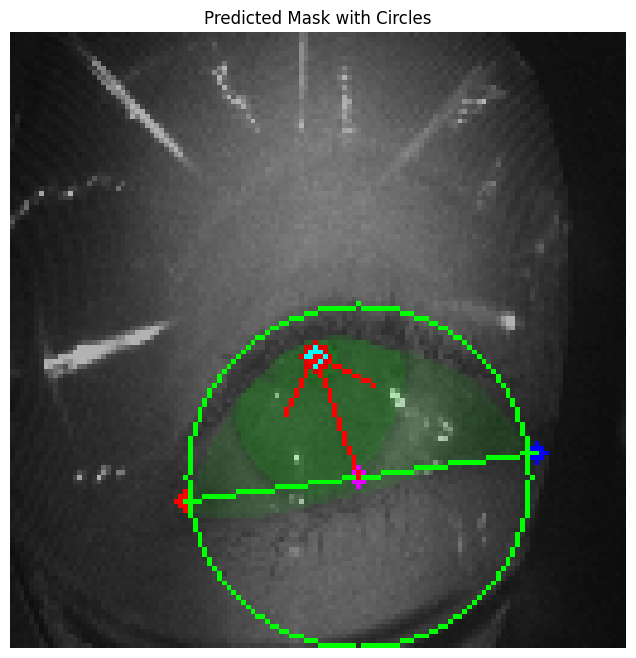

Time taken: 61.255859375 ms
Iris radius: 4
Leftmost Point: (np.int32(35), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 96.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(89))


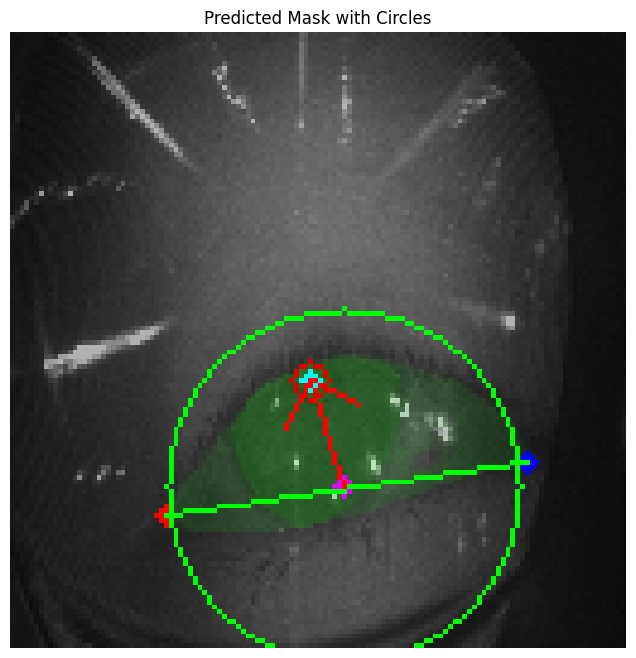

Time taken: 79.90869140625 ms
Iris radius: 3
Leftmost Point: (np.int32(34), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(89))
Distance between Leftmost and Middle Point: 37
Error processing 97.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(107), np.int32(90))


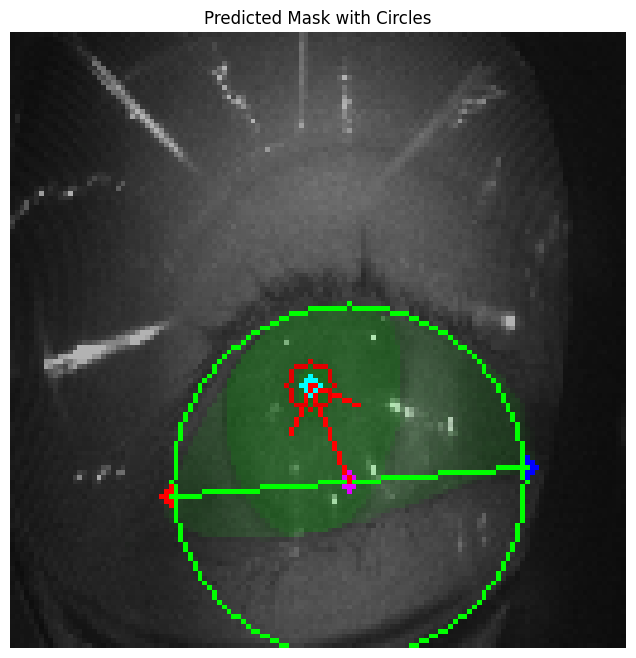

Time taken: 87.02001953125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(85))
Distance between Leftmost and Middle Point: 37
Error processing 98.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(91))


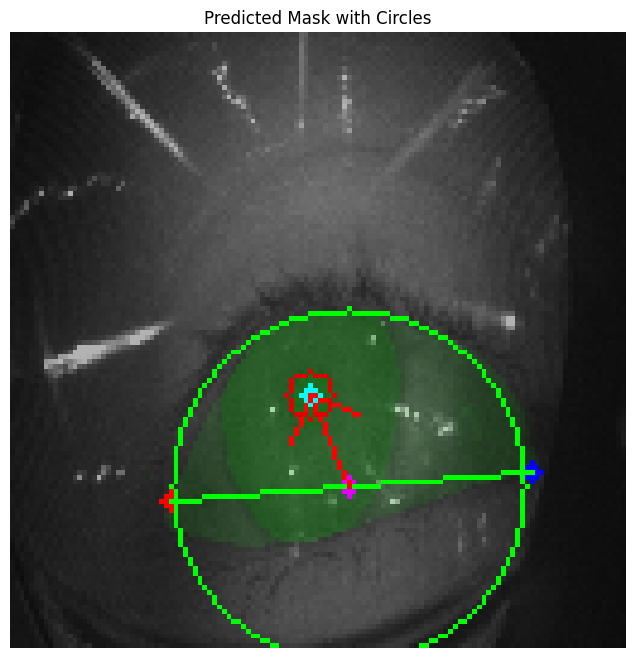

Time taken: 97.45458984375 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(109), np.int32(83))
Distance between Leftmost and Middle Point: 39
Error processing 99.npy: Invalid dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(88))


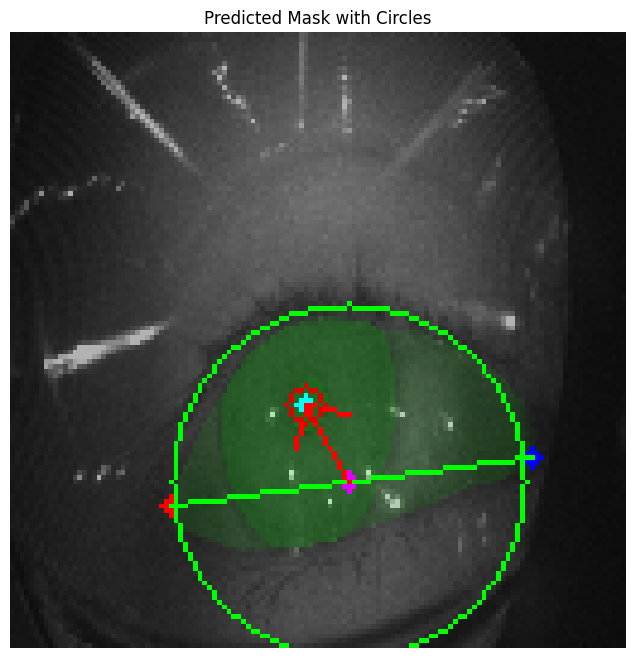

Time taken: 67.929931640625 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(106), np.int32(87))
Distance between Leftmost and Middle Point: 36
Error processing label_102.npy: Invalid dtype: object
Error processing label_108.npy: Invalid dtype: object
Error processing label_120.npy: Invalid dtype: object
Error processing label_132.npy: Invalid dtype: object
Error processing label_137.npy: Invalid dtype: object
Error processing label_149.npy: Invalid dtype: object
Error processing label_21.npy: Invalid dtype: object
Error processing label_23.npy: Invalid dtype: object
Error processing label_39.npy: Invalid dtype: object
Error processing label_41.npy: Invalid dtype: object
Error processing label_42.npy: Invalid dtype: object
Error processing label_53.npy: Invalid dtype: object
Error processing label_86.npy: Invalid dtype: object
Error processing label_91.npy: Invalid dtype: object
Mean error (degrees): 3.1543342091024353


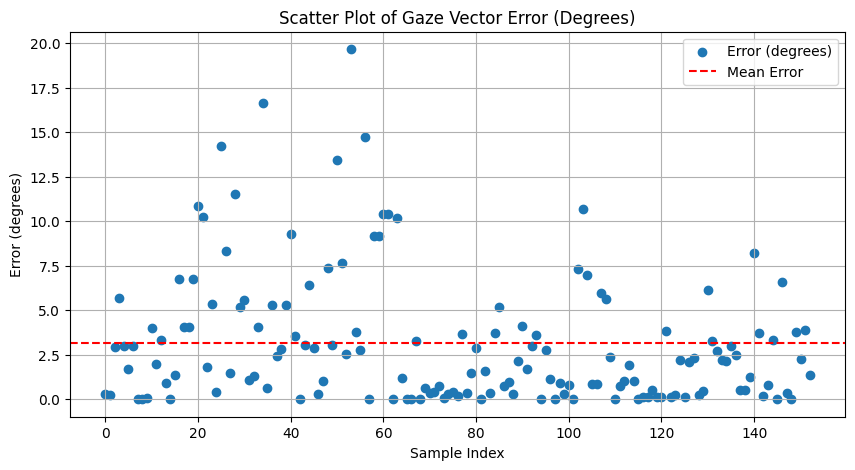

In [45]:
from mpl_toolkits.mplot3d import Axes3D

image_dir_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/S_0'
image_files = sorted(os.listdir(image_dir_path))

K = np.array([[600, 0, 320],
              [0, 600, 240],
              [0,   0,   1]])

def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
# model = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})


gaze_vectors_predict = []
gaze_vectors_actual = []
image_nums = []

for image_file in image_files:
    image_num = image_file.split('.')[0]
    image_path = os.path.join(image_dir_path, image_file)
    label_path = os.path.join(image_dir_path, f"{image_num}.npy")
    try:
        iris_center_predict, middle_point_vector_predict = calculate_gaze_vector_image(image_path, model, resize=False, debug=True)
        iris_center_actual, middle_point_vector_actual = calculate_gaze_vector_from_lable_img(label_path)
        gaze_vector_predict = calculate_gaze_vector(iris_center_predict, middle_point_vector_predict, K)
        gaze_vector_actual = calculate_gaze_vector(iris_center_actual, middle_point_vector_actual, K)
        gaze_vectors_predict.append(gaze_vector_predict)
        gaze_vectors_actual.append(gaze_vector_actual)
        image_nums.append(image_num)
    except Exception as e:
        print(f"Error processing {image_file}: {e}")

gaze_vectors_predict = np.array(gaze_vectors_predict)
gaze_vectors_actual = np.array(gaze_vectors_actual)
image_nums = np.array(image_nums)

# Calculate error degree (angle between predicted and actual gaze vectors)
cos_sim = np.sum(gaze_vectors_predict * gaze_vectors_actual, axis=1) / (
    np.linalg.norm(gaze_vectors_predict, axis=1) * np.linalg.norm(gaze_vectors_actual, axis=1) + 1e-8)
cos_sim = np.clip(cos_sim, -1.0, 1.0)
error_degrees = np.degrees(np.arccos(cos_sim))

print("Mean error (degrees):", np.mean(error_degrees))

plt.figure(figsize=(10, 5))
plt.scatter(range(len(error_degrees)), error_degrees, alpha=1, label='Error (degrees)')
plt.axhline(np.mean(error_degrees), color='red', linestyle='--', label='Mean Error')
plt.xlabel('Sample Index')
plt.ylabel('Error (degrees)')
plt.title('Scatter Plot of Gaze Vector Error (Degrees)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_141667/2324413134.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


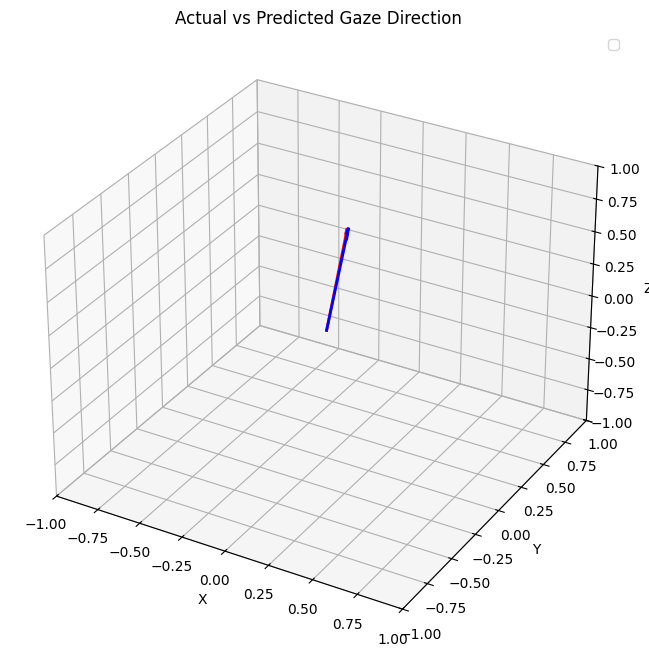

In [37]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

index = 100

ax.quiver(0, 0, 0,
        gaze_vectors_actual[index,0], gaze_vectors_actual[index,1], gaze_vectors_actual[index,2],
        color=(1, 0, 0), linewidth=2, arrow_length_ratio=0.1)


ax.quiver(0, 0, 0,
        gaze_vectors_predict[index,0], gaze_vectors_predict[index,1], gaze_vectors_predict[index,2],
        color=(0, 0, 1), linewidth=2, arrow_length_ratio=0.1)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Actual vs Predicted Gaze Direction')
ax.legend()
plt.show()

Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(93))
Rightmost Point: (np.int32(111), np.int32(91))
Distance between Leftmost and Middle Point: 40


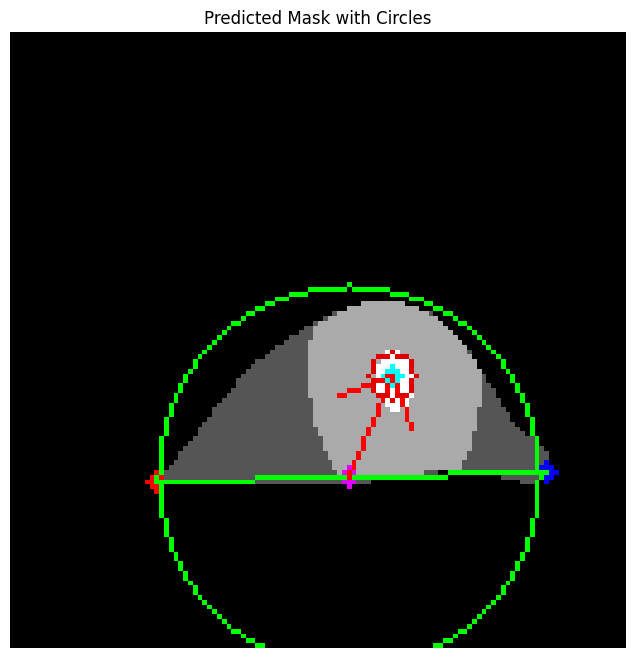

[  9 -21]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_from_lable_img(label_path):
    label = np.load(label_path)
    label = cv2.resize(label, (128, 128))
    label = label / np.max(label)

    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(label >= scalar_lower_bound, label <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(label >= iris_lower_bound, label <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    # Calculate iris radius as the mean distance from center to all contour points
    distances = [np.linalg.norm(np.array([center_x, center_y]) - point[0]) for point in largest_iris_contour]
    iris_radius = round(np.mean(distances)) if distances else 0
    print(f"Iris radius: {iris_radius}")

    # Initialize leftmost and rightmost points
    leftmost = (128, 128)
    rightmost = (0, 0)

    # Find extreme points from all contours
    for contour in scalar_contours:
        for point in contour:
            x, y = point[0]
            if x < leftmost[0]:
                leftmost = (x, y)
            if x > rightmost[0]:
                rightmost = (x, y)

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    distance_left_middle = round(np.linalg.norm(np.array(leftmost) - np.array(middle_point)))
    print(f"Distance between Leftmost and Middle Point: {distance_left_middle}")
    # Convert predicted mask to RGB to draw colored circles
    predicted_mask_rgb = cv2.cvtColor((label * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Draw circles at leftmost and rightmost points
    cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
    cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
    cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
    cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)
    cv2.circle(predicted_mask_rgb, middle_point, radius=distance_left_middle, color=(0, 255, 0), thickness=1)  # Green circle
    cv2.circle(predicted_mask_rgb, iris_center, radius=iris_radius, color=(225, 0, 0), thickness=1) 

    plt.figure(figsize=(8, 8))
    plt.imshow(predicted_mask_rgb)
    plt.title('Predicted Mask with Circles')
    plt.axis('off')
    plt.show()

    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    return iris_center_vector - middle_point_vector


image_label_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels'
print(calculate_gaze_vector_from_lable_img('/home/yasas/GazeEstimation/openEDS/openEDS/test/labels/005310.npy'))

# image_files = sorted(os.listdir(image_label_path))


# for image_file in image_files:
#     image_path = os.path.join(image_label_path, image_file)
#     print(image_path)
#     print(f"Processing {image_path}...")
#     calculate_gaze_vector_from_lable_img(image_path)